In [12]:
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
import re
import pickle
from PIL import Image
#from skimage import data, color
#from skimage.transform import rescale, resize, downscale_local_mean
#from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')

import skimage
from skimage.transform import resize


In [2]:

###########################################
## CHANGE THIS PATHS BASED ON YOUR SYSTEM
HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]
REPOSITORY_PATH='repositories/budai4medtech/amir/'
FULL_REPO_PATH = HOME_PATH+'/'+REPOSITORY_PATH
FULL_DATASET_PATH = FULL_REPO_PATH  + 'datasets/'

print(f'FULL_DATASET_PATH: {FULL_DATASET_PATH}' )
dir = FULL_DATASET_PATH + 'ecgen-radiology'


# dir = "/content/drive/MyDrive/Colab Notebooks/dissertation/ecgen-radiology"

FULL_DATASET_PATH: /home/mxochicale/repositories/budai4medtech/amir/datasets/


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
      for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
      print(e)

1 Physical GPUs, 1 Logical GPUs


2023-07-24 03:50:35.301934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 03:50:35.334989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 03:50:35.335281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
train_dataset = pd.read_csv('Train_Data.csv')
test_dataset = pd.read_csv('Test_Data.csv')
cv_dataset = pd.read_csv('CV_Data.csv')

In [5]:
train_dataset.shape

(2776, 4)

In [6]:
chex = densenet.DenseNet121(include_top=False, weights = None, input_shape=(224,224,3))
X = chex.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
model = Model(inputs=chex.input, outputs=X)
# model.load_weights('/content/drive/MyDrive/code/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')
model.load_weights('brucechou1983_CheXNet_Keras_0.3.0_weights.h5')
model = Model(inputs = model.input, outputs =tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.layers[-2].output))

In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [13]:
def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X,(224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)

    return X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


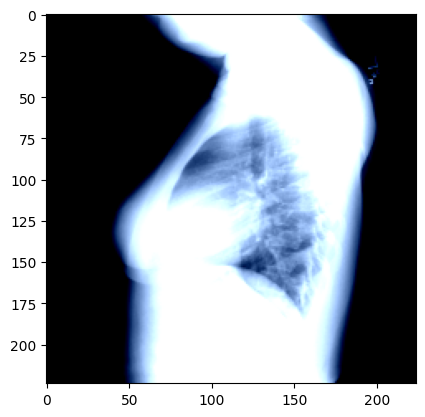

In [18]:

# img = load_image('/content/drive/MyDrive/image/NLMCXR_png/CXR1_1_IM-0001-3001.png')
img = load_image(dir+'/CXR1_1_IM-0001-3001.png')

plt.imshow(img[0])
plt.show()

In [19]:
def image_features(train, test, cv):
    Xnet_features_attention = {}

    for key, img1, img2, finding in tqdm(train.values):
        i1 = load_image(img1)
        img1_features = model.predict(i1)

        i2 = load_image(img2)
        img2_features = model.predict(i2)

        input_ = np.concatenate((img1_features, img2_features), axis=1)
        input_ = tf.reshape(input_, (input_.shape[0], -1, input_.shape[-1]))

        Xnet_features_attention[key] = input_

    for key, img1, img2, finding in tqdm(test.values):
        i1 = load_image(img1)
        img1_features = model.predict(i1)

        i2 = load_image(img2)
        img2_features = model.predict(i2)

        input_ = np.concatenate((img1_features, img2_features), axis=1)
        input_ = tf.reshape(input_, (input_.shape[0], -1, input_.shape[-1]))

        Xnet_features_attention[key] = input_

    for key, img1, img2, finding in tqdm(cv.values):
        i1 = load_image(img1)
        img1_features = model.predict(i1)

        i2 = load_image(img2)
        img2_features = model.predict(i2)

        input_ = np.concatenate((img1_features, img2_features), axis=1)
        input_ = tf.reshape(input_, (input_.shape[0], -1, input_.shape[-1]))

        Xnet_features_attention[key] = input_

    return Xnet_features_attention

#error: axis 2 is out of bounds for array of dimension 2 change concatenate axis=1

In [20]:
train_dataset

,Person_id,Image1,Image2,Report
0,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,startseq there are diffuse bilateral interstit...
1,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,startseq the heart size and mediastinal contou...
2,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,startseq the eamination consists frontal and l...
3,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,startseq the heart size and mediastinal contou...
4,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,startseq the heart and lungs have the interval...
...,...,...,...,...
2771,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,startseq the heart size and pulmonary vascular...
2772,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,startseq the lungs are clear bilaterally . sp...
2773,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,startseq the lungs and pleural spaces show no ...
2774,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,startseq the lungs are clear bilaterally . sp...


In [21]:
Xnet_features_attention = image_features(train_dataset, test_dataset, cv_dataset)

  0%|                                                 | 0/2776 [00:00<?, ?it/s]2023-07-24 03:58:44.598790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-07-24 03:58:45.421661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 30ms/step


  0%|                                       | 1/2776 [00:04<3:09:48,  4.10s/it]

1/1 [==============================] - 0s 36ms/step


  0%|                                       | 2/2776 [00:04<1:26:11,  1.86s/it]

1/1 [==============================] - 0s 27ms/step


  0%|                                         | 3/2776 [00:04<51:34,  1.12s/it]

1/1 [==============================] - 0s 26ms/step


  0%|                                         | 4/2776 [00:04<35:10,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


  0%|                                         | 5/2776 [00:05<26:16,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


  0%|                                         | 6/2776 [00:05<21:09,  2.18it/s]

1/1 [==============================] - 0s 26ms/step


  0%|                                         | 7/2776 [00:05<17:41,  2.61it/s]

1/1 [==============================] - 0s 25ms/step


  0%|                                         | 8/2776 [00:05<15:18,  3.01it/s]

1/1 [==============================] - 0s 27ms/step


  0%|▏                                        | 9/2776 [00:06<13:55,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


  0%|▏                                       | 10/2776 [00:06<12:59,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


  0%|▏                                       | 11/2776 [00:06<12:19,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


  0%|▏                                       | 12/2776 [00:06<11:53,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


  0%|▏                                       | 13/2776 [00:06<11:29,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏                                       | 14/2776 [00:07<11:12,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏                                       | 15/2776 [00:07<11:10,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏                                       | 16/2776 [00:07<10:51,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏                                       | 17/2776 [00:07<10:43,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▎                                       | 18/2776 [00:08<10:54,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▎                                       | 19/2776 [00:08<10:55,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▎                                       | 20/2776 [00:08<10:51,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▎                                       | 21/2776 [00:08<10:39,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▎                                       | 22/2776 [00:09<10:37,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▎                                       | 23/2776 [00:09<10:31,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▎                                       | 24/2776 [00:09<10:53,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▎                                       | 25/2776 [00:09<10:51,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▎                                       | 26/2776 [00:09<10:26,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▍                                       | 27/2776 [00:10<10:05,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▍                                       | 28/2776 [00:10<09:42,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▍                                       | 29/2776 [00:10<09:39,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▍                                       | 30/2776 [00:10<09:15,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▍                                       | 31/2776 [00:10<09:50,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▍                                       | 32/2776 [00:11<10:23,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▍                                       | 33/2776 [00:11<09:58,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▍                                       | 34/2776 [00:11<09:27,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                       | 35/2776 [00:11<09:21,  4.88it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▌                                       | 36/2776 [00:12<09:06,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                       | 37/2776 [00:12<09:02,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                       | 38/2776 [00:12<08:51,  5.15it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                       | 39/2776 [00:12<08:53,  5.13it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▌                                       | 40/2776 [00:12<09:05,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                       | 41/2776 [00:13<09:17,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▌                                       | 42/2776 [00:13<09:08,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▌                                       | 43/2776 [00:13<08:57,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▋                                       | 44/2776 [00:13<08:55,  5.10it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▋                                       | 45/2776 [00:13<08:55,  5.10it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▋                                       | 46/2776 [00:13<08:54,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▋                                       | 47/2776 [00:14<08:58,  5.07it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▋                                       | 48/2776 [00:14<08:43,  5.22it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▋                                       | 49/2776 [00:14<08:39,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▋                                       | 50/2776 [00:14<08:38,  5.26it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▋                                       | 51/2776 [00:14<08:30,  5.33it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▋                                       | 52/2776 [00:15<08:33,  5.30it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▊                                       | 53/2776 [00:15<08:33,  5.31it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▊                                       | 54/2776 [00:15<09:16,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▊                                       | 55/2776 [00:15<09:10,  4.94it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▊                                       | 56/2776 [00:16<10:20,  4.38it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▊                                       | 57/2776 [00:16<10:44,  4.22it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▊                                       | 58/2776 [00:16<12:57,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▊                                       | 59/2776 [00:16<13:02,  3.47it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▊                                       | 60/2776 [00:17<13:12,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▉                                       | 61/2776 [00:17<11:50,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▉                                       | 62/2776 [00:17<11:23,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▉                                       | 63/2776 [00:17<10:43,  4.22it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▉                                       | 64/2776 [00:18<10:52,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▉                                       | 65/2776 [00:18<11:24,  3.96it/s]

1/1 [==============================] - 0s 51ms/step


  2%|▉                                       | 66/2776 [00:18<11:41,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▉                                       | 67/2776 [00:18<11:59,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▉                                       | 68/2776 [00:19<11:07,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▉                                       | 69/2776 [00:19<10:21,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


  3%|█                                       | 70/2776 [00:19<10:01,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


  3%|█                                       | 71/2776 [00:19<09:47,  4.61it/s]

1/1 [==============================] - 0s 27ms/step


  3%|█                                       | 72/2776 [00:19<09:25,  4.78it/s]

1/1 [==============================] - 0s 38ms/step


  3%|█                                       | 73/2776 [00:20<09:45,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


  3%|█                                       | 74/2776 [00:20<09:56,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


  3%|█                                       | 75/2776 [00:20<09:38,  4.67it/s]

1/1 [==============================] - 0s 27ms/step


  3%|█                                       | 76/2776 [00:20<09:21,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


  3%|█                                       | 77/2776 [00:21<09:43,  4.62it/s]

1/1 [==============================] - 0s 35ms/step


  3%|█                                       | 78/2776 [00:21<09:59,  4.50it/s]

1/1 [==============================] - 0s 72ms/step


  3%|█▏                                      | 79/2776 [00:21<13:15,  3.39it/s]

1/1 [==============================] - 0s 62ms/step


  3%|█▏                                      | 80/2776 [00:22<14:45,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


  3%|█▏                                      | 81/2776 [00:22<13:54,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


  3%|█▏                                      | 82/2776 [00:22<12:35,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


  3%|█▏                                      | 83/2776 [00:22<11:33,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


  3%|█▏                                      | 84/2776 [00:23<10:52,  4.12it/s]

1/1 [==============================] - 0s 41ms/step


  3%|█▏                                      | 85/2776 [00:23<11:08,  4.02it/s]

1/1 [==============================] - 0s 42ms/step


  3%|█▏                                      | 86/2776 [00:23<11:46,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


  3%|█▎                                      | 87/2776 [00:23<11:17,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


  3%|█▎                                      | 88/2776 [00:24<10:47,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


  3%|█▎                                      | 89/2776 [00:24<10:15,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


  3%|█▎                                      | 90/2776 [00:24<09:36,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


  3%|█▎                                      | 91/2776 [00:24<09:16,  4.83it/s]

1/1 [==============================] - 0s 27ms/step


  3%|█▎                                      | 92/2776 [00:24<09:09,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


  3%|█▎                                      | 93/2776 [00:25<09:11,  4.87it/s]

1/1 [==============================] - 0s 65ms/step


  3%|█▎                                      | 94/2776 [00:25<11:24,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


  3%|█▎                                      | 95/2776 [00:25<12:24,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


  3%|█▍                                      | 96/2776 [00:26<12:58,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


  3%|█▍                                      | 97/2776 [00:26<11:56,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▍                                      | 98/2776 [00:26<10:55,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▍                                      | 99/2776 [00:26<10:09,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▍                                     | 100/2776 [00:26<09:40,  4.61it/s]

1/1 [==============================] - 0s 36ms/step


  4%|█▍                                     | 101/2776 [00:27<09:58,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


  4%|█▍                                     | 102/2776 [00:27<10:46,  4.14it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▍                                     | 103/2776 [00:27<10:01,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▍                                     | 104/2776 [00:27<09:31,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▍                                     | 105/2776 [00:27<09:20,  4.76it/s]

1/1 [==============================] - 0s 24ms/step


  4%|█▍                                     | 106/2776 [00:28<09:16,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▌                                     | 107/2776 [00:28<08:58,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▌                                     | 108/2776 [00:28<08:46,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▌                                     | 109/2776 [00:28<08:46,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▌                                     | 110/2776 [00:28<08:34,  5.18it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▌                                     | 111/2776 [00:29<08:30,  5.22it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▌                                     | 112/2776 [00:29<08:36,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▌                                     | 113/2776 [00:29<08:29,  5.22it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▌                                     | 114/2776 [00:29<08:24,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▌                                     | 115/2776 [00:29<08:19,  5.32it/s]

1/1 [==============================] - 0s 32ms/step


  4%|█▋                                     | 116/2776 [00:30<08:24,  5.27it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                     | 117/2776 [00:30<08:25,  5.26it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                     | 118/2776 [00:30<08:18,  5.33it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                     | 119/2776 [00:30<08:17,  5.34it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                     | 120/2776 [00:30<08:14,  5.37it/s]

1/1 [==============================] - 0s 28ms/step


  4%|█▋                                     | 121/2776 [00:30<08:15,  5.36it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                     | 122/2776 [00:31<08:18,  5.32it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                     | 123/2776 [00:31<08:20,  5.30it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                     | 124/2776 [00:31<08:19,  5.31it/s]

1/1 [==============================] - 0s 25ms/step


  5%|█▊                                     | 125/2776 [00:31<08:15,  5.35it/s]

1/1 [==============================] - 0s 25ms/step


  5%|█▊                                     | 126/2776 [00:31<08:12,  5.38it/s]

1/1 [==============================] - 0s 28ms/step


  5%|█▊                                     | 127/2776 [00:32<08:30,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


  5%|█▊                                     | 128/2776 [00:32<08:27,  5.22it/s]

1/1 [==============================] - 0s 25ms/step


  5%|█▊                                     | 129/2776 [00:32<08:20,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


  5%|█▊                                     | 130/2776 [00:32<09:11,  4.80it/s]

1/1 [==============================] - 0s 44ms/step


  5%|█▊                                     | 131/2776 [00:32<09:43,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


  5%|█▊                                     | 132/2776 [00:33<09:48,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


  5%|█▊                                     | 133/2776 [00:33<09:23,  4.69it/s]

1/1 [==============================] - 0s 41ms/step


  5%|█▉                                     | 134/2776 [00:33<10:02,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


  5%|█▉                                     | 135/2776 [00:33<11:21,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


  5%|█▉                                     | 136/2776 [00:34<10:51,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


  5%|█▉                                     | 137/2776 [00:34<10:21,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


  5%|█▉                                     | 138/2776 [00:34<10:09,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


  5%|█▉                                     | 139/2776 [00:34<10:00,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


  5%|█▉                                     | 140/2776 [00:35<09:23,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


  5%|█▉                                     | 141/2776 [00:35<09:35,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


  5%|█▉                                     | 142/2776 [00:35<09:19,  4.70it/s]

1/1 [==============================] - 0s 32ms/step


  5%|██                                     | 143/2776 [00:35<09:23,  4.67it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██                                     | 144/2776 [00:35<09:15,  4.74it/s]

1/1 [==============================] - 0s 38ms/step


  5%|██                                     | 145/2776 [00:36<09:22,  4.68it/s]

1/1 [==============================] - 0s 39ms/step


  5%|██                                     | 146/2776 [00:36<10:37,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██                                     | 147/2776 [00:36<10:44,  4.08it/s]

1/1 [==============================] - 0s 36ms/step


  5%|██                                     | 148/2776 [00:36<11:21,  3.85it/s]

1/1 [==============================] - 0s 41ms/step


  5%|██                                     | 149/2776 [00:37<11:35,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


  5%|██                                     | 150/2776 [00:37<11:04,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


  5%|██                                     | 151/2776 [00:37<10:45,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                    | 152/2776 [00:37<10:04,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


  6%|██▏                                    | 153/2776 [00:38<10:06,  4.33it/s]

1/1 [==============================] - 0s 42ms/step


  6%|██▏                                    | 154/2776 [00:38<10:33,  4.14it/s]

1/1 [==============================] - 0s 43ms/step


  6%|██▏                                    | 155/2776 [00:38<11:05,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▏                                    | 156/2776 [00:38<11:02,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▏                                    | 157/2776 [00:39<10:15,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


  6%|██▏                                    | 158/2776 [00:39<10:27,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▏                                    | 159/2776 [00:39<09:55,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


  6%|██▏                                    | 160/2776 [00:39<09:51,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


  6%|██▎                                    | 161/2776 [00:40<10:13,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▎                                    | 162/2776 [00:40<10:23,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


  6%|██▎                                    | 163/2776 [00:40<09:56,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


  6%|██▎                                    | 164/2776 [00:40<09:49,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▎                                    | 165/2776 [00:40<09:54,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


  6%|██▎                                    | 166/2776 [00:41<09:41,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


  6%|██▎                                    | 167/2776 [00:41<09:51,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▎                                    | 168/2776 [00:41<09:39,  4.50it/s]

1/1 [==============================] - 0s 42ms/step


  6%|██▎                                    | 169/2776 [00:41<10:15,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


  6%|██▍                                    | 170/2776 [00:42<10:30,  4.14it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▍                                    | 171/2776 [00:42<09:59,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


  6%|██▍                                    | 172/2776 [00:42<09:37,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▍                                    | 173/2776 [00:42<09:09,  4.74it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▍                                    | 174/2776 [00:42<08:53,  4.88it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▍                                    | 175/2776 [00:43<08:36,  5.04it/s]

1/1 [==============================] - 0s 29ms/step


  6%|██▍                                    | 176/2776 [00:43<08:31,  5.09it/s]

1/1 [==============================] - 0s 29ms/step


  6%|██▍                                    | 177/2776 [00:43<08:30,  5.09it/s]

1/1 [==============================] - 0s 36ms/step


  6%|██▌                                    | 178/2776 [00:43<09:31,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▌                                    | 179/2776 [00:43<09:45,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▌                                    | 180/2776 [00:44<09:19,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


  7%|██▌                                    | 181/2776 [00:44<09:14,  4.68it/s]

1/1 [==============================] - 0s 25ms/step


  7%|██▌                                    | 182/2776 [00:44<08:52,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


  7%|██▌                                    | 183/2776 [00:44<08:35,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


  7%|██▌                                    | 184/2776 [00:44<08:32,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


  7%|██▌                                    | 185/2776 [00:45<08:21,  5.17it/s]

1/1 [==============================] - 0s 28ms/step


  7%|██▌                                    | 186/2776 [00:45<08:29,  5.09it/s]

1/1 [==============================] - 0s 25ms/step


  7%|██▋                                    | 187/2776 [00:45<08:21,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


  7%|██▋                                    | 188/2776 [00:45<08:14,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


  7%|██▋                                    | 189/2776 [00:45<08:30,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


  7%|██▋                                    | 190/2776 [00:46<08:25,  5.11it/s]

1/1 [==============================] - 0s 26ms/step


  7%|██▋                                    | 191/2776 [00:46<08:30,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


  7%|██▋                                    | 192/2776 [00:46<08:22,  5.14it/s]

1/1 [==============================] - 0s 25ms/step


  7%|██▋                                    | 193/2776 [00:46<08:08,  5.29it/s]

1/1 [==============================] - 0s 26ms/step


  7%|██▋                                    | 194/2776 [00:46<08:00,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


  7%|██▋                                    | 195/2776 [00:47<08:12,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


  7%|██▊                                    | 196/2776 [00:47<08:07,  5.29it/s]

1/1 [==============================] - 0s 26ms/step


  7%|██▊                                    | 197/2776 [00:47<08:09,  5.27it/s]

1/1 [==============================] - 0s 25ms/step


  7%|██▊                                    | 198/2776 [00:47<08:06,  5.30it/s]

1/1 [==============================] - 0s 26ms/step


  7%|██▊                                    | 199/2776 [00:47<08:01,  5.36it/s]

1/1 [==============================] - 0s 25ms/step


  7%|██▊                                    | 200/2776 [00:48<08:28,  5.06it/s]

1/1 [==============================] - 0s 31ms/step


  7%|██▊                                    | 201/2776 [00:48<08:24,  5.11it/s]

1/1 [==============================] - 0s 29ms/step


  7%|██▊                                    | 202/2776 [00:48<08:13,  5.21it/s]

1/1 [==============================] - 0s 26ms/step


  7%|██▊                                    | 203/2776 [00:48<08:10,  5.25it/s]

1/1 [==============================] - 0s 26ms/step


  7%|██▊                                    | 204/2776 [00:48<08:15,  5.20it/s]

1/1 [==============================] - 0s 24ms/step


  7%|██▉                                    | 205/2776 [00:48<08:09,  5.26it/s]

1/1 [==============================] - 0s 24ms/step


  7%|██▉                                    | 206/2776 [00:49<07:58,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


  7%|██▉                                    | 207/2776 [00:49<07:56,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


  7%|██▉                                    | 208/2776 [00:49<08:12,  5.21it/s]

1/1 [==============================] - 0s 25ms/step


  8%|██▉                                    | 209/2776 [00:49<08:10,  5.23it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██▉                                    | 210/2776 [00:49<08:17,  5.15it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██▉                                    | 211/2776 [00:50<08:31,  5.02it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██▉                                    | 212/2776 [00:50<08:43,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██▉                                    | 213/2776 [00:50<08:53,  4.80it/s]

1/1 [==============================] - 0s 34ms/step


  8%|███                                    | 214/2776 [00:50<08:43,  4.89it/s]

1/1 [==============================] - 0s 51ms/step


  8%|███                                    | 215/2776 [00:51<10:39,  4.01it/s]

1/1 [==============================] - 0s 51ms/step


  8%|███                                    | 216/2776 [00:51<12:29,  3.41it/s]

1/1 [==============================] - 0s 77ms/step


  8%|███                                    | 217/2776 [00:51<14:32,  2.93it/s]

1/1 [==============================] - 0s 36ms/step


  8%|███                                    | 218/2776 [00:52<15:47,  2.70it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███                                    | 219/2776 [00:52<13:57,  3.05it/s]

1/1 [==============================] - 0s 37ms/step


  8%|███                                    | 220/2776 [00:52<12:54,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███                                    | 221/2776 [00:53<11:41,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███                                    | 222/2776 [00:53<12:30,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▏                                   | 223/2776 [00:53<11:18,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▏                                   | 224/2776 [00:53<10:16,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


  8%|███▏                                   | 225/2776 [00:54<09:56,  4.28it/s]

1/1 [==============================] - 0s 46ms/step


  8%|███▏                                   | 226/2776 [00:54<10:28,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▏                                   | 227/2776 [00:54<10:14,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▏                                   | 228/2776 [00:54<09:44,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▏                                   | 229/2776 [00:54<09:15,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▏                                   | 230/2776 [00:55<08:46,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▏                                   | 231/2776 [00:55<08:37,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                   | 232/2776 [00:55<08:25,  5.03it/s]

1/1 [==============================] - 0s 39ms/step


  8%|███▎                                   | 233/2776 [00:55<10:34,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


  8%|███▎                                   | 234/2776 [00:56<10:10,  4.16it/s]

1/1 [==============================] - 0s 45ms/step


  8%|███▎                                   | 235/2776 [00:56<10:14,  4.14it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███▎                                   | 236/2776 [00:56<10:57,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


  9%|███▎                                   | 237/2776 [00:56<10:33,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▎                                   | 238/2776 [00:57<09:53,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


  9%|███▎                                   | 239/2776 [00:57<10:26,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▎                                   | 240/2776 [00:57<10:31,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▍                                   | 241/2776 [00:57<09:53,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▍                                   | 242/2776 [00:58<09:30,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▍                                   | 243/2776 [00:58<09:28,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███▍                                   | 244/2776 [00:58<09:05,  4.64it/s]

1/1 [==============================] - 0s 53ms/step


  9%|███▍                                   | 245/2776 [00:58<10:34,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███▍                                   | 246/2776 [00:59<10:36,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▍                                   | 247/2776 [00:59<10:01,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███▍                                   | 248/2776 [00:59<09:41,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███▍                                   | 249/2776 [00:59<09:27,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▌                                   | 250/2776 [00:59<09:16,  4.54it/s]

1/1 [==============================] - 0s 54ms/step


  9%|███▌                                   | 251/2776 [01:00<12:08,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███▌                                   | 252/2776 [01:00<11:51,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███▌                                   | 253/2776 [01:00<10:55,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███▌                                   | 254/2776 [01:00<10:06,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▌                                   | 255/2776 [01:01<09:25,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▌                                   | 256/2776 [01:01<08:53,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▌                                   | 257/2776 [01:01<08:35,  4.88it/s]

1/1 [==============================] - 0s 35ms/step


  9%|███▌                                   | 258/2776 [01:01<09:02,  4.64it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███▋                                   | 259/2776 [01:01<09:02,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▋                                   | 260/2776 [01:02<08:41,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▋                                   | 261/2776 [01:02<08:28,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███▋                                   | 262/2776 [01:02<08:17,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▋                                   | 263/2776 [01:02<08:15,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


 10%|███▋                                   | 264/2776 [01:02<08:11,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


 10%|███▋                                   | 265/2776 [01:03<08:03,  5.20it/s]

1/1 [==============================] - 0s 25ms/step


 10%|███▋                                   | 266/2776 [01:03<07:58,  5.25it/s]

1/1 [==============================] - 0s 26ms/step


 10%|███▊                                   | 267/2776 [01:03<08:03,  5.19it/s]

1/1 [==============================] - 0s 25ms/step


 10%|███▊                                   | 268/2776 [01:03<08:09,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


 10%|███▊                                   | 269/2776 [01:03<08:09,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


 10%|███▊                                   | 270/2776 [01:04<08:14,  5.06it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███▊                                   | 271/2776 [01:04<08:21,  5.00it/s]

1/1 [==============================] - 0s 33ms/step


 10%|███▊                                   | 272/2776 [01:04<08:46,  4.76it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███▊                                   | 273/2776 [01:04<08:48,  4.74it/s]

1/1 [==============================] - 0s 25ms/step


 10%|███▊                                   | 274/2776 [01:04<08:34,  4.86it/s]

1/1 [==============================] - 0s 32ms/step


 10%|███▊                                   | 275/2776 [01:05<08:38,  4.82it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███▉                                   | 276/2776 [01:05<08:38,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


 10%|███▉                                   | 277/2776 [01:05<08:19,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


 10%|███▉                                   | 278/2776 [01:05<08:12,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


 10%|███▉                                   | 279/2776 [01:05<08:14,  5.04it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███▉                                   | 280/2776 [01:06<08:38,  4.81it/s]

1/1 [==============================] - 0s 26ms/step


 10%|███▉                                   | 281/2776 [01:06<08:28,  4.91it/s]

1/1 [==============================] - 0s 46ms/step


 10%|███▉                                   | 282/2776 [01:06<08:52,  4.68it/s]

1/1 [==============================] - 0s 25ms/step


 10%|███▉                                   | 283/2776 [01:06<08:46,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███▉                                   | 284/2776 [01:06<08:33,  4.85it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████                                   | 285/2776 [01:07<08:44,  4.75it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████                                   | 286/2776 [01:07<08:32,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████                                   | 287/2776 [01:07<08:16,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████                                   | 288/2776 [01:07<08:09,  5.08it/s]

1/1 [==============================] - 0s 37ms/step


 10%|████                                   | 289/2776 [01:08<08:52,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████                                   | 290/2776 [01:08<08:53,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████                                   | 291/2776 [01:08<08:48,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████                                   | 292/2776 [01:08<08:31,  4.85it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████                                   | 293/2776 [01:08<08:21,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▏                                  | 294/2776 [01:09<08:21,  4.95it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▏                                  | 295/2776 [01:09<08:21,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▏                                  | 296/2776 [01:09<08:26,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▏                                  | 297/2776 [01:09<08:28,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████▏                                  | 298/2776 [01:09<08:27,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▏                                  | 299/2776 [01:10<08:34,  4.81it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▏                                  | 300/2776 [01:10<08:43,  4.73it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▏                                  | 301/2776 [01:10<08:48,  4.68it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▏                                  | 302/2776 [01:10<08:45,  4.71it/s]

1/1 [==============================] - 0s 32ms/step


 11%|████▎                                  | 303/2776 [01:10<08:46,  4.69it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▎                                  | 304/2776 [01:11<08:28,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▎                                  | 305/2776 [01:11<08:09,  5.05it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████▎                                  | 306/2776 [01:11<08:05,  5.09it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▎                                  | 307/2776 [01:11<08:10,  5.03it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▎                                  | 308/2776 [01:11<08:36,  4.78it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▎                                  | 309/2776 [01:12<08:30,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▎                                  | 310/2776 [01:12<08:25,  4.88it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▎                                  | 311/2776 [01:12<08:09,  5.03it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████▍                                  | 312/2776 [01:12<08:20,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████▍                                  | 313/2776 [01:12<08:35,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████▍                                  | 314/2776 [01:13<08:43,  4.70it/s]

1/1 [==============================] - 0s 32ms/step


 11%|████▍                                  | 315/2776 [01:13<08:54,  4.60it/s]

1/1 [==============================] - 0s 36ms/step


 11%|████▍                                  | 316/2776 [01:13<09:22,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▍                                  | 317/2776 [01:13<09:06,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████▍                                  | 318/2776 [01:14<08:57,  4.57it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▍                                  | 319/2776 [01:14<08:33,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▍                                  | 320/2776 [01:14<08:31,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 12%|████▌                                  | 321/2776 [01:14<08:36,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▌                                  | 322/2776 [01:14<08:22,  4.89it/s]

1/1 [==============================] - 0s 35ms/step


 12%|████▌                                  | 323/2776 [01:15<08:30,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 12%|████▌                                  | 324/2776 [01:15<08:40,  4.71it/s]

1/1 [==============================] - 0s 33ms/step


 12%|████▌                                  | 325/2776 [01:15<08:59,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▌                                  | 326/2776 [01:15<08:51,  4.61it/s]

1/1 [==============================] - 0s 39ms/step


 12%|████▌                                  | 327/2776 [01:16<08:54,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▌                                  | 328/2776 [01:16<08:46,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▌                                  | 329/2776 [01:16<08:23,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▋                                  | 330/2776 [01:16<08:15,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▋                                  | 331/2776 [01:16<08:24,  4.85it/s]

1/1 [==============================] - 0s 26ms/step


 12%|████▋                                  | 332/2776 [01:17<08:15,  4.93it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▋                                  | 333/2776 [01:17<08:21,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


 12%|████▋                                  | 334/2776 [01:17<08:11,  4.97it/s]

1/1 [==============================] - 0s 33ms/step


 12%|████▋                                  | 335/2776 [01:17<08:29,  4.79it/s]

1/1 [==============================] - 0s 32ms/step


 12%|████▋                                  | 336/2776 [01:17<08:50,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▋                                  | 337/2776 [01:18<08:37,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▋                                  | 338/2776 [01:18<08:30,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▊                                  | 339/2776 [01:18<08:23,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 12%|████▊                                  | 340/2776 [01:18<08:22,  4.85it/s]

1/1 [==============================] - 0s 34ms/step


 12%|████▊                                  | 341/2776 [01:18<08:38,  4.70it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▊                                  | 342/2776 [01:19<08:27,  4.80it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▊                                  | 343/2776 [01:19<08:15,  4.91it/s]

1/1 [==============================] - 0s 31ms/step


 12%|████▊                                  | 344/2776 [01:19<08:06,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▊                                  | 345/2776 [01:19<08:00,  5.06it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▊                                  | 346/2776 [01:19<07:49,  5.18it/s]

1/1 [==============================] - 0s 33ms/step


 12%|████▉                                  | 347/2776 [01:20<08:06,  4.99it/s]

1/1 [==============================] - 0s 27ms/step


 13%|████▉                                  | 348/2776 [01:20<08:07,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


 13%|████▉                                  | 349/2776 [01:20<08:03,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


 13%|████▉                                  | 350/2776 [01:20<08:01,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


 13%|████▉                                  | 351/2776 [01:20<07:56,  5.09it/s]

1/1 [==============================] - 0s 29ms/step


 13%|████▉                                  | 352/2776 [01:21<07:51,  5.14it/s]

1/1 [==============================] - 0s 26ms/step


 13%|████▉                                  | 353/2776 [01:21<07:46,  5.20it/s]

1/1 [==============================] - 0s 25ms/step


 13%|████▉                                  | 354/2776 [01:21<07:49,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


 13%|████▉                                  | 355/2776 [01:21<07:41,  5.25it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█████                                  | 356/2776 [01:21<07:42,  5.23it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█████                                  | 357/2776 [01:22<08:00,  5.04it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█████                                  | 358/2776 [01:22<08:07,  4.96it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█████                                  | 359/2776 [01:22<08:04,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█████                                  | 360/2776 [01:22<07:56,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█████                                  | 361/2776 [01:22<08:05,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█████                                  | 362/2776 [01:23<07:57,  5.06it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█████                                  | 363/2776 [01:23<07:48,  5.15it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█████                                  | 364/2776 [01:23<07:51,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█████▏                                 | 365/2776 [01:23<07:44,  5.19it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█████▏                                 | 366/2776 [01:23<07:47,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█████▏                                 | 367/2776 [01:24<07:58,  5.04it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█████▏                                 | 368/2776 [01:24<08:04,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█████▏                                 | 369/2776 [01:24<07:56,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█████▏                                 | 370/2776 [01:24<08:01,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█████▏                                 | 371/2776 [01:24<07:50,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█████▏                                 | 372/2776 [01:24<07:50,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█████▏                                 | 373/2776 [01:25<08:01,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█████▎                                 | 374/2776 [01:25<07:53,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▎                                 | 375/2776 [01:25<08:00,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▎                                 | 376/2776 [01:25<07:59,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▎                                 | 377/2776 [01:25<07:57,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▎                                 | 378/2776 [01:26<07:58,  5.01it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█████▎                                 | 379/2776 [01:26<07:55,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▎                                 | 380/2776 [01:26<07:49,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▎                                 | 381/2776 [01:26<07:40,  5.20it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▎                                 | 382/2776 [01:26<07:47,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▍                                 | 383/2776 [01:27<07:38,  5.22it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▍                                 | 384/2776 [01:27<07:33,  5.28it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█████▍                                 | 385/2776 [01:27<07:49,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▍                                 | 386/2776 [01:27<07:44,  5.14it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▍                                 | 387/2776 [01:27<07:37,  5.22it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█████▍                                 | 388/2776 [01:28<07:56,  5.01it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▍                                 | 389/2776 [01:28<07:48,  5.09it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▍                                 | 390/2776 [01:28<07:46,  5.11it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█████▍                                 | 391/2776 [01:28<07:49,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▌                                 | 392/2776 [01:28<08:02,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█████▌                                 | 393/2776 [01:29<07:57,  4.99it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▌                                 | 394/2776 [01:29<07:51,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▌                                 | 395/2776 [01:29<07:47,  5.09it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▌                                 | 396/2776 [01:29<07:43,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▌                                 | 397/2776 [01:29<07:41,  5.15it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▌                                 | 398/2776 [01:30<07:44,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▌                                 | 399/2776 [01:30<07:41,  5.15it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█████▌                                 | 400/2776 [01:30<07:45,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▋                                 | 401/2776 [01:30<07:48,  5.07it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█████▋                                 | 402/2776 [01:31<10:56,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█████▋                                 | 403/2776 [01:31<10:07,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█████▋                                 | 404/2776 [01:31<09:36,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█████▋                                 | 405/2776 [01:31<09:02,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█████▋                                 | 406/2776 [01:31<08:35,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█████▋                                 | 407/2776 [01:32<08:50,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█████▋                                 | 408/2776 [01:32<08:28,  4.66it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█████▋                                 | 409/2776 [01:32<08:22,  4.71it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█████▊                                 | 410/2776 [01:32<08:13,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█████▊                                 | 411/2776 [01:33<08:10,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█████▊                                 | 412/2776 [01:33<08:08,  4.84it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█████▊                                 | 413/2776 [01:33<08:08,  4.84it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█████▊                                 | 414/2776 [01:33<08:08,  4.84it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█████▊                                 | 415/2776 [01:33<08:14,  4.77it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█████▊                                 | 416/2776 [01:34<08:21,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█████▊                                 | 417/2776 [01:34<08:11,  4.80it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█████▊                                 | 418/2776 [01:34<08:14,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█████▉                                 | 419/2776 [01:34<08:00,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█████▉                                 | 420/2776 [01:34<08:02,  4.89it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█████▉                                 | 421/2776 [01:35<08:09,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█████▉                                 | 422/2776 [01:35<08:12,  4.78it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█████▉                                 | 423/2776 [01:35<08:10,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█████▉                                 | 424/2776 [01:35<08:29,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█████▉                                 | 425/2776 [01:35<08:31,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█████▉                                 | 426/2776 [01:36<08:22,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█████▉                                 | 427/2776 [01:36<08:14,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████                                 | 428/2776 [01:36<08:05,  4.84it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████                                 | 429/2776 [01:36<08:08,  4.81it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████                                 | 430/2776 [01:36<08:01,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████                                 | 431/2776 [01:37<07:51,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████                                 | 432/2776 [01:37<07:47,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████                                 | 433/2776 [01:37<07:48,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████                                 | 434/2776 [01:37<07:48,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


 16%|██████                                 | 435/2776 [01:37<07:57,  4.91it/s]

1/1 [==============================] - 0s 36ms/step


 16%|██████▏                                | 436/2776 [01:38<08:08,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▏                                | 437/2776 [01:38<08:06,  4.80it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▏                                | 438/2776 [01:38<07:54,  4.93it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▏                                | 439/2776 [01:38<07:51,  4.96it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▏                                | 440/2776 [01:38<07:49,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▏                                | 441/2776 [01:39<07:43,  5.04it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▏                                | 442/2776 [01:39<07:27,  5.22it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▏                                | 443/2776 [01:39<07:32,  5.15it/s]

1/1 [==============================] - 0s 28ms/step


 16%|██████▏                                | 444/2776 [01:39<07:29,  5.19it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▎                                | 445/2776 [01:39<07:30,  5.18it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▎                                | 446/2776 [01:40<07:35,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▎                                | 447/2776 [01:40<07:29,  5.19it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▎                                | 448/2776 [01:40<07:27,  5.21it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▎                                | 449/2776 [01:40<07:30,  5.16it/s]

1/1 [==============================] - 0s 29ms/step


 16%|██████▎                                | 450/2776 [01:40<07:40,  5.05it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▎                                | 451/2776 [01:41<07:43,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▎                                | 452/2776 [01:41<07:51,  4.93it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▎                                | 453/2776 [01:41<07:46,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▍                                | 454/2776 [01:41<07:43,  5.01it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▍                                | 455/2776 [01:41<07:48,  4.96it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▍                                | 456/2776 [01:42<07:55,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▍                                | 457/2776 [01:42<07:47,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 16%|██████▍                                | 458/2776 [01:42<07:59,  4.84it/s]

1/1 [==============================] - 0s 37ms/step


 17%|██████▍                                | 459/2776 [01:42<08:03,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


 17%|██████▍                                | 460/2776 [01:43<08:18,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


 17%|██████▍                                | 461/2776 [01:43<08:02,  4.80it/s]

1/1 [==============================] - 0s 31ms/step


 17%|██████▍                                | 462/2776 [01:43<07:52,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


 17%|██████▌                                | 463/2776 [01:43<07:39,  5.03it/s]

1/1 [==============================] - 0s 26ms/step


 17%|██████▌                                | 464/2776 [01:43<07:42,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


 17%|██████▌                                | 465/2776 [01:43<07:45,  4.96it/s]

1/1 [==============================] - 0s 27ms/step


 17%|██████▌                                | 466/2776 [01:44<07:58,  4.83it/s]

1/1 [==============================] - 0s 26ms/step


 17%|██████▌                                | 467/2776 [01:44<07:49,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


 17%|██████▌                                | 468/2776 [01:44<07:39,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


 17%|██████▌                                | 469/2776 [01:44<07:39,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


 17%|██████▌                                | 470/2776 [01:44<07:43,  4.97it/s]

1/1 [==============================] - 0s 27ms/step


 17%|██████▌                                | 471/2776 [01:45<07:33,  5.08it/s]

1/1 [==============================] - 0s 26ms/step


 17%|██████▋                                | 472/2776 [01:45<07:32,  5.09it/s]

1/1 [==============================] - 0s 27ms/step


 17%|██████▋                                | 473/2776 [01:45<07:42,  4.98it/s]

1/1 [==============================] - 0s 28ms/step


 17%|██████▋                                | 474/2776 [01:45<07:40,  5.00it/s]

1/1 [==============================] - 0s 27ms/step


 17%|██████▋                                | 475/2776 [01:45<07:47,  4.93it/s]

1/1 [==============================] - 0s 27ms/step


 17%|██████▋                                | 476/2776 [01:46<07:48,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


 17%|██████▋                                | 477/2776 [01:46<07:44,  4.95it/s]

1/1 [==============================] - 0s 27ms/step


 17%|██████▋                                | 478/2776 [01:46<07:41,  4.98it/s]

1/1 [==============================] - 0s 28ms/step


 17%|██████▋                                | 479/2776 [01:46<07:45,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


 17%|██████▋                                | 480/2776 [01:46<07:39,  5.00it/s]

1/1 [==============================] - 0s 26ms/step


 17%|██████▊                                | 481/2776 [01:47<07:35,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


 17%|██████▊                                | 482/2776 [01:47<07:35,  5.03it/s]

1/1 [==============================] - 0s 27ms/step


 17%|██████▊                                | 483/2776 [01:47<07:44,  4.93it/s]

1/1 [==============================] - 0s 34ms/step


 17%|██████▊                                | 484/2776 [01:47<08:07,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 17%|██████▊                                | 485/2776 [01:48<08:11,  4.66it/s]

1/1 [==============================] - 0s 32ms/step


 18%|██████▊                                | 486/2776 [01:48<08:39,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


 18%|██████▊                                | 487/2776 [01:48<08:41,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 18%|██████▊                                | 488/2776 [01:48<08:18,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 18%|██████▊                                | 489/2776 [01:48<08:10,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


 18%|██████▉                                | 490/2776 [01:49<07:57,  4.78it/s]

1/1 [==============================] - 0s 25ms/step


 18%|██████▉                                | 491/2776 [01:49<07:43,  4.93it/s]

1/1 [==============================] - 0s 26ms/step


 18%|██████▉                                | 492/2776 [01:49<07:40,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


 18%|██████▉                                | 493/2776 [01:49<07:49,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


 18%|██████▉                                | 494/2776 [01:49<07:46,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 18%|██████▉                                | 495/2776 [01:50<07:53,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


 18%|██████▉                                | 496/2776 [01:50<07:39,  4.97it/s]

1/1 [==============================] - 0s 28ms/step


 18%|██████▉                                | 497/2776 [01:50<07:43,  4.91it/s]

1/1 [==============================] - 0s 25ms/step


 18%|██████▉                                | 498/2776 [01:50<07:45,  4.89it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████                                | 499/2776 [01:50<07:36,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████                                | 500/2776 [01:51<07:35,  5.00it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████                                | 501/2776 [01:51<07:43,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████                                | 502/2776 [01:51<07:42,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████                                | 503/2776 [01:51<07:37,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████                                | 504/2776 [01:51<07:28,  5.07it/s]

1/1 [==============================] - 0s 29ms/step


 18%|███████                                | 505/2776 [01:52<07:36,  4.97it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████                                | 506/2776 [01:52<07:35,  4.99it/s]

1/1 [==============================] - 0s 28ms/step


 18%|███████                                | 507/2776 [01:52<07:45,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▏                               | 508/2776 [01:52<07:31,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▏                               | 509/2776 [01:52<07:29,  5.04it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▏                               | 510/2776 [01:53<07:37,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


 18%|███████▏                               | 511/2776 [01:53<07:34,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▏                               | 512/2776 [01:53<07:36,  4.96it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▏                               | 513/2776 [01:53<07:30,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▏                               | 514/2776 [01:53<07:27,  5.05it/s]

1/1 [==============================] - 0s 30ms/step


 19%|███████▏                               | 515/2776 [01:54<07:35,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▏                               | 516/2776 [01:54<07:33,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▎                               | 517/2776 [01:54<07:29,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


 19%|███████▎                               | 518/2776 [01:54<07:18,  5.15it/s]

1/1 [==============================] - 0s 28ms/step


 19%|███████▎                               | 519/2776 [01:54<07:22,  5.10it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▎                               | 520/2776 [01:55<07:20,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▎                               | 521/2776 [01:55<07:12,  5.22it/s]

1/1 [==============================] - 0s 29ms/step


 19%|███████▎                               | 522/2776 [01:55<07:12,  5.21it/s]

1/1 [==============================] - 0s 25ms/step


 19%|███████▎                               | 523/2776 [01:55<07:16,  5.17it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▎                               | 524/2776 [01:55<07:12,  5.21it/s]

1/1 [==============================] - 0s 24ms/step


 19%|███████▍                               | 525/2776 [01:56<07:09,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


 19%|███████▍                               | 526/2776 [01:56<07:28,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


 19%|███████▍                               | 527/2776 [01:56<07:27,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


 19%|███████▍                               | 528/2776 [01:56<07:31,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▍                               | 529/2776 [01:56<07:19,  5.11it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▍                               | 530/2776 [01:57<07:10,  5.22it/s]

1/1 [==============================] - 0s 25ms/step


 19%|███████▍                               | 531/2776 [01:57<07:18,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


 19%|███████▍                               | 532/2776 [01:57<07:24,  5.04it/s]

1/1 [==============================] - 0s 25ms/step


 19%|███████▍                               | 533/2776 [01:57<07:18,  5.12it/s]

1/1 [==============================] - 0s 29ms/step


 19%|███████▌                               | 534/2776 [01:57<07:26,  5.03it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▌                               | 535/2776 [01:58<07:35,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▌                               | 536/2776 [01:58<07:50,  4.76it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▌                               | 537/2776 [01:58<07:49,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▌                               | 538/2776 [01:58<07:44,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


 19%|███████▌                               | 539/2776 [01:58<07:39,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


 19%|███████▌                               | 540/2776 [01:59<07:30,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▌                               | 541/2776 [01:59<07:19,  5.09it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▌                               | 542/2776 [01:59<07:28,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▋                               | 543/2776 [01:59<07:29,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▋                               | 544/2776 [01:59<07:21,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▋                               | 545/2776 [02:00<07:18,  5.09it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▋                               | 546/2776 [02:00<07:28,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▋                               | 547/2776 [02:00<07:14,  5.13it/s]

1/1 [==============================] - 0s 24ms/step


 20%|███████▋                               | 548/2776 [02:00<07:13,  5.14it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████▋                               | 549/2776 [02:00<07:15,  5.11it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████▋                               | 550/2776 [02:01<07:14,  5.13it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████▋                               | 551/2776 [02:01<07:22,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▊                               | 552/2776 [02:01<07:18,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


 20%|███████▊                               | 553/2776 [02:01<07:10,  5.17it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▊                               | 554/2776 [02:01<07:03,  5.25it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▊                               | 555/2776 [02:02<07:18,  5.07it/s]

1/1 [==============================] - 0s 34ms/step


 20%|███████▊                               | 556/2776 [02:02<07:31,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▊                               | 557/2776 [02:02<07:23,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 20%|███████▊                               | 558/2776 [02:02<07:26,  4.96it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████▊                               | 559/2776 [02:02<07:28,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▊                               | 560/2776 [02:03<07:22,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▉                               | 561/2776 [02:03<07:17,  5.06it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▉                               | 562/2776 [02:03<07:12,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▉                               | 563/2776 [02:03<07:20,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████▉                               | 564/2776 [02:03<07:23,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████▉                               | 565/2776 [02:04<07:21,  5.00it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████▉                               | 566/2776 [02:04<07:35,  4.85it/s]

1/1 [==============================] - 0s 24ms/step


 20%|███████▉                               | 567/2776 [02:04<07:25,  4.96it/s]

1/1 [==============================] - 0s 25ms/step


 20%|███████▉                               | 568/2776 [02:04<07:27,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████▉                               | 569/2776 [02:04<07:22,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


 21%|████████                               | 570/2776 [02:05<07:29,  4.91it/s]

1/1 [==============================] - 0s 35ms/step


 21%|████████                               | 571/2776 [02:05<07:21,  4.99it/s]

1/1 [==============================] - 0s 44ms/step


 21%|████████                               | 572/2776 [02:05<08:04,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 21%|████████                               | 573/2776 [02:05<07:59,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████                               | 574/2776 [02:05<07:44,  4.74it/s]

1/1 [==============================] - 0s 25ms/step


 21%|████████                               | 575/2776 [02:06<07:27,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


 21%|████████                               | 576/2776 [02:06<07:33,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


 21%|████████                               | 577/2776 [02:06<07:21,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


 21%|████████                               | 578/2776 [02:06<07:27,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


 21%|████████▏                              | 579/2776 [02:06<07:21,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


 21%|████████▏                              | 580/2776 [02:07<07:07,  5.14it/s]

1/1 [==============================] - 0s 26ms/step


 21%|████████▏                              | 581/2776 [02:07<07:12,  5.08it/s]

1/1 [==============================] - 0s 27ms/step


 21%|████████▏                              | 582/2776 [02:07<07:19,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████▏                              | 583/2776 [02:07<07:16,  5.02it/s]

1/1 [==============================] - 0s 27ms/step


 21%|████████▏                              | 584/2776 [02:07<07:13,  5.06it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████▏                              | 585/2776 [02:08<07:11,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████▏                              | 586/2776 [02:08<07:17,  5.00it/s]

1/1 [==============================] - 0s 27ms/step


 21%|████████▏                              | 587/2776 [02:08<07:22,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████▎                              | 588/2776 [02:08<07:24,  4.93it/s]

1/1 [==============================] - 0s 26ms/step


 21%|████████▎                              | 589/2776 [02:08<07:09,  5.09it/s]

1/1 [==============================] - 0s 26ms/step


 21%|████████▎                              | 590/2776 [02:09<07:04,  5.15it/s]

1/1 [==============================] - 0s 26ms/step


 21%|████████▎                              | 591/2776 [02:09<07:11,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


 21%|████████▎                              | 592/2776 [02:09<07:22,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


 21%|████████▎                              | 593/2776 [02:09<07:18,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


 21%|████████▎                              | 594/2776 [02:09<07:15,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


 21%|████████▎                              | 595/2776 [02:10<07:05,  5.13it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████▎                              | 596/2776 [02:10<07:13,  5.02it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████▍                              | 597/2776 [02:10<07:12,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


 22%|████████▍                              | 598/2776 [02:10<07:03,  5.14it/s]

1/1 [==============================] - 0s 25ms/step


 22%|████████▍                              | 599/2776 [02:10<06:54,  5.25it/s]

1/1 [==============================] - 0s 31ms/step


 22%|████████▍                              | 600/2776 [02:11<07:18,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 22%|████████▍                              | 601/2776 [02:11<07:10,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 22%|████████▍                              | 602/2776 [02:11<07:06,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


 22%|████████▍                              | 603/2776 [02:11<07:05,  5.11it/s]

1/1 [==============================] - 0s 26ms/step


 22%|████████▍                              | 604/2776 [02:11<07:07,  5.08it/s]

1/1 [==============================] - 0s 26ms/step


 22%|████████▍                              | 605/2776 [02:12<07:08,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


 22%|████████▌                              | 606/2776 [02:12<07:10,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


 22%|████████▌                              | 607/2776 [02:12<07:09,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


 22%|████████▌                              | 608/2776 [02:12<07:12,  5.01it/s]

1/1 [==============================] - 0s 50ms/step


 22%|████████▌                              | 609/2776 [02:12<07:50,  4.61it/s]

1/1 [==============================] - 0s 25ms/step


 22%|████████▌                              | 610/2776 [02:13<07:38,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 22%|████████▌                              | 611/2776 [02:13<07:18,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


 22%|████████▌                              | 612/2776 [02:13<07:11,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


 22%|████████▌                              | 613/2776 [02:13<07:14,  4.98it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████▋                              | 614/2776 [02:13<07:12,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


 22%|████████▋                              | 615/2776 [02:14<07:10,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


 22%|████████▋                              | 616/2776 [02:14<07:11,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


 22%|████████▋                              | 617/2776 [02:14<07:14,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 22%|████████▋                              | 618/2776 [02:14<07:11,  5.00it/s]

1/1 [==============================] - 0s 26ms/step


 22%|████████▋                              | 619/2776 [02:14<07:16,  4.95it/s]

1/1 [==============================] - 0s 30ms/step


 22%|████████▋                              | 620/2776 [02:15<07:04,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


 22%|████████▋                              | 621/2776 [02:15<06:56,  5.17it/s]

1/1 [==============================] - 0s 25ms/step


 22%|████████▋                              | 622/2776 [02:15<06:59,  5.14it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████▊                              | 623/2776 [02:15<06:55,  5.19it/s]

1/1 [==============================] - 0s 26ms/step


 22%|████████▊                              | 624/2776 [02:15<06:55,  5.18it/s]

1/1 [==============================] - 0s 25ms/step


 23%|████████▊                              | 625/2776 [02:16<06:56,  5.17it/s]

1/1 [==============================] - 0s 26ms/step


 23%|████████▊                              | 626/2776 [02:16<07:06,  5.04it/s]

1/1 [==============================] - 0s 27ms/step


 23%|████████▊                              | 627/2776 [02:16<07:10,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


 23%|████████▊                              | 628/2776 [02:16<07:17,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


 23%|████████▊                              | 629/2776 [02:16<07:11,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


 23%|████████▊                              | 630/2776 [02:17<07:06,  5.04it/s]

1/1 [==============================] - 0s 25ms/step


 23%|████████▊                              | 631/2776 [02:17<07:03,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


 23%|████████▉                              | 632/2776 [02:17<07:11,  4.97it/s]

1/1 [==============================] - 0s 28ms/step


 23%|████████▉                              | 633/2776 [02:17<07:12,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


 23%|████████▉                              | 634/2776 [02:17<07:09,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


 23%|████████▉                              | 635/2776 [02:18<06:59,  5.10it/s]

1/1 [==============================] - 0s 33ms/step


 23%|████████▉                              | 636/2776 [02:18<07:23,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


 23%|████████▉                              | 637/2776 [02:18<07:22,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 23%|████████▉                              | 638/2776 [02:18<07:18,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


 23%|████████▉                              | 639/2776 [02:18<07:13,  4.93it/s]

1/1 [==============================] - 0s 26ms/step


 23%|████████▉                              | 640/2776 [02:19<07:00,  5.08it/s]

1/1 [==============================] - 0s 34ms/step


 23%|█████████                              | 641/2776 [02:19<07:01,  5.07it/s]

1/1 [==============================] - 0s 25ms/step


 23%|█████████                              | 642/2776 [02:19<07:04,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


 23%|█████████                              | 643/2776 [02:19<07:01,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


 23%|█████████                              | 644/2776 [02:19<07:05,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 23%|█████████                              | 645/2776 [02:20<07:05,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 23%|█████████                              | 646/2776 [02:20<07:06,  4.99it/s]

1/1 [==============================] - 0s 32ms/step


 23%|█████████                              | 647/2776 [02:20<07:18,  4.85it/s]

1/1 [==============================] - 0s 25ms/step


 23%|█████████                              | 648/2776 [02:20<07:15,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████                              | 649/2776 [02:20<07:13,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


 23%|█████████▏                             | 650/2776 [02:21<07:17,  4.85it/s]

1/1 [==============================] - 0s 26ms/step


 23%|█████████▏                             | 651/2776 [02:21<07:05,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


 23%|█████████▏                             | 652/2776 [02:21<07:00,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▏                             | 653/2776 [02:21<06:59,  5.05it/s]

1/1 [==============================] - 0s 26ms/step


 24%|█████████▏                             | 654/2776 [02:21<07:10,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


 24%|█████████▏                             | 655/2776 [02:22<07:02,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


 24%|█████████▏                             | 656/2776 [02:22<07:02,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


 24%|█████████▏                             | 657/2776 [02:22<07:08,  4.95it/s]

1/1 [==============================] - 0s 28ms/step


 24%|█████████▏                             | 658/2776 [02:22<07:06,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 24%|█████████▎                             | 659/2776 [02:22<07:10,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▎                             | 660/2776 [02:23<06:59,  5.04it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▎                             | 661/2776 [02:23<06:53,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▎                             | 662/2776 [02:23<07:09,  4.92it/s]

1/1 [==============================] - 0s 35ms/step


 24%|█████████▎                             | 663/2776 [02:23<07:21,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▎                             | 664/2776 [02:23<07:13,  4.87it/s]

1/1 [==============================] - 0s 31ms/step


 24%|█████████▎                             | 665/2776 [02:24<07:04,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▎                             | 666/2776 [02:24<07:13,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▎                             | 667/2776 [02:24<07:10,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▍                             | 668/2776 [02:24<07:00,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▍                             | 669/2776 [02:24<06:51,  5.13it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▍                             | 670/2776 [02:25<06:42,  5.23it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▍                             | 671/2776 [02:25<06:46,  5.17it/s]

1/1 [==============================] - 0s 26ms/step


 24%|█████████▍                             | 672/2776 [02:25<06:43,  5.22it/s]

1/1 [==============================] - 0s 26ms/step


 24%|█████████▍                             | 673/2776 [02:25<06:41,  5.24it/s]

1/1 [==============================] - 0s 29ms/step


 24%|█████████▍                             | 674/2776 [02:25<06:47,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▍                             | 675/2776 [02:26<06:47,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


 24%|█████████▍                             | 676/2776 [02:26<06:43,  5.21it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▌                             | 677/2776 [02:26<06:55,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▌                             | 678/2776 [02:26<06:58,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 24%|█████████▌                             | 679/2776 [02:26<06:57,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▌                             | 680/2776 [02:27<06:55,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 25%|█████████▌                             | 681/2776 [02:27<06:53,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


 25%|█████████▌                             | 682/2776 [02:27<06:56,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


 25%|█████████▌                             | 683/2776 [02:27<06:54,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 25%|█████████▌                             | 684/2776 [02:27<06:58,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


 25%|█████████▌                             | 685/2776 [02:28<06:46,  5.14it/s]

1/1 [==============================] - 0s 29ms/step


 25%|█████████▋                             | 686/2776 [02:28<07:00,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 25%|█████████▋                             | 687/2776 [02:28<06:52,  5.06it/s]

1/1 [==============================] - 0s 25ms/step


 25%|█████████▋                             | 688/2776 [02:28<06:45,  5.15it/s]

1/1 [==============================] - 0s 29ms/step


 25%|█████████▋                             | 689/2776 [02:28<06:45,  5.15it/s]

1/1 [==============================] - 0s 46ms/step


 25%|█████████▋                             | 690/2776 [02:29<06:59,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 25%|█████████▋                             | 691/2776 [02:29<07:10,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


 25%|█████████▋                             | 692/2776 [02:29<06:57,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


 25%|█████████▋                             | 693/2776 [02:29<06:48,  5.10it/s]

1/1 [==============================] - 0s 28ms/step


 25%|█████████▊                             | 694/2776 [02:29<06:43,  5.16it/s]

1/1 [==============================] - 0s 29ms/step


 25%|█████████▊                             | 695/2776 [02:30<07:06,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 25%|█████████▊                             | 696/2776 [02:30<07:06,  4.88it/s]

1/1 [==============================] - 0s 25ms/step


 25%|█████████▊                             | 697/2776 [02:30<06:50,  5.07it/s]

1/1 [==============================] - 0s 27ms/step


 25%|█████████▊                             | 698/2776 [02:30<06:50,  5.06it/s]

1/1 [==============================] - 0s 32ms/step


 25%|█████████▊                             | 699/2776 [02:30<07:05,  4.88it/s]

1/1 [==============================] - 0s 32ms/step


 25%|█████████▊                             | 700/2776 [02:31<07:31,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


 25%|█████████▊                             | 701/2776 [02:31<07:27,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


 25%|█████████▊                             | 702/2776 [02:31<07:08,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


 25%|█████████▉                             | 703/2776 [02:31<07:04,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 25%|█████████▉                             | 704/2776 [02:31<06:58,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


 25%|█████████▉                             | 705/2776 [02:32<07:00,  4.93it/s]

1/1 [==============================] - 0s 33ms/step


 25%|█████████▉                             | 706/2776 [02:32<07:00,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 25%|█████████▉                             | 707/2776 [02:32<07:00,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


 26%|█████████▉                             | 708/2776 [02:32<07:09,  4.82it/s]

1/1 [==============================] - 0s 26ms/step


 26%|█████████▉                             | 709/2776 [02:32<07:04,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


 26%|█████████▉                             | 710/2776 [02:33<07:04,  4.87it/s]

1/1 [==============================] - 0s 27ms/step


 26%|█████████▉                             | 711/2776 [02:33<06:58,  4.93it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██████████                             | 712/2776 [02:33<06:51,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██████████                             | 713/2776 [02:33<06:55,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██████████                             | 714/2776 [02:33<07:02,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██████████                             | 715/2776 [02:34<06:59,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██████████                             | 716/2776 [02:34<06:54,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██████████                             | 717/2776 [02:34<06:51,  5.00it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██████████                             | 718/2776 [02:34<07:05,  4.84it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██████████                             | 719/2776 [02:34<07:03,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██████████                             | 720/2776 [02:35<07:03,  4.85it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██████████▏                            | 721/2776 [02:35<07:02,  4.86it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██████████▏                            | 722/2776 [02:35<07:21,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██████████▏                            | 723/2776 [02:35<07:16,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██████████▏                            | 724/2776 [02:36<07:06,  4.81it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██████████▏                            | 725/2776 [02:36<06:49,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██████████▏                            | 726/2776 [02:36<06:48,  5.02it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██████████▏                            | 727/2776 [02:36<06:45,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██████████▏                            | 728/2776 [02:36<06:43,  5.07it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██████████▏                            | 729/2776 [02:36<06:36,  5.17it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██████████▎                            | 730/2776 [02:37<06:30,  5.24it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██████████▎                            | 731/2776 [02:37<06:38,  5.13it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██████████▎                            | 732/2776 [02:37<06:37,  5.14it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██████████▎                            | 733/2776 [02:37<06:33,  5.20it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██████████▎                            | 734/2776 [02:37<06:47,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██████████▎                            | 735/2776 [02:38<06:45,  5.04it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██████████▎                            | 736/2776 [02:38<06:46,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████▎                            | 737/2776 [02:38<06:53,  4.93it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████▎                            | 738/2776 [02:38<07:05,  4.78it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████▍                            | 739/2776 [02:38<06:57,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██████████▍                            | 740/2776 [02:39<06:49,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██████████▍                            | 741/2776 [02:39<06:50,  4.96it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██████████▍                            | 742/2776 [02:39<06:59,  4.85it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████▍                            | 743/2776 [02:39<06:55,  4.90it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██████████▍                            | 744/2776 [02:40<07:08,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██████████▍                            | 745/2776 [02:40<06:58,  4.86it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██████████▍                            | 746/2776 [02:40<07:03,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████▍                            | 747/2776 [02:40<07:01,  4.81it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██████████▌                            | 748/2776 [02:40<07:10,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████▌                            | 749/2776 [02:41<06:55,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██████████▌                            | 750/2776 [02:41<06:47,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████▌                            | 751/2776 [02:41<06:39,  5.07it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████▌                            | 752/2776 [02:41<06:34,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██████████▌                            | 753/2776 [02:41<06:28,  5.21it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██████████▌                            | 754/2776 [02:42<06:54,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██████████▌                            | 755/2776 [02:42<07:55,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████▌                            | 756/2776 [02:42<07:19,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████▋                            | 757/2776 [02:42<07:32,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████▋                            | 758/2776 [02:42<07:15,  4.63it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████▋                            | 759/2776 [02:43<06:59,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██████████▋                            | 760/2776 [02:43<06:47,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██████████▋                            | 761/2776 [02:43<06:44,  4.98it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██████████▋                            | 762/2776 [02:43<06:49,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██████████▋                            | 763/2776 [02:43<07:04,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██████████▋                            | 764/2776 [02:44<06:52,  4.88it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██████████▋                            | 765/2776 [02:44<07:32,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██████████▊                            | 766/2776 [02:44<07:22,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██████████▊                            | 767/2776 [02:44<07:14,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██████████▊                            | 768/2776 [02:45<07:09,  4.68it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██████████▊                            | 769/2776 [02:45<06:57,  4.80it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██████████▊                            | 770/2776 [02:45<06:59,  4.78it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██████████▊                            | 771/2776 [02:45<07:33,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██████████▊                            | 772/2776 [02:45<07:50,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██████████▊                            | 773/2776 [02:46<07:48,  4.28it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██████████▊                            | 774/2776 [02:46<08:05,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██████████▉                            | 775/2776 [02:46<07:44,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██████████▉                            | 776/2776 [02:46<07:24,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██████████▉                            | 777/2776 [02:47<07:04,  4.71it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██████████▉                            | 778/2776 [02:47<06:50,  4.86it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██████████▉                            | 779/2776 [02:47<07:08,  4.66it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██████████▉                            | 780/2776 [02:47<08:07,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██████████▉                            | 781/2776 [02:48<07:51,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██████████▉                            | 782/2776 [02:48<07:25,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 28%|███████████                            | 783/2776 [02:48<07:24,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████                            | 784/2776 [02:48<07:01,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████                            | 785/2776 [02:48<06:48,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████                            | 786/2776 [02:49<06:48,  4.87it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████                            | 787/2776 [02:49<06:36,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████                            | 788/2776 [02:49<06:25,  5.16it/s]

1/1 [==============================] - 0s 34ms/step


 28%|███████████                            | 789/2776 [02:49<06:49,  4.86it/s]

1/1 [==============================] - 0s 34ms/step


 28%|███████████                            | 790/2776 [02:49<07:18,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████                            | 791/2776 [02:50<07:11,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 29%|███████████▏                           | 792/2776 [02:50<07:20,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 29%|███████████▏                           | 793/2776 [02:50<07:19,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 29%|███████████▏                           | 794/2776 [02:50<07:04,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


 29%|███████████▏                           | 795/2776 [02:50<06:59,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 29%|███████████▏                           | 796/2776 [02:51<06:39,  4.95it/s]

1/1 [==============================] - 0s 26ms/step


 29%|███████████▏                           | 797/2776 [02:51<06:32,  5.04it/s]

1/1 [==============================] - 0s 28ms/step


 29%|███████████▏                           | 798/2776 [02:51<06:41,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


 29%|███████████▏                           | 799/2776 [02:51<06:37,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 29%|███████████▏                           | 800/2776 [02:51<06:33,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


 29%|███████████▎                           | 801/2776 [02:52<06:28,  5.08it/s]

1/1 [==============================] - 0s 32ms/step


 29%|███████████▎                           | 802/2776 [02:52<06:22,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


 29%|███████████▎                           | 803/2776 [02:52<06:26,  5.11it/s]

1/1 [==============================] - 0s 26ms/step


 29%|███████████▎                           | 804/2776 [02:52<06:32,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


 29%|███████████▎                           | 805/2776 [02:52<06:28,  5.07it/s]

1/1 [==============================] - 0s 25ms/step


 29%|███████████▎                           | 806/2776 [02:53<06:23,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


 29%|███████████▎                           | 807/2776 [02:53<06:17,  5.21it/s]

1/1 [==============================] - 0s 27ms/step


 29%|███████████▎                           | 808/2776 [02:53<06:20,  5.17it/s]

1/1 [==============================] - 0s 25ms/step


 29%|███████████▎                           | 809/2776 [02:53<06:16,  5.23it/s]

1/1 [==============================] - 0s 25ms/step


 29%|███████████▍                           | 810/2776 [02:53<06:12,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


 29%|███████████▍                           | 811/2776 [02:54<06:11,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


 29%|███████████▍                           | 812/2776 [02:54<06:10,  5.30it/s]

1/1 [==============================] - 0s 25ms/step


 29%|███████████▍                           | 813/2776 [02:54<06:19,  5.17it/s]

1/1 [==============================] - 0s 26ms/step


 29%|███████████▍                           | 814/2776 [02:54<06:24,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


 29%|███████████▍                           | 815/2776 [02:54<06:15,  5.22it/s]

1/1 [==============================] - 0s 26ms/step


 29%|███████████▍                           | 816/2776 [02:55<06:15,  5.22it/s]

1/1 [==============================] - 0s 25ms/step


 29%|███████████▍                           | 817/2776 [02:55<06:14,  5.23it/s]

1/1 [==============================] - 0s 27ms/step


 29%|███████████▍                           | 818/2776 [02:55<06:07,  5.33it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███████████▌                           | 819/2776 [02:55<06:13,  5.25it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███████████▌                           | 820/2776 [02:55<06:08,  5.30it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███████████▌                           | 821/2776 [02:55<06:13,  5.23it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███████████▌                           | 822/2776 [02:56<06:16,  5.19it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███████████▌                           | 823/2776 [02:56<06:18,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███████████▌                           | 824/2776 [02:56<06:17,  5.17it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████▌                           | 825/2776 [02:56<06:31,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███████████▌                           | 826/2776 [02:56<06:37,  4.90it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████▌                           | 827/2776 [02:57<06:34,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████▋                           | 828/2776 [02:57<06:34,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████▋                           | 829/2776 [02:57<06:31,  4.97it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████▋                           | 830/2776 [02:57<06:47,  4.78it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████▋                           | 831/2776 [02:58<06:48,  4.76it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███████████▋                           | 832/2776 [02:58<06:44,  4.80it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███████████▋                           | 833/2776 [02:58<06:45,  4.79it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████▋                           | 834/2776 [02:58<06:38,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███████████▋                           | 835/2776 [02:58<06:30,  4.97it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███████████▋                           | 836/2776 [02:59<06:55,  4.67it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███████████▊                           | 837/2776 [02:59<07:18,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███████████▊                           | 838/2776 [02:59<07:40,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████▊                           | 839/2776 [02:59<07:39,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████▊                           | 840/2776 [03:00<07:32,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███████████▊                           | 841/2776 [03:00<07:10,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████▊                           | 842/2776 [03:00<07:06,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███████████▊                           | 843/2776 [03:00<06:55,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████▊                           | 844/2776 [03:00<06:56,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███████████▊                           | 845/2776 [03:01<06:46,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████▉                           | 846/2776 [03:01<06:54,  4.66it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███████████▉                           | 847/2776 [03:01<06:52,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███████████▉                           | 848/2776 [03:01<06:49,  4.71it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███████████▉                           | 849/2776 [03:01<07:16,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███████████▉                           | 850/2776 [03:02<07:27,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████▉                           | 851/2776 [03:02<07:09,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████▉                           | 852/2776 [03:02<07:03,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████▉                           | 853/2776 [03:02<06:53,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████▉                           | 854/2776 [03:03<06:51,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


 31%|████████████                           | 855/2776 [03:03<07:03,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 31%|████████████                           | 856/2776 [03:03<06:52,  4.66it/s]

1/1 [==============================] - 0s 48ms/step


 31%|████████████                           | 857/2776 [03:03<07:34,  4.22it/s]

1/1 [==============================] - 0s 49ms/step


 31%|████████████                           | 858/2776 [03:04<08:45,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 31%|████████████                           | 859/2776 [03:04<09:46,  3.27it/s]

1/1 [==============================] - 0s 55ms/step


 31%|████████████                           | 860/2776 [03:04<09:46,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 31%|████████████                           | 861/2776 [03:05<09:11,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 31%|████████████                           | 862/2776 [03:05<08:23,  3.80it/s]

1/1 [==============================] - 0s 65ms/step


 31%|████████████                           | 863/2776 [03:05<08:47,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 31%|████████████▏                          | 864/2776 [03:05<08:44,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 31%|████████████▏                          | 865/2776 [03:06<08:18,  3.83it/s]

1/1 [==============================] - 0s 70ms/step


 31%|████████████▏                          | 866/2776 [03:06<09:37,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 31%|████████████▏                          | 867/2776 [03:06<10:13,  3.11it/s]

1/1 [==============================] - 0s 67ms/step


 31%|████████████▏                          | 868/2776 [03:07<10:54,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


 31%|████████████▏                          | 869/2776 [03:07<10:11,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 31%|████████████▏                          | 870/2776 [03:07<09:15,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 31%|████████████▏                          | 871/2776 [03:07<08:40,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 31%|████████████▎                          | 872/2776 [03:08<07:55,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 31%|████████████▎                          | 873/2776 [03:08<07:26,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 31%|████████████▎                          | 874/2776 [03:08<07:27,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 32%|████████████▎                          | 875/2776 [03:08<07:11,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████▎                          | 876/2776 [03:09<07:13,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 32%|████████████▎                          | 877/2776 [03:09<07:11,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 32%|████████████▎                          | 878/2776 [03:09<06:55,  4.57it/s]

1/1 [==============================] - 0s 35ms/step


 32%|████████████▎                          | 879/2776 [03:09<06:55,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 32%|████████████▎                          | 880/2776 [03:09<06:46,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


 32%|████████████▍                          | 881/2776 [03:10<06:48,  4.64it/s]

1/1 [==============================] - 0s 27ms/step


 32%|████████████▍                          | 882/2776 [03:10<07:05,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████▍                          | 883/2776 [03:10<07:05,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 32%|████████████▍                          | 884/2776 [03:10<07:21,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 32%|████████████▍                          | 885/2776 [03:11<07:05,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 32%|████████████▍                          | 886/2776 [03:11<06:50,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 32%|████████████▍                          | 887/2776 [03:11<06:49,  4.61it/s]

1/1 [==============================] - 0s 28ms/step


 32%|████████████▍                          | 888/2776 [03:11<06:53,  4.57it/s]

1/1 [==============================] - 0s 59ms/step


 32%|████████████▍                          | 889/2776 [03:12<08:05,  3.89it/s]

1/1 [==============================] - 0s 49ms/step


 32%|████████████▌                          | 890/2776 [03:12<07:50,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 32%|████████████▌                          | 891/2776 [03:12<08:02,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 32%|████████████▌                          | 892/2776 [03:12<07:45,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████▌                          | 893/2776 [03:12<07:21,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 32%|████████████▌                          | 894/2776 [03:13<07:10,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 32%|████████████▌                          | 895/2776 [03:13<06:54,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 32%|████████████▌                          | 896/2776 [03:13<06:46,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 32%|████████████▌                          | 897/2776 [03:13<07:01,  4.46it/s]

1/1 [==============================] - 0s 28ms/step


 32%|████████████▌                          | 898/2776 [03:14<07:00,  4.47it/s]

1/1 [==============================] - 0s 40ms/step


 32%|████████████▋                          | 899/2776 [03:14<07:36,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 32%|████████████▋                          | 900/2776 [03:14<07:33,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 32%|████████████▋                          | 901/2776 [03:14<07:03,  4.43it/s]

1/1 [==============================] - 0s 40ms/step


 32%|████████████▋                          | 902/2776 [03:15<07:45,  4.02it/s]

1/1 [==============================] - 0s 35ms/step


 33%|████████████▋                          | 903/2776 [03:15<08:05,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 33%|████████████▋                          | 904/2776 [03:15<07:43,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 33%|████████████▋                          | 905/2776 [03:15<07:15,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 33%|████████████▋                          | 906/2776 [03:15<07:00,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 33%|████████████▋                          | 907/2776 [03:16<06:50,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 33%|████████████▊                          | 908/2776 [03:16<06:42,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 33%|████████████▊                          | 909/2776 [03:16<06:34,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


 33%|████████████▊                          | 910/2776 [03:16<06:24,  4.86it/s]

1/1 [==============================] - 0s 27ms/step


 33%|████████████▊                          | 911/2776 [03:16<06:23,  4.86it/s]

1/1 [==============================] - 0s 32ms/step


 33%|████████████▊                          | 912/2776 [03:17<06:23,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


 33%|████████████▊                          | 913/2776 [03:17<06:17,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


 33%|████████████▊                          | 914/2776 [03:17<06:11,  5.02it/s]

1/1 [==============================] - 0s 27ms/step


 33%|████████████▊                          | 915/2776 [03:17<06:11,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 33%|████████████▊                          | 916/2776 [03:17<06:14,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 33%|████████████▉                          | 917/2776 [03:18<06:09,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


 33%|████████████▉                          | 918/2776 [03:18<06:13,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


 33%|████████████▉                          | 919/2776 [03:18<06:21,  4.87it/s]

1/1 [==============================] - 0s 27ms/step


 33%|████████████▉                          | 920/2776 [03:18<06:23,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


 33%|████████████▉                          | 921/2776 [03:18<06:17,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


 33%|████████████▉                          | 922/2776 [03:19<06:10,  5.00it/s]

1/1 [==============================] - 0s 28ms/step


 33%|████████████▉                          | 923/2776 [03:19<06:09,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 33%|████████████▉                          | 924/2776 [03:19<06:11,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


 33%|████████████▉                          | 925/2776 [03:19<06:15,  4.94it/s]

1/1 [==============================] - 0s 36ms/step


 33%|█████████████                          | 926/2776 [03:19<06:15,  4.93it/s]

1/1 [==============================] - 0s 26ms/step


 33%|█████████████                          | 927/2776 [03:20<06:10,  4.99it/s]

1/1 [==============================] - 0s 27ms/step


 33%|█████████████                          | 928/2776 [03:20<06:06,  5.04it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████                          | 929/2776 [03:20<06:14,  4.93it/s]

1/1 [==============================] - 0s 26ms/step


 34%|█████████████                          | 930/2776 [03:20<06:17,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


 34%|█████████████                          | 931/2776 [03:20<06:10,  4.98it/s]

1/1 [==============================] - 0s 26ms/step


 34%|█████████████                          | 932/2776 [03:21<06:03,  5.08it/s]

1/1 [==============================] - 0s 26ms/step


 34%|█████████████                          | 933/2776 [03:21<06:14,  4.92it/s]

1/1 [==============================] - 0s 26ms/step


 34%|█████████████                          | 934/2776 [03:21<06:07,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


 34%|█████████████▏                         | 935/2776 [03:21<06:00,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


 34%|█████████████▏                         | 936/2776 [03:21<06:01,  5.08it/s]

1/1 [==============================] - 0s 25ms/step


 34%|█████████████▏                         | 937/2776 [03:22<05:59,  5.11it/s]

1/1 [==============================] - 0s 28ms/step


 34%|█████████████▏                         | 938/2776 [03:22<06:03,  5.05it/s]

1/1 [==============================] - 0s 26ms/step


 34%|█████████████▏                         | 939/2776 [03:22<06:06,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


 34%|█████████████▏                         | 940/2776 [03:22<06:04,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


 34%|█████████████▏                         | 941/2776 [03:22<05:58,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


 34%|█████████████▏                         | 942/2776 [03:23<06:03,  5.05it/s]

1/1 [==============================] - 0s 28ms/step


 34%|█████████████▏                         | 943/2776 [03:23<06:17,  4.86it/s]

1/1 [==============================] - 0s 27ms/step


 34%|█████████████▎                         | 944/2776 [03:23<06:11,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 34%|█████████████▎                         | 945/2776 [03:23<06:21,  4.79it/s]

1/1 [==============================] - 0s 27ms/step


 34%|█████████████▎                         | 946/2776 [03:24<06:20,  4.81it/s]

1/1 [==============================] - 0s 34ms/step


 34%|█████████████▎                         | 947/2776 [03:24<06:44,  4.52it/s]

1/1 [==============================] - 0s 34ms/step


 34%|█████████████▎                         | 948/2776 [03:24<07:02,  4.33it/s]

1/1 [==============================] - 0s 42ms/step


 34%|█████████████▎                         | 949/2776 [03:24<07:12,  4.23it/s]

1/1 [==============================] - 0s 36ms/step


 34%|█████████████▎                         | 950/2776 [03:25<07:38,  3.98it/s]

1/1 [==============================] - 0s 40ms/step


 34%|█████████████▎                         | 951/2776 [03:25<08:06,  3.75it/s]

1/1 [==============================] - 0s 39ms/step


 34%|█████████████▎                         | 952/2776 [03:25<08:15,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 34%|█████████████▍                         | 953/2776 [03:25<08:09,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 34%|█████████████▍                         | 954/2776 [03:26<08:04,  3.76it/s]

1/1 [==============================] - 0s 49ms/step


 34%|█████████████▍                         | 955/2776 [03:26<08:03,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 34%|█████████████▍                         | 956/2776 [03:26<08:36,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


 34%|█████████████▍                         | 957/2776 [03:27<09:13,  3.29it/s]

1/1 [==============================] - 0s 42ms/step


 35%|█████████████▍                         | 958/2776 [03:27<09:49,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


 35%|█████████████▍                         | 959/2776 [03:27<09:43,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 35%|█████████████▍                         | 960/2776 [03:28<09:34,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 35%|█████████████▌                         | 961/2776 [03:28<09:38,  3.14it/s]

1/1 [==============================] - 0s 28ms/step


 35%|█████████████▌                         | 962/2776 [03:28<09:37,  3.14it/s]

1/1 [==============================] - 0s 50ms/step


 35%|█████████████▌                         | 963/2776 [03:29<09:29,  3.18it/s]

1/1 [==============================] - 0s 48ms/step


 35%|█████████████▌                         | 964/2776 [03:29<09:30,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 35%|█████████████▌                         | 965/2776 [03:29<09:29,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 35%|█████████████▌                         | 966/2776 [03:29<09:26,  3.19it/s]

1/1 [==============================] - 0s 26ms/step


 35%|█████████████▌                         | 967/2776 [03:30<09:19,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 35%|█████████████▌                         | 968/2776 [03:30<09:24,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 35%|█████████████▌                         | 969/2776 [03:30<09:25,  3.19it/s]

1/1 [==============================] - 0s 42ms/step


 35%|█████████████▋                         | 970/2776 [03:31<09:25,  3.19it/s]

1/1 [==============================] - 0s 49ms/step


 35%|█████████████▋                         | 971/2776 [03:31<09:15,  3.25it/s]

1/1 [==============================] - 0s 48ms/step


 35%|█████████████▋                         | 972/2776 [03:31<09:18,  3.23it/s]

1/1 [==============================] - 0s 46ms/step


 35%|█████████████▋                         | 973/2776 [03:32<09:24,  3.19it/s]

1/1 [==============================] - 0s 61ms/step


 35%|█████████████▋                         | 974/2776 [03:32<13:47,  2.18it/s]

1/1 [==============================] - 0s 56ms/step


 35%|█████████████▋                         | 975/2776 [03:33<12:27,  2.41it/s]

1/1 [==============================] - 0s 54ms/step


 35%|█████████████▋                         | 976/2776 [03:33<11:50,  2.53it/s]

1/1 [==============================] - 0s 55ms/step


 35%|█████████████▋                         | 977/2776 [03:33<11:21,  2.64it/s]

1/1 [==============================] - 0s 50ms/step


 35%|█████████████▋                         | 978/2776 [03:34<10:55,  2.74it/s]

1/1 [==============================] - 0s 37ms/step


 35%|█████████████▊                         | 979/2776 [03:34<10:30,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


 35%|█████████████▊                         | 980/2776 [03:34<10:16,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


 35%|█████████████▊                         | 981/2776 [03:35<10:08,  2.95it/s]

1/1 [==============================] - 0s 40ms/step


 35%|█████████████▊                         | 982/2776 [03:35<10:08,  2.95it/s]

1/1 [==============================] - 0s 33ms/step


 35%|█████████████▊                         | 983/2776 [03:35<10:15,  2.91it/s]

1/1 [==============================] - 0s 34ms/step


 35%|█████████████▊                         | 984/2776 [03:36<10:07,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


 35%|█████████████▊                         | 985/2776 [03:36<09:55,  3.01it/s]

1/1 [==============================] - 0s 35ms/step


 36%|█████████████▊                         | 986/2776 [03:36<09:52,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


 36%|█████████████▊                         | 987/2776 [03:37<10:02,  2.97it/s]

1/1 [==============================] - 0s 41ms/step


 36%|█████████████▉                         | 988/2776 [03:37<09:53,  3.01it/s]

1/1 [==============================] - 0s 46ms/step


 36%|█████████████▉                         | 989/2776 [03:37<09:48,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 36%|█████████████▉                         | 990/2776 [03:38<09:16,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 36%|█████████████▉                         | 991/2776 [03:38<09:16,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 36%|█████████████▉                         | 992/2776 [03:38<09:21,  3.18it/s]

1/1 [==============================] - 0s 44ms/step


 36%|█████████████▉                         | 993/2776 [03:39<09:13,  3.22it/s]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████▉                         | 994/2776 [03:39<09:13,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


 36%|█████████████▉                         | 995/2776 [03:39<09:00,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 36%|█████████████▉                         | 996/2776 [03:40<09:22,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 36%|██████████████                         | 997/2776 [03:40<09:12,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 36%|██████████████                         | 998/2776 [03:40<09:15,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 36%|██████████████                         | 999/2776 [03:40<09:10,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████▋                        | 1000/2776 [03:41<09:07,  3.24it/s]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████▋                        | 1001/2776 [03:41<09:08,  3.23it/s]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████▋                        | 1002/2776 [03:41<09:03,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 36%|█████████████▋                        | 1003/2776 [03:42<08:48,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 36%|█████████████▋                        | 1004/2776 [03:42<08:40,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 36%|█████████████▊                        | 1005/2776 [03:42<08:51,  3.33it/s]

1/1 [==============================] - 0s 52ms/step


 36%|█████████████▊                        | 1006/2776 [03:43<09:04,  3.25it/s]

1/1 [==============================] - 0s 46ms/step


 36%|█████████████▊                        | 1007/2776 [03:43<09:13,  3.19it/s]

1/1 [==============================] - 0s 55ms/step


 36%|█████████████▊                        | 1008/2776 [03:43<09:06,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


 36%|█████████████▊                        | 1009/2776 [03:44<08:48,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 36%|█████████████▊                        | 1010/2776 [03:44<09:01,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 36%|█████████████▊                        | 1011/2776 [03:44<09:10,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 36%|█████████████▊                        | 1012/2776 [03:44<09:00,  3.26it/s]

1/1 [==============================] - 0s 44ms/step


 36%|█████████████▊                        | 1013/2776 [03:45<09:00,  3.26it/s]

1/1 [==============================] - 0s 52ms/step


 37%|█████████████▉                        | 1014/2776 [03:45<09:05,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 37%|█████████████▉                        | 1015/2776 [03:45<08:53,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 37%|█████████████▉                        | 1016/2776 [03:46<09:08,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 37%|█████████████▉                        | 1017/2776 [03:46<08:48,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 37%|█████████████▉                        | 1018/2776 [03:46<08:37,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 37%|█████████████▉                        | 1019/2776 [03:47<08:28,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 37%|█████████████▉                        | 1020/2776 [03:47<08:18,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 37%|█████████████▉                        | 1021/2776 [03:47<08:18,  3.52it/s]

1/1 [==============================] - 0s 54ms/step


 37%|█████████████▉                        | 1022/2776 [03:47<08:51,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 37%|██████████████                        | 1023/2776 [03:48<08:57,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 37%|██████████████                        | 1024/2776 [03:48<08:40,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 37%|██████████████                        | 1025/2776 [03:48<08:34,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


 37%|██████████████                        | 1026/2776 [03:49<08:26,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 37%|██████████████                        | 1027/2776 [03:49<08:23,  3.47it/s]

1/1 [==============================] - 0s 50ms/step


 37%|██████████████                        | 1028/2776 [03:49<08:38,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 37%|██████████████                        | 1029/2776 [03:50<08:54,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 37%|██████████████                        | 1030/2776 [03:50<08:50,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 37%|██████████████                        | 1031/2776 [03:50<08:35,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 37%|██████████████▏                       | 1032/2776 [03:50<08:38,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 37%|██████████████▏                       | 1033/2776 [03:51<08:31,  3.41it/s]

1/1 [==============================] - 0s 45ms/step


 37%|██████████████▏                       | 1034/2776 [03:51<08:49,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 37%|██████████████▏                       | 1035/2776 [03:51<08:30,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 37%|██████████████▏                       | 1036/2776 [03:52<08:40,  3.34it/s]

1/1 [==============================] - 0s 57ms/step


 37%|██████████████▏                       | 1037/2776 [03:52<09:08,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 37%|██████████████▏                       | 1038/2776 [03:52<09:09,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 37%|██████████████▏                       | 1039/2776 [03:53<08:39,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 37%|██████████████▏                       | 1040/2776 [03:53<08:11,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 38%|██████████████▎                       | 1041/2776 [03:53<08:00,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 38%|██████████████▎                       | 1042/2776 [03:53<07:48,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 38%|██████████████▎                       | 1043/2776 [03:54<07:36,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 38%|██████████████▎                       | 1044/2776 [03:54<07:34,  3.81it/s]

1/1 [==============================] - 0s 39ms/step


 38%|██████████████▎                       | 1045/2776 [03:54<07:39,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 38%|██████████████▎                       | 1046/2776 [03:54<07:57,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 38%|██████████████▎                       | 1047/2776 [03:55<07:50,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 38%|██████████████▎                       | 1048/2776 [03:55<07:38,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 38%|██████████████▎                       | 1049/2776 [03:55<07:28,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 38%|██████████████▎                       | 1050/2776 [03:55<07:28,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 38%|██████████████▍                       | 1051/2776 [03:56<07:26,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 38%|██████████████▍                       | 1052/2776 [03:56<07:22,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 38%|██████████████▍                       | 1053/2776 [03:56<07:17,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 38%|██████████████▍                       | 1054/2776 [03:56<07:20,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 38%|██████████████▍                       | 1055/2776 [03:57<07:21,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 38%|██████████████▍                       | 1056/2776 [03:57<07:15,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 38%|██████████████▍                       | 1057/2776 [03:57<07:09,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 38%|██████████████▍                       | 1058/2776 [03:57<07:01,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 38%|██████████████▍                       | 1059/2776 [03:58<07:07,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 38%|██████████████▌                       | 1060/2776 [03:58<07:11,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 38%|██████████████▌                       | 1061/2776 [03:58<07:12,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 38%|██████████████▌                       | 1062/2776 [03:58<07:13,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 38%|██████████████▌                       | 1063/2776 [03:59<07:16,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 38%|██████████████▌                       | 1064/2776 [03:59<07:14,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 38%|██████████████▌                       | 1065/2776 [03:59<07:09,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 38%|██████████████▌                       | 1066/2776 [03:59<07:06,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 38%|██████████████▌                       | 1067/2776 [04:00<06:59,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 38%|██████████████▌                       | 1068/2776 [04:00<07:12,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████▋                       | 1069/2776 [04:00<07:12,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 39%|██████████████▋                       | 1070/2776 [04:00<07:12,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 39%|██████████████▋                       | 1071/2776 [04:01<07:06,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████▋                       | 1072/2776 [04:01<07:03,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████▋                       | 1073/2776 [04:01<07:07,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 39%|██████████████▋                       | 1074/2776 [04:01<07:07,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 39%|██████████████▋                       | 1075/2776 [04:02<07:06,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 39%|██████████████▋                       | 1076/2776 [04:02<07:07,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████▋                       | 1077/2776 [04:02<07:10,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 39%|██████████████▊                       | 1078/2776 [04:02<07:08,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████▊                       | 1079/2776 [04:03<07:05,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 39%|██████████████▊                       | 1080/2776 [04:03<07:10,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████▊                       | 1081/2776 [04:03<07:12,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████▊                       | 1082/2776 [04:03<07:26,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████▊                       | 1083/2776 [04:04<07:22,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 39%|██████████████▊                       | 1084/2776 [04:04<07:21,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 39%|██████████████▊                       | 1085/2776 [04:04<07:16,  3.87it/s]

1/1 [==============================] - 0s 37ms/step


 39%|██████████████▊                       | 1086/2776 [04:05<07:23,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████▉                       | 1087/2776 [04:05<07:30,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████▉                       | 1088/2776 [04:05<07:30,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 39%|██████████████▉                       | 1089/2776 [04:05<07:25,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████▉                       | 1090/2776 [04:06<07:23,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████▉                       | 1091/2776 [04:06<07:24,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 39%|██████████████▉                       | 1092/2776 [04:06<07:25,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 39%|██████████████▉                       | 1093/2776 [04:06<07:24,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████▉                       | 1094/2776 [04:07<07:17,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████▉                       | 1095/2776 [04:07<07:13,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███████████████                       | 1096/2776 [04:07<07:13,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███████████████                       | 1097/2776 [04:07<07:13,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███████████████                       | 1098/2776 [04:08<07:06,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███████████████                       | 1099/2776 [04:08<07:07,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███████████████                       | 1100/2776 [04:08<07:08,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███████████████                       | 1101/2776 [04:08<07:08,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███████████████                       | 1102/2776 [04:09<07:03,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███████████████                       | 1103/2776 [04:09<06:59,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███████████████                       | 1104/2776 [04:09<07:03,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███████████████▏                      | 1105/2776 [04:09<07:01,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███████████████▏                      | 1106/2776 [04:10<06:58,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███████████████▏                      | 1107/2776 [04:10<06:58,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███████████████▏                      | 1108/2776 [04:10<06:57,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███████████████▏                      | 1109/2776 [04:10<07:03,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███████████████▏                      | 1110/2776 [04:11<07:01,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███████████████▏                      | 1111/2776 [04:11<07:00,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███████████████▏                      | 1112/2776 [04:11<06:55,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███████████████▏                      | 1113/2776 [04:11<07:02,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███████████████▏                      | 1114/2776 [04:12<07:00,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███████████████▎                      | 1115/2776 [04:12<07:08,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███████████████▎                      | 1116/2776 [04:12<07:01,  3.94it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███████████████▎                      | 1117/2776 [04:12<07:07,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███████████████▎                      | 1118/2776 [04:13<07:26,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███████████████▎                      | 1119/2776 [04:13<07:27,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███████████████▎                      | 1120/2776 [04:13<07:22,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███████████████▎                      | 1121/2776 [04:14<07:15,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███████████████▎                      | 1122/2776 [04:14<07:13,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███████████████▎                      | 1123/2776 [04:14<07:11,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███████████████▍                      | 1124/2776 [04:14<07:06,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████▍                      | 1125/2776 [04:15<07:07,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████▍                      | 1126/2776 [04:15<06:58,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████▍                      | 1127/2776 [04:15<06:51,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████▍                      | 1128/2776 [04:15<06:57,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 41%|███████████████▍                      | 1129/2776 [04:16<06:55,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████▍                      | 1130/2776 [04:16<06:52,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████▍                      | 1131/2776 [04:16<06:57,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████▍                      | 1132/2776 [04:16<06:54,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████▌                      | 1133/2776 [04:17<07:01,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 41%|███████████████▌                      | 1134/2776 [04:17<06:59,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████▌                      | 1135/2776 [04:17<06:48,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████▌                      | 1136/2776 [04:17<06:52,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 41%|███████████████▌                      | 1137/2776 [04:18<06:51,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████▌                      | 1138/2776 [04:18<06:51,  3.98it/s]

1/1 [==============================] - 0s 46ms/step


 41%|███████████████▌                      | 1139/2776 [04:18<07:10,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████▌                      | 1140/2776 [04:18<07:11,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████▌                      | 1141/2776 [04:19<07:10,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████▋                      | 1142/2776 [04:19<07:03,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████▋                      | 1143/2776 [04:19<06:57,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████▋                      | 1144/2776 [04:19<06:52,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████▋                      | 1145/2776 [04:20<06:56,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 41%|███████████████▋                      | 1146/2776 [04:20<07:00,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████▋                      | 1147/2776 [04:20<06:59,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████▋                      | 1148/2776 [04:20<07:04,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████▋                      | 1149/2776 [04:21<07:05,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 41%|███████████████▋                      | 1150/2776 [04:21<07:05,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████▊                      | 1151/2776 [04:21<07:00,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████▊                      | 1152/2776 [04:21<06:56,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 42%|███████████████▊                      | 1153/2776 [04:22<06:52,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 42%|███████████████▊                      | 1154/2776 [04:22<06:56,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 42%|███████████████▊                      | 1155/2776 [04:22<07:02,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 42%|███████████████▊                      | 1156/2776 [04:23<06:56,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 42%|███████████████▊                      | 1157/2776 [04:23<06:48,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 42%|███████████████▊                      | 1158/2776 [04:23<06:49,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 42%|███████████████▊                      | 1159/2776 [04:23<06:50,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 42%|███████████████▉                      | 1160/2776 [04:24<06:46,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 42%|███████████████▉                      | 1161/2776 [04:24<06:52,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 42%|███████████████▉                      | 1162/2776 [04:24<06:51,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 42%|███████████████▉                      | 1163/2776 [04:24<06:55,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 42%|███████████████▉                      | 1164/2776 [04:25<06:54,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 42%|███████████████▉                      | 1165/2776 [04:25<06:53,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 42%|███████████████▉                      | 1166/2776 [04:25<06:50,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 42%|███████████████▉                      | 1167/2776 [04:25<06:54,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 42%|███████████████▉                      | 1168/2776 [04:26<06:55,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████                      | 1169/2776 [04:26<06:51,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████                      | 1170/2776 [04:26<06:51,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████████████████                      | 1171/2776 [04:26<06:55,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████                      | 1172/2776 [04:27<06:54,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████████████████                      | 1173/2776 [04:27<06:51,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████                      | 1174/2776 [04:27<06:46,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████████████████                      | 1175/2776 [04:27<06:45,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████                      | 1176/2776 [04:28<06:42,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████                      | 1177/2776 [04:28<06:45,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████████████████▏                     | 1178/2776 [04:28<06:44,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████████████████▏                     | 1179/2776 [04:28<06:44,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████████████████▏                     | 1180/2776 [04:29<06:46,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████████████████▏                     | 1181/2776 [04:29<06:55,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████████████████▏                     | 1182/2776 [04:29<06:50,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████████████████▏                     | 1183/2776 [04:29<06:46,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████████████████▏                     | 1184/2776 [04:30<06:42,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████████████████▏                     | 1185/2776 [04:30<06:44,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████████████████▏                     | 1186/2776 [04:30<06:41,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████████████████▏                     | 1187/2776 [04:30<06:50,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████████████████▎                     | 1188/2776 [04:31<06:45,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████████████████▎                     | 1189/2776 [04:31<06:43,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████████████████▎                     | 1190/2776 [04:31<06:42,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████████████████▎                     | 1191/2776 [04:31<06:42,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████████████████▎                     | 1192/2776 [04:32<06:39,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████████████████▎                     | 1193/2776 [04:32<06:41,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████████████████▎                     | 1194/2776 [04:32<06:38,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████████████████▎                     | 1195/2776 [04:32<06:48,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████████████████▎                     | 1196/2776 [04:33<06:48,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████████████████▍                     | 1197/2776 [04:33<06:52,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████████████████▍                     | 1198/2776 [04:33<06:53,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████████████████▍                     | 1199/2776 [04:34<06:57,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████████████████▍                     | 1200/2776 [04:34<06:56,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████████████████▍                     | 1201/2776 [04:34<06:49,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████████████████▍                     | 1202/2776 [04:34<06:40,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████████████████▍                     | 1203/2776 [04:35<06:45,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████████████████▍                     | 1204/2776 [04:35<06:44,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████████████████▍                     | 1205/2776 [04:35<06:41,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████████████████▌                     | 1206/2776 [04:35<06:52,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████████████████▌                     | 1207/2776 [04:36<06:46,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████████████████▌                     | 1208/2776 [04:36<06:51,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████████████████▌                     | 1209/2776 [04:36<06:50,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████████████████▌                     | 1210/2776 [04:36<06:49,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████████████████▌                     | 1211/2776 [04:37<06:49,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████████████████▌                     | 1212/2776 [04:37<06:52,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████████████████▌                     | 1213/2776 [04:37<06:55,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████████████████▌                     | 1214/2776 [04:37<06:49,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████████████████▋                     | 1215/2776 [04:38<06:46,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████████████████▋                     | 1216/2776 [04:38<06:42,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████████████████▋                     | 1217/2776 [04:38<06:41,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████████████████▋                     | 1218/2776 [04:38<06:37,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████████████████▋                     | 1219/2776 [04:39<06:37,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████████████████▋                     | 1220/2776 [04:39<06:42,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████████████████▋                     | 1221/2776 [04:39<06:41,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████████████████▋                     | 1222/2776 [04:39<06:39,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████████████████▋                     | 1223/2776 [04:40<06:40,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████████████████▊                     | 1224/2776 [04:40<06:40,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████████████████▊                     | 1225/2776 [04:40<06:37,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████████████████▊                     | 1226/2776 [04:41<06:43,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████████████████▊                     | 1227/2776 [04:41<06:41,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████████████████▊                     | 1228/2776 [04:41<06:43,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████████████████▊                     | 1229/2776 [04:41<06:46,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████████████████▊                     | 1230/2776 [04:42<06:50,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████████████████▊                     | 1231/2776 [04:42<06:41,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████████████████▊                     | 1232/2776 [04:42<06:41,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████████████████▉                     | 1233/2776 [04:42<06:37,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████████████████▉                     | 1234/2776 [04:43<06:33,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████████████████▉                     | 1235/2776 [04:43<06:46,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████████████████▉                     | 1236/2776 [04:43<06:43,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████████████████▉                     | 1237/2776 [04:43<06:37,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████████████████▉                     | 1238/2776 [04:44<06:35,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████████████████▉                     | 1239/2776 [04:44<06:35,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████████████████▉                     | 1240/2776 [04:44<06:37,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████████████████▉                     | 1241/2776 [04:44<06:36,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 45%|█████████████████                     | 1242/2776 [04:45<06:33,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 45%|█████████████████                     | 1243/2776 [04:45<06:33,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 45%|█████████████████                     | 1244/2776 [04:45<06:42,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 45%|█████████████████                     | 1245/2776 [04:45<06:32,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 45%|█████████████████                     | 1246/2776 [04:46<06:28,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 45%|█████████████████                     | 1247/2776 [04:46<06:28,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 45%|█████████████████                     | 1248/2776 [04:46<06:29,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 45%|█████████████████                     | 1249/2776 [04:46<06:26,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 45%|█████████████████                     | 1250/2776 [04:47<06:26,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 45%|█████████████████                     | 1251/2776 [04:47<06:31,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 45%|█████████████████▏                    | 1252/2776 [04:47<06:29,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 45%|█████████████████▏                    | 1253/2776 [04:47<06:31,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 45%|█████████████████▏                    | 1254/2776 [04:48<06:35,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 45%|█████████████████▏                    | 1255/2776 [04:48<06:28,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 45%|█████████████████▏                    | 1256/2776 [04:48<06:26,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 45%|█████████████████▏                    | 1257/2776 [04:48<06:26,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 45%|█████████████████▏                    | 1258/2776 [04:49<06:28,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 45%|█████████████████▏                    | 1259/2776 [04:49<06:34,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 45%|█████████████████▏                    | 1260/2776 [04:49<06:32,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 45%|█████████████████▎                    | 1261/2776 [04:50<06:27,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 45%|█████████████████▎                    | 1262/2776 [04:50<06:30,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 45%|█████████████████▎                    | 1263/2776 [04:50<06:34,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 46%|█████████████████▎                    | 1264/2776 [04:50<06:32,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 46%|█████████████████▎                    | 1265/2776 [04:51<06:25,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 46%|█████████████████▎                    | 1266/2776 [04:51<06:28,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 46%|█████████████████▎                    | 1267/2776 [04:51<06:28,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 46%|█████████████████▎                    | 1268/2776 [04:51<06:34,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 46%|█████████████████▎                    | 1269/2776 [04:52<06:29,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 46%|█████████████████▍                    | 1270/2776 [04:52<06:26,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 46%|█████████████████▍                    | 1271/2776 [04:52<06:31,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 46%|█████████████████▍                    | 1272/2776 [04:52<06:38,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 46%|█████████████████▍                    | 1273/2776 [04:53<06:30,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 46%|█████████████████▍                    | 1274/2776 [04:53<06:34,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 46%|█████████████████▍                    | 1275/2776 [04:53<06:39,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 46%|█████████████████▍                    | 1276/2776 [04:53<06:35,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 46%|█████████████████▍                    | 1277/2776 [04:54<06:34,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 46%|█████████████████▍                    | 1278/2776 [04:54<06:33,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 46%|█████████████████▌                    | 1279/2776 [04:54<06:34,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 46%|█████████████████▌                    | 1280/2776 [04:54<06:36,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 46%|█████████████████▌                    | 1281/2776 [04:55<06:32,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 46%|█████████████████▌                    | 1282/2776 [04:55<06:30,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 46%|█████████████████▌                    | 1283/2776 [04:55<06:29,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 46%|█████████████████▌                    | 1284/2776 [04:56<06:27,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 46%|█████████████████▌                    | 1285/2776 [04:56<06:28,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 46%|█████████████████▌                    | 1286/2776 [04:56<06:26,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 46%|█████████████████▌                    | 1287/2776 [04:56<06:26,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 46%|█████████████████▋                    | 1288/2776 [04:57<06:22,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 46%|█████████████████▋                    | 1289/2776 [04:57<06:25,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 46%|█████████████████▋                    | 1290/2776 [04:57<06:23,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 47%|█████████████████▋                    | 1291/2776 [04:57<06:23,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 47%|█████████████████▋                    | 1292/2776 [04:58<06:19,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 47%|█████████████████▋                    | 1293/2776 [04:58<06:23,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 47%|█████████████████▋                    | 1294/2776 [04:58<06:23,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 47%|█████████████████▋                    | 1295/2776 [04:58<06:24,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 47%|█████████████████▋                    | 1296/2776 [04:59<06:22,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 47%|█████████████████▊                    | 1297/2776 [04:59<06:21,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 47%|█████████████████▊                    | 1298/2776 [04:59<06:18,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 47%|█████████████████▊                    | 1299/2776 [04:59<06:13,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 47%|█████████████████▊                    | 1300/2776 [05:00<06:14,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 47%|█████████████████▊                    | 1301/2776 [05:00<06:15,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 47%|█████████████████▊                    | 1302/2776 [05:00<06:11,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 47%|█████████████████▊                    | 1303/2776 [05:00<06:12,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 47%|█████████████████▊                    | 1304/2776 [05:01<06:14,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 47%|█████████████████▊                    | 1305/2776 [05:01<06:12,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 47%|█████████████████▉                    | 1306/2776 [05:01<06:18,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 47%|█████████████████▉                    | 1307/2776 [05:01<06:23,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 47%|█████████████████▉                    | 1308/2776 [05:02<06:21,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 47%|█████████████████▉                    | 1309/2776 [05:02<06:14,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 47%|█████████████████▉                    | 1310/2776 [05:02<06:14,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 47%|█████████████████▉                    | 1311/2776 [05:02<06:19,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 47%|█████████████████▉                    | 1312/2776 [05:03<06:19,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 47%|█████████████████▉                    | 1313/2776 [05:03<06:18,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 47%|█████████████████▉                    | 1314/2776 [05:03<06:24,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 47%|██████████████████                    | 1315/2776 [05:04<06:27,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 47%|██████████████████                    | 1316/2776 [05:04<06:32,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 47%|██████████████████                    | 1317/2776 [05:04<06:27,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 47%|██████████████████                    | 1318/2776 [05:04<06:23,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 48%|██████████████████                    | 1319/2776 [05:05<06:23,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 48%|██████████████████                    | 1320/2776 [05:05<06:24,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 48%|██████████████████                    | 1321/2776 [05:05<06:25,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 48%|██████████████████                    | 1322/2776 [05:05<06:26,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 48%|██████████████████                    | 1323/2776 [05:06<06:28,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 48%|██████████████████                    | 1324/2776 [05:06<06:23,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 48%|██████████████████▏                   | 1325/2776 [05:06<06:27,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 48%|██████████████████▏                   | 1326/2776 [05:06<06:25,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 48%|██████████████████▏                   | 1327/2776 [05:07<06:23,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 48%|██████████████████▏                   | 1328/2776 [05:07<06:18,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 48%|██████████████████▏                   | 1329/2776 [05:07<06:31,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 48%|██████████████████▏                   | 1330/2776 [05:08<06:30,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 48%|██████████████████▏                   | 1331/2776 [05:08<06:25,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 48%|██████████████████▏                   | 1332/2776 [05:08<06:20,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 48%|██████████████████▏                   | 1333/2776 [05:08<06:20,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 48%|██████████████████▎                   | 1334/2776 [05:09<06:28,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 48%|██████████████████▎                   | 1335/2776 [05:09<06:25,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 48%|██████████████████▎                   | 1336/2776 [05:09<06:25,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 48%|██████████████████▎                   | 1337/2776 [05:09<06:20,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 48%|██████████████████▎                   | 1338/2776 [05:10<06:22,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 48%|██████████████████▎                   | 1339/2776 [05:10<06:18,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 48%|██████████████████▎                   | 1340/2776 [05:10<06:15,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 48%|██████████████████▎                   | 1341/2776 [05:10<06:13,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 48%|██████████████████▎                   | 1342/2776 [05:11<06:12,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 48%|██████████████████▍                   | 1343/2776 [05:11<06:14,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 48%|██████████████████▍                   | 1344/2776 [05:11<06:15,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 48%|██████████████████▍                   | 1345/2776 [05:11<06:23,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 48%|██████████████████▍                   | 1346/2776 [05:12<06:24,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 49%|██████████████████▍                   | 1347/2776 [05:12<06:30,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 49%|██████████████████▍                   | 1348/2776 [05:12<06:27,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 49%|██████████████████▍                   | 1349/2776 [05:13<06:29,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 49%|██████████████████▍                   | 1350/2776 [05:13<06:28,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 49%|██████████████████▍                   | 1351/2776 [05:13<06:23,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 49%|██████████████████▌                   | 1352/2776 [05:13<06:24,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 49%|██████████████████▌                   | 1353/2776 [05:14<06:23,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 49%|██████████████████▌                   | 1354/2776 [05:14<06:17,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 49%|██████████████████▌                   | 1355/2776 [05:14<06:15,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 49%|██████████████████▌                   | 1356/2776 [05:14<06:09,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 49%|██████████████████▌                   | 1357/2776 [05:15<06:14,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 49%|██████████████████▌                   | 1358/2776 [05:15<06:11,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 49%|██████████████████▌                   | 1359/2776 [05:15<06:06,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 49%|██████████████████▌                   | 1360/2776 [05:15<06:11,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 49%|██████████████████▋                   | 1361/2776 [05:16<06:19,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 49%|██████████████████▋                   | 1362/2776 [05:16<06:12,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 49%|██████████████████▋                   | 1363/2776 [05:16<06:09,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 49%|██████████████████▋                   | 1364/2776 [05:17<06:01,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 49%|██████████████████▋                   | 1365/2776 [05:17<06:03,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 49%|██████████████████▋                   | 1366/2776 [05:17<06:02,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 49%|██████████████████▋                   | 1367/2776 [05:17<06:03,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 49%|██████████████████▋                   | 1368/2776 [05:18<06:04,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 49%|██████████████████▋                   | 1369/2776 [05:18<06:01,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 49%|██████████████████▊                   | 1370/2776 [05:18<06:02,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 49%|██████████████████▊                   | 1371/2776 [05:18<05:57,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 49%|██████████████████▊                   | 1372/2776 [05:19<05:57,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 49%|██████████████████▊                   | 1373/2776 [05:19<05:59,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 49%|██████████████████▊                   | 1374/2776 [05:19<06:07,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 50%|██████████████████▊                   | 1375/2776 [05:19<06:04,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 50%|██████████████████▊                   | 1376/2776 [05:20<06:06,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 50%|██████████████████▊                   | 1377/2776 [05:20<06:08,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 50%|██████████████████▊                   | 1378/2776 [05:20<06:07,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████▉                   | 1379/2776 [05:20<06:14,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 50%|██████████████████▉                   | 1380/2776 [05:21<06:12,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 50%|██████████████████▉                   | 1381/2776 [05:21<06:04,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 50%|██████████████████▉                   | 1382/2776 [05:21<06:07,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 50%|██████████████████▉                   | 1383/2776 [05:21<06:07,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 50%|██████████████████▉                   | 1384/2776 [05:22<06:09,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 50%|██████████████████▉                   | 1385/2776 [05:22<06:11,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 50%|██████████████████▉                   | 1386/2776 [05:22<06:09,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 50%|██████████████████▉                   | 1387/2776 [05:23<06:07,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 50%|███████████████████                   | 1388/2776 [05:23<06:13,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 50%|███████████████████                   | 1389/2776 [05:23<06:10,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 50%|███████████████████                   | 1390/2776 [05:23<06:05,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 50%|███████████████████                   | 1391/2776 [05:24<06:05,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 50%|███████████████████                   | 1392/2776 [05:24<06:08,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 50%|███████████████████                   | 1393/2776 [05:24<06:07,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 50%|███████████████████                   | 1394/2776 [05:24<06:04,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 50%|███████████████████                   | 1395/2776 [05:25<06:02,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 50%|███████████████████                   | 1396/2776 [05:25<06:02,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 50%|███████████████████                   | 1397/2776 [05:25<06:02,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 50%|███████████████████▏                  | 1398/2776 [05:25<06:01,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 50%|███████████████████▏                  | 1399/2776 [05:26<06:02,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 50%|███████████████████▏                  | 1400/2776 [05:26<05:59,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 50%|███████████████████▏                  | 1401/2776 [05:26<06:01,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 51%|███████████████████▏                  | 1402/2776 [05:27<06:05,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 51%|███████████████████▏                  | 1403/2776 [05:27<06:04,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 51%|███████████████████▏                  | 1404/2776 [05:27<06:01,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████▏                  | 1405/2776 [05:27<06:00,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 51%|███████████████████▏                  | 1406/2776 [05:28<05:54,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 51%|███████████████████▎                  | 1407/2776 [05:28<05:55,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 51%|███████████████████▎                  | 1408/2776 [05:28<06:00,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 51%|███████████████████▎                  | 1409/2776 [05:28<06:00,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 51%|███████████████████▎                  | 1410/2776 [05:29<06:00,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 51%|███████████████████▎                  | 1411/2776 [05:29<06:05,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 51%|███████████████████▎                  | 1412/2776 [05:29<06:03,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 51%|███████████████████▎                  | 1413/2776 [05:29<06:00,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 51%|███████████████████▎                  | 1414/2776 [05:30<05:59,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████▎                  | 1415/2776 [05:30<06:01,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 51%|███████████████████▍                  | 1416/2776 [05:30<06:02,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 51%|███████████████████▍                  | 1417/2776 [05:30<05:57,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 51%|███████████████████▍                  | 1418/2776 [05:31<05:58,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 51%|███████████████████▍                  | 1419/2776 [05:31<06:04,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 51%|███████████████████▍                  | 1420/2776 [05:31<06:04,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 51%|███████████████████▍                  | 1421/2776 [05:32<06:05,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 51%|███████████████████▍                  | 1422/2776 [05:32<06:04,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 51%|███████████████████▍                  | 1423/2776 [05:32<06:09,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████▍                  | 1424/2776 [05:32<06:09,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████▌                  | 1425/2776 [05:33<06:00,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 51%|███████████████████▌                  | 1426/2776 [05:33<05:56,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 51%|███████████████████▌                  | 1427/2776 [05:33<05:55,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████▌                  | 1428/2776 [05:33<06:00,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 51%|███████████████████▌                  | 1429/2776 [05:34<06:03,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 52%|███████████████████▌                  | 1430/2776 [05:34<06:02,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 52%|███████████████████▌                  | 1431/2776 [05:34<06:08,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


 52%|███████████████████▌                  | 1432/2776 [05:35<06:08,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████▌                  | 1433/2776 [05:35<06:16,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 52%|███████████████████▋                  | 1434/2776 [05:35<06:16,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 52%|███████████████████▋                  | 1435/2776 [05:35<06:29,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 52%|███████████████████▋                  | 1436/2776 [05:36<06:32,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 52%|███████████████████▋                  | 1437/2776 [05:36<06:39,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 52%|███████████████████▋                  | 1438/2776 [05:36<06:29,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 52%|███████████████████▋                  | 1439/2776 [05:37<06:21,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 52%|███████████████████▋                  | 1440/2776 [05:37<06:04,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 52%|███████████████████▋                  | 1441/2776 [05:37<05:49,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 52%|███████████████████▋                  | 1442/2776 [05:37<05:50,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 52%|███████████████████▊                  | 1443/2776 [05:38<05:38,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 52%|███████████████████▊                  | 1444/2776 [05:38<05:36,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 52%|███████████████████▊                  | 1445/2776 [05:38<05:31,  4.02it/s]

1/1 [==============================] - 0s 40ms/step


 52%|███████████████████▊                  | 1446/2776 [05:38<05:37,  3.94it/s]

1/1 [==============================] - 0s 50ms/step


 52%|███████████████████▊                  | 1447/2776 [05:39<06:48,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████▊                  | 1448/2776 [05:39<07:48,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


 52%|███████████████████▊                  | 1449/2776 [05:39<07:07,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 52%|███████████████████▊                  | 1450/2776 [05:40<06:39,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 52%|███████████████████▊                  | 1451/2776 [05:40<06:31,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 52%|███████████████████▉                  | 1452/2776 [05:40<06:25,  3.43it/s]

1/1 [==============================] - 0s 53ms/step


 52%|███████████████████▉                  | 1453/2776 [05:41<06:41,  3.29it/s]

1/1 [==============================] - 0s 27ms/step


 52%|███████████████████▉                  | 1454/2776 [05:41<06:18,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 52%|███████████████████▉                  | 1455/2776 [05:41<06:02,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 52%|███████████████████▉                  | 1456/2776 [05:41<05:55,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 52%|███████████████████▉                  | 1457/2776 [05:42<05:47,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 53%|███████████████████▉                  | 1458/2776 [05:42<06:21,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 53%|███████████████████▉                  | 1459/2776 [05:42<06:08,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 53%|███████████████████▉                  | 1460/2776 [05:42<05:47,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 53%|███████████████████▉                  | 1461/2776 [05:43<05:30,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████                  | 1462/2776 [05:43<05:33,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 53%|████████████████████                  | 1463/2776 [05:43<05:32,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████                  | 1464/2776 [05:43<05:48,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████                  | 1465/2776 [05:44<05:57,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 53%|████████████████████                  | 1466/2776 [05:44<05:55,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████                  | 1467/2776 [05:44<06:08,  3.55it/s]

1/1 [==============================] - 0s 55ms/step


 53%|████████████████████                  | 1468/2776 [05:45<06:26,  3.38it/s]

1/1 [==============================] - 0s 58ms/step


 53%|████████████████████                  | 1469/2776 [05:45<06:46,  3.21it/s]

1/1 [==============================] - 0s 57ms/step


 53%|████████████████████                  | 1470/2776 [05:45<06:58,  3.12it/s]

1/1 [==============================] - 0s 48ms/step


 53%|████████████████████▏                 | 1471/2776 [05:46<07:02,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


 53%|████████████████████▏                 | 1472/2776 [05:46<06:58,  3.11it/s]

1/1 [==============================] - 0s 25ms/step


 53%|████████████████████▏                 | 1473/2776 [05:46<07:00,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 53%|████████████████████▏                 | 1474/2776 [05:47<07:08,  3.04it/s]

1/1 [==============================] - 0s 50ms/step


 53%|████████████████████▏                 | 1475/2776 [05:47<07:03,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████▏                 | 1476/2776 [05:47<06:48,  3.19it/s]

1/1 [==============================] - 0s 26ms/step


 53%|████████████████████▏                 | 1477/2776 [05:48<06:35,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████▏                 | 1478/2776 [05:48<06:14,  3.46it/s]

1/1 [==============================] - 0s 69ms/step


 53%|████████████████████▏                 | 1479/2776 [05:48<06:21,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 53%|████████████████████▎                 | 1480/2776 [05:48<06:17,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████▎                 | 1481/2776 [05:49<06:45,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 53%|████████████████████▎                 | 1482/2776 [05:49<06:15,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 53%|████████████████████▎                 | 1483/2776 [05:49<05:50,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 53%|████████████████████▎                 | 1484/2776 [05:49<05:37,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 53%|████████████████████▎                 | 1485/2776 [05:50<05:26,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 54%|████████████████████▎                 | 1486/2776 [05:50<05:39,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 54%|████████████████████▎                 | 1487/2776 [05:50<05:44,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 54%|████████████████████▎                 | 1488/2776 [05:50<05:27,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 54%|████████████████████▍                 | 1489/2776 [05:51<05:20,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 54%|████████████████████▍                 | 1490/2776 [05:51<05:14,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 54%|████████████████████▍                 | 1491/2776 [05:51<05:13,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 54%|████████████████████▍                 | 1492/2776 [05:51<05:10,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 54%|████████████████████▍                 | 1493/2776 [05:52<05:05,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 54%|████████████████████▍                 | 1494/2776 [05:52<05:01,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 54%|████████████████████▍                 | 1495/2776 [05:52<05:05,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 54%|████████████████████▍                 | 1496/2776 [05:52<05:09,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 54%|████████████████████▍                 | 1497/2776 [05:53<05:09,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 54%|████████████████████▌                 | 1498/2776 [05:53<05:04,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 54%|████████████████████▌                 | 1499/2776 [05:53<05:01,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 54%|████████████████████▌                 | 1500/2776 [05:53<05:04,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 54%|████████████████████▌                 | 1501/2776 [05:54<05:00,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 54%|████████████████████▌                 | 1502/2776 [05:54<05:01,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 54%|████████████████████▌                 | 1503/2776 [05:54<05:00,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 54%|████████████████████▌                 | 1504/2776 [05:54<04:59,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 54%|████████████████████▌                 | 1505/2776 [05:55<06:53,  3.07it/s]

1/1 [==============================] - 0s 38ms/step


 54%|████████████████████▌                 | 1506/2776 [05:55<06:25,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 54%|████████████████████▋                 | 1507/2776 [05:55<06:03,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 54%|████████████████████▋                 | 1508/2776 [05:56<05:51,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 54%|████████████████████▋                 | 1509/2776 [05:56<05:42,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 54%|████████████████████▋                 | 1510/2776 [05:56<05:38,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 54%|████████████████████▋                 | 1511/2776 [05:56<05:32,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 54%|████████████████████▋                 | 1512/2776 [05:57<05:26,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 55%|████████████████████▋                 | 1513/2776 [05:57<05:17,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 55%|████████████████████▋                 | 1514/2776 [05:57<05:19,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 55%|████████████████████▋                 | 1515/2776 [05:57<05:14,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 55%|████████████████████▊                 | 1516/2776 [05:58<05:15,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 55%|████████████████████▊                 | 1517/2776 [05:58<05:09,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 55%|████████████████████▊                 | 1518/2776 [05:58<05:08,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 55%|████████████████████▊                 | 1519/2776 [05:58<05:13,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 55%|████████████████████▊                 | 1520/2776 [05:59<05:15,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 55%|████████████████████▊                 | 1521/2776 [05:59<05:23,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 55%|████████████████████▊                 | 1522/2776 [05:59<05:28,  3.82it/s]

1/1 [==============================] - 0s 45ms/step


 55%|████████████████████▊                 | 1523/2776 [05:59<05:41,  3.67it/s]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████▊                 | 1524/2776 [06:00<05:45,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 55%|████████████████████▉                 | 1525/2776 [06:00<05:56,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 55%|████████████████████▉                 | 1526/2776 [06:00<06:01,  3.45it/s]

1/1 [==============================] - 0s 57ms/step


 55%|████████████████████▉                 | 1527/2776 [06:01<06:08,  3.39it/s]

1/1 [==============================] - 0s 52ms/step


 55%|████████████████████▉                 | 1528/2776 [06:01<06:33,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 55%|████████████████████▉                 | 1529/2776 [06:01<07:00,  2.97it/s]

1/1 [==============================] - 0s 46ms/step


 55%|████████████████████▉                 | 1530/2776 [06:02<07:08,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


 55%|████████████████████▉                 | 1531/2776 [06:02<07:19,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


 55%|████████████████████▉                 | 1532/2776 [06:02<07:18,  2.84it/s]

1/1 [==============================] - 0s 32ms/step


 55%|████████████████████▉                 | 1533/2776 [06:03<07:18,  2.83it/s]

1/1 [==============================] - 0s 42ms/step


 55%|████████████████████▉                 | 1534/2776 [06:03<07:19,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████████████████████                 | 1535/2776 [06:03<07:24,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████████████████████                 | 1536/2776 [06:04<07:14,  2.86it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████████████████████                 | 1537/2776 [06:04<07:14,  2.85it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████████████████████                 | 1538/2776 [06:04<07:02,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████████████████████                 | 1539/2776 [06:05<06:47,  3.04it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████████████████████                 | 1540/2776 [06:05<06:50,  3.01it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████████████████████                 | 1541/2776 [06:05<06:53,  2.99it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████████████████████                 | 1542/2776 [06:06<06:51,  3.00it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████████████████████                 | 1543/2776 [06:06<06:38,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████████████████████▏                | 1544/2776 [06:06<06:22,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████████████████████▏                | 1545/2776 [06:07<06:18,  3.25it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████████████████████▏                | 1546/2776 [06:07<06:17,  3.26it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████████████████████▏                | 1547/2776 [06:07<06:12,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████████████████████▏                | 1548/2776 [06:08<06:25,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████████████████████▏                | 1549/2776 [06:08<06:19,  3.23it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████████████████████▏                | 1550/2776 [06:08<06:22,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████████████████████▏                | 1551/2776 [06:09<06:25,  3.18it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████████████████████▏                | 1552/2776 [06:09<06:21,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████████████████████▎                | 1553/2776 [06:09<06:07,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████████████████████▎                | 1554/2776 [06:09<06:01,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████████████████████▎                | 1555/2776 [06:10<05:49,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████████████████████▎                | 1556/2776 [06:10<05:43,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████████████████████▎                | 1557/2776 [06:10<05:48,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████████████████████▎                | 1558/2776 [06:11<05:48,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████████████████████▎                | 1559/2776 [06:11<05:44,  3.54it/s]

1/1 [==============================] - 0s 65ms/step


 56%|█████████████████████▎                | 1560/2776 [06:11<06:10,  3.28it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████████████████████▎                | 1561/2776 [06:12<07:13,  2.80it/s]

1/1 [==============================] - 0s 72ms/step


 56%|█████████████████████▍                | 1562/2776 [06:12<08:19,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████████████████████▍                | 1563/2776 [06:13<07:53,  2.56it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████████████████████▍                | 1564/2776 [06:13<07:20,  2.75it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████████████████████▍                | 1565/2776 [06:13<06:54,  2.92it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████████████████████▍                | 1566/2776 [06:13<06:47,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████████████████████▍                | 1567/2776 [06:14<06:26,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████████████████████▍                | 1568/2776 [06:14<06:14,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████████████████████▍                | 1569/2776 [06:14<06:07,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████████████████████▍                | 1570/2776 [06:15<05:56,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████████████████████▌                | 1571/2776 [06:15<05:51,  3.43it/s]

1/1 [==============================] - 0s 64ms/step


 57%|█████████████████████▌                | 1572/2776 [06:15<06:34,  3.05it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████████████████████▌                | 1573/2776 [06:16<07:47,  2.57it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████████████████████▌                | 1574/2776 [06:16<07:54,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████████████████████▌                | 1575/2776 [06:16<07:11,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████████████████████▌                | 1576/2776 [06:17<06:41,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████████████████████▌                | 1577/2776 [06:17<06:25,  3.11it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████████████████████▌                | 1578/2776 [06:17<06:11,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████████████████████▌                | 1579/2776 [06:18<06:02,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████████████████████▋                | 1580/2776 [06:18<05:57,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████████████████████▋                | 1581/2776 [06:18<05:45,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████████████████████▋                | 1582/2776 [06:18<05:46,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████████████████████▋                | 1583/2776 [06:19<05:43,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████████████████████▋                | 1584/2776 [06:19<05:38,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████████████████████▋                | 1585/2776 [06:19<05:42,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████████████████████▋                | 1586/2776 [06:20<05:44,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████████████████████▋                | 1587/2776 [06:20<05:45,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████████████████████▋                | 1588/2776 [06:20<05:40,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████████████████████▊                | 1589/2776 [06:20<05:37,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████████████████████▊                | 1590/2776 [06:21<05:32,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████████████████████▊                | 1591/2776 [06:21<05:35,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████████████████████▊                | 1592/2776 [06:21<05:29,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████████████████████▊                | 1593/2776 [06:22<05:23,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████████████████████▊                | 1594/2776 [06:22<05:22,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████████████████████▊                | 1595/2776 [06:22<05:21,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████████████████████▊                | 1596/2776 [06:22<05:19,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████████████████████▊                | 1597/2776 [06:23<05:19,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████████████████████▊                | 1598/2776 [06:23<05:18,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████████████████████▉                | 1599/2776 [06:23<05:23,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████████████████████▉                | 1600/2776 [06:23<05:24,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████▉                | 1601/2776 [06:24<05:25,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████████████████████▉                | 1602/2776 [06:24<05:22,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████████████████████▉                | 1603/2776 [06:24<05:20,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████████████████████▉                | 1604/2776 [06:25<05:21,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████████████████████▉                | 1605/2776 [06:25<05:22,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████████████████████▉                | 1606/2776 [06:25<05:22,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████████████████████▉                | 1607/2776 [06:25<05:17,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 58%|██████████████████████                | 1608/2776 [06:26<05:15,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 58%|██████████████████████                | 1609/2776 [06:26<05:20,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 58%|██████████████████████                | 1610/2776 [06:26<05:14,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 58%|██████████████████████                | 1611/2776 [06:26<05:18,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 58%|██████████████████████                | 1612/2776 [06:27<05:14,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 58%|██████████████████████                | 1613/2776 [06:27<05:10,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 58%|██████████████████████                | 1614/2776 [06:27<05:12,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 58%|██████████████████████                | 1615/2776 [06:28<05:10,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 58%|██████████████████████                | 1616/2776 [06:28<05:16,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 58%|██████████████████████▏               | 1617/2776 [06:28<05:15,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 58%|██████████████████████▏               | 1618/2776 [06:28<05:18,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 58%|██████████████████████▏               | 1619/2776 [06:29<05:22,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 58%|██████████████████████▏               | 1620/2776 [06:29<05:16,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 58%|██████████████████████▏               | 1621/2776 [06:29<05:14,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 58%|██████████████████████▏               | 1622/2776 [06:29<05:10,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 58%|██████████████████████▏               | 1623/2776 [06:30<05:12,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 59%|██████████████████████▏               | 1624/2776 [06:30<05:10,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 59%|██████████████████████▏               | 1625/2776 [06:30<05:13,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 59%|██████████████████████▎               | 1626/2776 [06:31<05:10,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 59%|██████████████████████▎               | 1627/2776 [06:31<05:20,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 59%|██████████████████████▎               | 1628/2776 [06:31<05:15,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 59%|██████████████████████▎               | 1629/2776 [06:31<05:10,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 59%|██████████████████████▎               | 1630/2776 [06:32<05:08,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████▎               | 1631/2776 [06:32<05:10,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 59%|██████████████████████▎               | 1632/2776 [06:32<05:09,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 59%|██████████████████████▎               | 1633/2776 [06:32<05:07,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 59%|██████████████████████▎               | 1634/2776 [06:33<05:08,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 59%|██████████████████████▍               | 1635/2776 [06:33<05:07,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 59%|██████████████████████▍               | 1636/2776 [06:33<05:09,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 59%|██████████████████████▍               | 1637/2776 [06:34<05:11,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 59%|██████████████████████▍               | 1638/2776 [06:34<05:10,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████▍               | 1639/2776 [06:34<05:12,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 59%|██████████████████████▍               | 1640/2776 [06:34<05:13,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 59%|██████████████████████▍               | 1641/2776 [06:35<05:12,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 59%|██████████████████████▍               | 1642/2776 [06:35<05:10,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████▍               | 1643/2776 [06:35<05:17,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 59%|██████████████████████▌               | 1644/2776 [06:35<05:14,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 59%|██████████████████████▌               | 1645/2776 [06:36<05:18,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 59%|██████████████████████▌               | 1646/2776 [06:36<05:13,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 59%|██████████████████████▌               | 1647/2776 [06:36<05:12,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 59%|██████████████████████▌               | 1648/2776 [06:37<05:09,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 59%|██████████████████████▌               | 1649/2776 [06:37<05:07,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 59%|██████████████████████▌               | 1650/2776 [06:37<05:07,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 59%|██████████████████████▌               | 1651/2776 [06:37<05:03,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████▌               | 1652/2776 [06:38<05:02,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████████████████████▋               | 1653/2776 [06:38<04:57,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████▋               | 1654/2776 [06:38<05:03,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████████████████████▋               | 1655/2776 [06:38<05:00,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████▋               | 1656/2776 [06:39<05:00,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████████████████████▋               | 1657/2776 [06:39<05:02,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████▋               | 1658/2776 [06:39<04:59,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████▋               | 1659/2776 [06:40<05:02,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████▋               | 1660/2776 [06:40<05:02,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████████████████████▋               | 1661/2776 [06:40<05:06,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████▊               | 1662/2776 [06:40<05:02,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████▊               | 1663/2776 [06:41<05:04,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████▊               | 1664/2776 [06:41<05:06,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████████████████████▊               | 1665/2776 [06:41<05:06,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████▊               | 1666/2776 [06:41<05:04,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████████████████████▊               | 1667/2776 [06:42<05:02,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████▊               | 1668/2776 [06:42<04:59,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████████████████████▊               | 1669/2776 [06:42<05:03,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████▊               | 1670/2776 [06:43<05:02,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████▊               | 1671/2776 [06:43<05:01,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████▉               | 1672/2776 [06:43<04:57,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████████████████████▉               | 1673/2776 [06:43<04:55,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████▉               | 1674/2776 [06:44<04:51,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████▉               | 1675/2776 [06:44<04:52,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████▉               | 1676/2776 [06:44<04:59,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████▉               | 1677/2776 [06:44<05:01,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████████████████████▉               | 1678/2776 [06:45<05:01,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████████████████████▉               | 1679/2776 [06:45<04:59,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████████████████████▉               | 1680/2776 [06:45<04:59,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 61%|███████████████████████               | 1681/2776 [06:46<05:00,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 61%|███████████████████████               | 1682/2776 [06:46<04:48,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 61%|███████████████████████               | 1683/2776 [06:46<04:49,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 61%|███████████████████████               | 1684/2776 [06:46<04:52,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 61%|███████████████████████               | 1685/2776 [06:47<04:52,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 61%|███████████████████████               | 1686/2776 [06:47<04:57,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 61%|███████████████████████               | 1687/2776 [06:47<04:58,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 61%|███████████████████████               | 1688/2776 [06:47<04:59,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 61%|███████████████████████               | 1689/2776 [06:48<04:59,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████▏              | 1690/2776 [06:48<05:00,  3.62it/s]

1/1 [==============================] - 0s 68ms/step


 61%|███████████████████████▏              | 1691/2776 [06:48<05:36,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 61%|███████████████████████▏              | 1692/2776 [06:49<05:49,  3.10it/s]

1/1 [==============================] - 0s 52ms/step


 61%|███████████████████████▏              | 1693/2776 [06:49<06:18,  2.86it/s]

1/1 [==============================] - 0s 42ms/step


 61%|███████████████████████▏              | 1694/2776 [06:50<06:23,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 61%|███████████████████████▏              | 1695/2776 [06:50<06:12,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 61%|███████████████████████▏              | 1696/2776 [06:50<05:50,  3.08it/s]

1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████▏              | 1697/2776 [06:50<05:38,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 61%|███████████████████████▏              | 1698/2776 [06:51<05:25,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 61%|███████████████████████▎              | 1699/2776 [06:51<05:25,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


 61%|███████████████████████▎              | 1700/2776 [06:51<05:23,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 61%|███████████████████████▎              | 1701/2776 [06:52<05:45,  3.11it/s]

1/1 [==============================] - 0s 40ms/step


 61%|███████████████████████▎              | 1702/2776 [06:52<06:04,  2.95it/s]

1/1 [==============================] - 0s 58ms/step


 61%|███████████████████████▎              | 1703/2776 [06:52<06:25,  2.78it/s]

1/1 [==============================] - 0s 56ms/step


 61%|███████████████████████▎              | 1704/2776 [06:53<06:30,  2.75it/s]

1/1 [==============================] - 0s 49ms/step


 61%|███████████████████████▎              | 1705/2776 [06:53<06:27,  2.77it/s]

1/1 [==============================] - 0s 50ms/step


 61%|███████████████████████▎              | 1706/2776 [06:53<06:07,  2.91it/s]

1/1 [==============================] - 0s 40ms/step


 61%|███████████████████████▎              | 1707/2776 [06:54<05:50,  3.05it/s]

1/1 [==============================] - 0s 43ms/step


 62%|███████████████████████▍              | 1708/2776 [06:54<05:50,  3.05it/s]

1/1 [==============================] - 0s 36ms/step


 62%|███████████████████████▍              | 1709/2776 [06:54<05:40,  3.13it/s]

1/1 [==============================] - 0s 46ms/step


 62%|███████████████████████▍              | 1710/2776 [06:55<05:57,  2.98it/s]

1/1 [==============================] - 0s 42ms/step


 62%|███████████████████████▍              | 1711/2776 [06:55<05:43,  3.10it/s]

1/1 [==============================] - 0s 46ms/step


 62%|███████████████████████▍              | 1712/2776 [06:55<05:43,  3.10it/s]

1/1 [==============================] - 0s 44ms/step


 62%|███████████████████████▍              | 1713/2776 [06:56<05:41,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


 62%|███████████████████████▍              | 1714/2776 [06:56<05:21,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 62%|███████████████████████▍              | 1715/2776 [06:56<05:20,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 62%|███████████████████████▍              | 1716/2776 [06:57<05:11,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 62%|███████████████████████▌              | 1717/2776 [06:57<05:14,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 62%|███████████████████████▌              | 1718/2776 [06:57<05:15,  3.35it/s]

1/1 [==============================] - 0s 47ms/step


 62%|███████████████████████▌              | 1719/2776 [06:57<05:25,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 62%|███████████████████████▌              | 1720/2776 [06:58<05:19,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████▌              | 1721/2776 [06:58<05:11,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 62%|███████████████████████▌              | 1722/2776 [06:58<04:59,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 62%|███████████████████████▌              | 1723/2776 [06:59<04:54,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 62%|███████████████████████▌              | 1724/2776 [06:59<04:52,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████▌              | 1725/2776 [06:59<04:50,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 62%|███████████████████████▋              | 1726/2776 [06:59<04:48,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 62%|███████████████████████▋              | 1727/2776 [07:00<04:49,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████▋              | 1728/2776 [07:00<04:48,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 62%|███████████████████████▋              | 1729/2776 [07:00<04:47,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 62%|███████████████████████▋              | 1730/2776 [07:00<04:47,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 62%|███████████████████████▋              | 1731/2776 [07:01<04:53,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████▋              | 1732/2776 [07:01<04:53,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████▋              | 1733/2776 [07:01<04:42,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 62%|███████████████████████▋              | 1734/2776 [07:02<04:44,  3.67it/s]

1/1 [==============================] - 0s 45ms/step


 62%|███████████████████████▊              | 1735/2776 [07:02<04:52,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 63%|███████████████████████▊              | 1736/2776 [07:02<04:49,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 63%|███████████████████████▊              | 1737/2776 [07:02<04:51,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 63%|███████████████████████▊              | 1738/2776 [07:03<04:50,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 63%|███████████████████████▊              | 1739/2776 [07:03<04:53,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 63%|███████████████████████▊              | 1740/2776 [07:03<04:52,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 63%|███████████████████████▊              | 1741/2776 [07:04<04:49,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 63%|███████████████████████▊              | 1742/2776 [07:04<04:50,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 63%|███████████████████████▊              | 1743/2776 [07:04<04:46,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 63%|███████████████████████▊              | 1744/2776 [07:04<04:49,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 63%|███████████████████████▉              | 1745/2776 [07:05<04:46,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 63%|███████████████████████▉              | 1746/2776 [07:05<04:47,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 63%|███████████████████████▉              | 1747/2776 [07:05<04:47,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 63%|███████████████████████▉              | 1748/2776 [07:05<04:45,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 63%|███████████████████████▉              | 1749/2776 [07:06<04:45,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 63%|███████████████████████▉              | 1750/2776 [07:06<04:37,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 63%|███████████████████████▉              | 1751/2776 [07:06<04:37,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 63%|███████████████████████▉              | 1752/2776 [07:07<04:39,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 63%|███████████████████████▉              | 1753/2776 [07:07<04:40,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 63%|████████████████████████              | 1754/2776 [07:07<04:39,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████              | 1755/2776 [07:07<04:41,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 63%|████████████████████████              | 1756/2776 [07:08<04:43,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████              | 1757/2776 [07:08<04:46,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 63%|████████████████████████              | 1758/2776 [07:08<04:44,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████              | 1759/2776 [07:09<04:49,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████              | 1760/2776 [07:09<04:48,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 63%|████████████████████████              | 1761/2776 [07:09<04:51,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 63%|████████████████████████              | 1762/2776 [07:09<04:55,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████▏             | 1763/2776 [07:10<04:53,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 64%|████████████████████████▏             | 1764/2776 [07:10<04:56,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 64%|████████████████████████▏             | 1765/2776 [07:10<04:46,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 64%|████████████████████████▏             | 1766/2776 [07:11<04:46,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████▏             | 1767/2776 [07:11<04:43,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████▏             | 1768/2776 [07:11<04:44,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████▏             | 1769/2776 [07:11<04:42,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████▏             | 1770/2776 [07:12<04:43,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████▏             | 1771/2776 [07:12<04:48,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████▎             | 1772/2776 [07:12<04:38,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 64%|████████████████████████▎             | 1773/2776 [07:13<04:39,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████▎             | 1774/2776 [07:13<04:46,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████▎             | 1775/2776 [07:13<04:45,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████▎             | 1776/2776 [07:13<04:45,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████▎             | 1777/2776 [07:14<04:47,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████▎             | 1778/2776 [07:14<04:44,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 64%|████████████████████████▎             | 1779/2776 [07:14<04:41,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████▎             | 1780/2776 [07:15<04:46,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 64%|████████████████████████▍             | 1781/2776 [07:15<04:42,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 64%|████████████████████████▍             | 1782/2776 [07:15<04:33,  3.64it/s]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████▍             | 1783/2776 [07:15<04:36,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████▍             | 1784/2776 [07:16<04:32,  3.64it/s]

1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████▍             | 1785/2776 [07:16<04:35,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 64%|████████████████████████▍             | 1786/2776 [07:16<04:35,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████▍             | 1787/2776 [07:16<04:35,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 64%|████████████████████████▍             | 1788/2776 [07:17<04:34,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████▍             | 1789/2776 [07:17<04:33,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 64%|████████████████████████▌             | 1790/2776 [07:17<04:32,  3.62it/s]

1/1 [==============================] - 0s 44ms/step


 65%|████████████████████████▌             | 1791/2776 [07:18<04:33,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 65%|████████████████████████▌             | 1792/2776 [07:18<04:28,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 65%|████████████████████████▌             | 1793/2776 [07:18<04:29,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 65%|████████████████████████▌             | 1794/2776 [07:18<04:29,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 65%|████████████████████████▌             | 1795/2776 [07:19<04:29,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 65%|████████████████████████▌             | 1796/2776 [07:19<04:30,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 65%|████████████████████████▌             | 1797/2776 [07:19<04:31,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 65%|████████████████████████▌             | 1798/2776 [07:20<04:35,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 65%|████████████████████████▋             | 1799/2776 [07:20<04:34,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 65%|████████████████████████▋             | 1800/2776 [07:20<04:31,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 65%|████████████████████████▋             | 1801/2776 [07:20<04:31,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 65%|████████████████████████▋             | 1802/2776 [07:21<04:34,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 65%|████████████████████████▋             | 1803/2776 [07:21<04:33,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 65%|████████████████████████▋             | 1804/2776 [07:21<04:32,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 65%|████████████████████████▋             | 1805/2776 [07:21<04:31,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 65%|████████████████████████▋             | 1806/2776 [07:22<04:22,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 65%|████████████████████████▋             | 1807/2776 [07:22<04:21,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 65%|████████████████████████▋             | 1808/2776 [07:22<04:27,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


 65%|████████████████████████▊             | 1809/2776 [07:23<04:23,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 65%|████████████████████████▊             | 1810/2776 [07:23<04:25,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 65%|████████████████████████▊             | 1811/2776 [07:23<04:23,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 65%|████████████████████████▊             | 1812/2776 [07:23<04:23,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 65%|████████████████████████▊             | 1813/2776 [07:24<04:25,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 65%|████████████████████████▊             | 1814/2776 [07:24<04:24,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 65%|████████████████████████▊             | 1815/2776 [07:24<04:17,  3.74it/s]

1/1 [==============================] - 0s 42ms/step


 65%|████████████████████████▊             | 1816/2776 [07:24<04:23,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 65%|████████████████████████▊             | 1817/2776 [07:25<04:25,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 65%|████████████████████████▉             | 1818/2776 [07:25<04:27,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 66%|████████████████████████▉             | 1819/2776 [07:25<04:27,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 66%|████████████████████████▉             | 1820/2776 [07:26<04:29,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 66%|████████████████████████▉             | 1821/2776 [07:26<04:31,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 66%|████████████████████████▉             | 1822/2776 [07:26<04:29,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 66%|████████████████████████▉             | 1823/2776 [07:26<04:22,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 66%|████████████████████████▉             | 1824/2776 [07:27<04:22,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 66%|████████████████████████▉             | 1825/2776 [07:27<04:20,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 66%|████████████████████████▉             | 1826/2776 [07:27<04:22,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████             | 1827/2776 [07:28<04:21,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 66%|█████████████████████████             | 1828/2776 [07:28<04:26,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 66%|█████████████████████████             | 1829/2776 [07:28<04:27,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 66%|█████████████████████████             | 1830/2776 [07:28<04:24,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 66%|█████████████████████████             | 1831/2776 [07:29<04:18,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 66%|█████████████████████████             | 1832/2776 [07:29<04:19,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 66%|█████████████████████████             | 1833/2776 [07:29<04:19,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 66%|█████████████████████████             | 1834/2776 [07:29<04:20,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 66%|█████████████████████████             | 1835/2776 [07:30<04:20,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 66%|█████████████████████████▏            | 1836/2776 [07:30<04:21,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 66%|█████████████████████████▏            | 1837/2776 [07:30<04:21,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 66%|█████████████████████████▏            | 1838/2776 [07:31<04:17,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 66%|█████████████████████████▏            | 1839/2776 [07:31<04:23,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████▏            | 1840/2776 [07:31<04:25,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 66%|█████████████████████████▏            | 1841/2776 [07:31<04:28,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 66%|█████████████████████████▏            | 1842/2776 [07:32<04:26,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 66%|█████████████████████████▏            | 1843/2776 [07:32<04:26,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████▏            | 1844/2776 [07:32<04:20,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████▎            | 1845/2776 [07:33<04:21,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 66%|█████████████████████████▎            | 1846/2776 [07:33<04:19,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 67%|█████████████████████████▎            | 1847/2776 [07:33<04:18,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 67%|█████████████████████████▎            | 1848/2776 [07:33<04:19,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 67%|█████████████████████████▎            | 1849/2776 [07:34<04:21,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 67%|█████████████████████████▎            | 1850/2776 [07:34<04:22,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████▎            | 1851/2776 [07:34<04:25,  3.49it/s]

1/1 [==============================] - 0s 68ms/step


 67%|█████████████████████████▎            | 1852/2776 [07:35<04:50,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 67%|█████████████████████████▎            | 1853/2776 [07:35<04:41,  3.28it/s]

1/1 [==============================] - 0s 65ms/step


 67%|█████████████████████████▍            | 1854/2776 [07:35<05:06,  3.01it/s]

1/1 [==============================] - 0s 61ms/step


 67%|█████████████████████████▍            | 1855/2776 [07:36<05:20,  2.88it/s]

1/1 [==============================] - 0s 56ms/step


 67%|█████████████████████████▍            | 1856/2776 [07:36<05:24,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 67%|█████████████████████████▍            | 1857/2776 [07:36<05:19,  2.88it/s]

1/1 [==============================] - 0s 39ms/step


 67%|█████████████████████████▍            | 1858/2776 [07:37<05:08,  2.98it/s]

1/1 [==============================] - 0s 42ms/step


 67%|█████████████████████████▍            | 1859/2776 [07:37<05:06,  2.99it/s]

1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████▍            | 1860/2776 [07:37<05:06,  2.99it/s]

1/1 [==============================] - 0s 54ms/step


 67%|█████████████████████████▍            | 1861/2776 [07:38<05:11,  2.93it/s]

1/1 [==============================] - 0s 39ms/step


 67%|█████████████████████████▍            | 1862/2776 [07:38<05:10,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


 67%|█████████████████████████▌            | 1863/2776 [07:38<04:52,  3.12it/s]

1/1 [==============================] - 0s 40ms/step


 67%|█████████████████████████▌            | 1864/2776 [07:39<04:44,  3.20it/s]

1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████▌            | 1865/2776 [07:39<04:40,  3.25it/s]

1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████▌            | 1866/2776 [07:39<04:47,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 67%|█████████████████████████▌            | 1867/2776 [07:40<04:42,  3.21it/s]

1/1 [==============================] - 0s 43ms/step


 67%|█████████████████████████▌            | 1868/2776 [07:40<04:41,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████▌            | 1869/2776 [07:40<04:46,  3.16it/s]

1/1 [==============================] - 0s 58ms/step


 67%|█████████████████████████▌            | 1870/2776 [07:41<04:52,  3.10it/s]

1/1 [==============================] - 0s 52ms/step


 67%|█████████████████████████▌            | 1871/2776 [07:41<04:54,  3.07it/s]

1/1 [==============================] - 0s 49ms/step


 67%|█████████████████████████▋            | 1872/2776 [07:41<04:47,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 67%|█████████████████████████▋            | 1873/2776 [07:41<04:42,  3.19it/s]

1/1 [==============================] - 0s 38ms/step


 68%|█████████████████████████▋            | 1874/2776 [07:42<04:44,  3.17it/s]

1/1 [==============================] - 0s 50ms/step


 68%|█████████████████████████▋            | 1875/2776 [07:42<04:50,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


 68%|█████████████████████████▋            | 1876/2776 [07:42<04:46,  3.14it/s]

1/1 [==============================] - 0s 46ms/step


 68%|█████████████████████████▋            | 1877/2776 [07:43<04:36,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████▋            | 1878/2776 [07:43<04:29,  3.33it/s]

1/1 [==============================] - 0s 39ms/step


 68%|█████████████████████████▋            | 1879/2776 [07:43<04:37,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


 68%|█████████████████████████▋            | 1880/2776 [07:44<04:36,  3.25it/s]

1/1 [==============================] - 0s 56ms/step


 68%|█████████████████████████▋            | 1881/2776 [07:44<04:40,  3.19it/s]

1/1 [==============================] - 0s 51ms/step


 68%|█████████████████████████▊            | 1882/2776 [07:44<04:42,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 68%|█████████████████████████▊            | 1883/2776 [07:45<04:46,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


 68%|█████████████████████████▊            | 1884/2776 [07:45<04:40,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 68%|█████████████████████████▊            | 1885/2776 [07:45<04:31,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 68%|█████████████████████████▊            | 1886/2776 [07:45<04:20,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


 68%|█████████████████████████▊            | 1887/2776 [07:46<04:16,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████▊            | 1888/2776 [07:46<04:14,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 68%|█████████████████████████▊            | 1889/2776 [07:46<04:15,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 68%|█████████████████████████▊            | 1890/2776 [07:47<04:31,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████▉            | 1891/2776 [07:47<04:30,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 68%|█████████████████████████▉            | 1892/2776 [07:47<04:33,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 68%|█████████████████████████▉            | 1893/2776 [07:48<04:33,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


 68%|█████████████████████████▉            | 1894/2776 [07:48<04:27,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████▉            | 1895/2776 [07:48<04:22,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 68%|█████████████████████████▉            | 1896/2776 [07:48<04:18,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 68%|█████████████████████████▉            | 1897/2776 [07:49<04:22,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


 68%|█████████████████████████▉            | 1898/2776 [07:49<04:17,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 68%|█████████████████████████▉            | 1899/2776 [07:49<04:16,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████████████████████████            | 1900/2776 [07:50<04:14,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████████████████████████            | 1901/2776 [07:50<04:13,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████            | 1902/2776 [07:50<04:13,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████████████████████████            | 1903/2776 [07:51<04:12,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████            | 1904/2776 [07:51<04:11,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████            | 1905/2776 [07:51<04:08,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████            | 1906/2776 [07:51<04:13,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████            | 1907/2776 [07:52<04:11,  3.46it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████████████████████████            | 1908/2776 [07:52<04:10,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████▏           | 1909/2776 [07:52<04:09,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████████████████████████▏           | 1910/2776 [07:53<04:10,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████▏           | 1911/2776 [07:53<04:11,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████▏           | 1912/2776 [07:53<04:08,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████▏           | 1913/2776 [07:53<04:10,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████████████████████████▏           | 1914/2776 [07:54<04:02,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▏           | 1915/2776 [07:54<04:03,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████████████████████████▏           | 1916/2776 [07:54<04:06,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▏           | 1917/2776 [07:55<04:05,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████▎           | 1918/2776 [07:55<04:04,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████████████████████████▎           | 1919/2776 [07:55<04:03,  3.51it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████████████████████████▎           | 1920/2776 [07:55<04:04,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████▎           | 1921/2776 [07:56<04:04,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████████████████████████▎           | 1922/2776 [07:56<04:01,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▎           | 1923/2776 [07:56<04:00,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████▎           | 1924/2776 [07:57<04:05,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████████████████████████▎           | 1925/2776 [07:57<04:03,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████████████████████████▎           | 1926/2776 [07:57<04:06,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████████████████████████▍           | 1927/2776 [07:57<04:04,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████████████████████████▍           | 1928/2776 [07:58<04:04,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████▍           | 1929/2776 [07:58<04:05,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████████████████████████▍           | 1930/2776 [07:58<04:03,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████████████████████████▍           | 1931/2776 [07:59<04:06,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████████████████████████▍           | 1932/2776 [07:59<04:02,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████████████████████████▍           | 1933/2776 [07:59<04:05,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████████████████████████▍           | 1934/2776 [07:59<04:02,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████████████████████████▍           | 1935/2776 [08:00<04:00,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████████████████████████▌           | 1936/2776 [08:00<04:02,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████████████████████████▌           | 1937/2776 [08:00<04:01,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████████████████████████▌           | 1938/2776 [08:01<03:59,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████████████████████████▌           | 1939/2776 [08:01<03:56,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████████████████████████▌           | 1940/2776 [08:01<03:58,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████████████████████████▌           | 1941/2776 [08:01<03:57,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████████████████████████▌           | 1942/2776 [08:02<04:03,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████████████████████████▌           | 1943/2776 [08:02<04:02,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████████████████████████▌           | 1944/2776 [08:02<03:57,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████████████████████████▌           | 1945/2776 [08:03<03:50,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████████████████████████▋           | 1946/2776 [08:03<03:54,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████████████████████████▋           | 1947/2776 [08:03<03:55,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████████████████████████▋           | 1948/2776 [08:03<03:55,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████████████████████████▋           | 1949/2776 [08:04<03:53,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████████████████████████▋           | 1950/2776 [08:04<03:55,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████████████████████████▋           | 1951/2776 [08:04<03:54,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████████████████████████▋           | 1952/2776 [08:05<03:53,  3.53it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████████████████████████▋           | 1953/2776 [08:05<03:56,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████████████████████████▋           | 1954/2776 [08:05<03:57,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████████████████████████▊           | 1955/2776 [08:05<03:56,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████████████████████████▊           | 1956/2776 [08:06<03:51,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████████████████████████▊           | 1957/2776 [08:06<03:53,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 71%|██████████████████████████▊           | 1958/2776 [08:06<03:52,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 71%|██████████████████████████▊           | 1959/2776 [08:07<03:44,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 71%|██████████████████████████▊           | 1960/2776 [08:07<03:47,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 71%|██████████████████████████▊           | 1961/2776 [08:07<03:46,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 71%|██████████████████████████▊           | 1962/2776 [08:07<03:48,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 71%|██████████████████████████▊           | 1963/2776 [08:08<03:44,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 71%|██████████████████████████▉           | 1964/2776 [08:08<03:50,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 71%|██████████████████████████▉           | 1965/2776 [08:08<03:46,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 71%|██████████████████████████▉           | 1966/2776 [08:08<03:47,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 71%|██████████████████████████▉           | 1967/2776 [08:09<03:49,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 71%|██████████████████████████▉           | 1968/2776 [08:09<03:49,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 71%|██████████████████████████▉           | 1969/2776 [08:09<03:50,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 71%|██████████████████████████▉           | 1970/2776 [08:10<03:50,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 71%|██████████████████████████▉           | 1971/2776 [08:10<03:48,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 71%|██████████████████████████▉           | 1972/2776 [08:10<03:46,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████████████████████████           | 1973/2776 [08:10<03:43,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████████████████████████           | 1974/2776 [08:11<03:40,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████████████████████████           | 1975/2776 [08:11<03:37,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████████████████████████           | 1976/2776 [08:11<03:34,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████████████████████████           | 1977/2776 [08:12<03:28,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████████████████████████           | 1978/2776 [08:12<03:31,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████████████████████████           | 1979/2776 [08:12<03:35,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████████████████████████           | 1980/2776 [08:12<03:40,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████████████████████████           | 1981/2776 [08:13<03:43,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████████████████████████▏          | 1982/2776 [08:13<03:46,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████████████████████████▏          | 1983/2776 [08:13<03:50,  3.45it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████████████████████████▏          | 1984/2776 [08:14<03:52,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████████████████████████▏          | 1985/2776 [08:14<03:56,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████████████████████████▏          | 1986/2776 [08:14<03:58,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████████████████████████▏          | 1987/2776 [08:14<03:57,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████████████████████████▏          | 1988/2776 [08:15<03:50,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████████████████████████▏          | 1989/2776 [08:15<03:48,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████████████████████████▏          | 1990/2776 [08:15<03:46,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████████████████████████▎          | 1991/2776 [08:16<03:49,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████████████████████████▎          | 1992/2776 [08:16<03:47,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████████████████████████▎          | 1993/2776 [08:16<03:44,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████████████████████████▎          | 1994/2776 [08:16<03:42,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████████████████████████▎          | 1995/2776 [08:17<03:35,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████████████████████████▎          | 1996/2776 [08:17<03:39,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████████████████████████▎          | 1997/2776 [08:17<03:39,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████████████████████████▎          | 1998/2776 [08:18<03:40,  3.53it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████████████████████████▎          | 1999/2776 [08:18<03:40,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████████████████████████▍          | 2000/2776 [08:18<03:47,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████████████████████████▍          | 2001/2776 [08:18<03:41,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████████████████████████▍          | 2002/2776 [08:19<03:41,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████████████████████████▍          | 2003/2776 [08:19<03:40,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████████████████████████▍          | 2004/2776 [08:19<03:43,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████████████████████████▍          | 2005/2776 [08:20<03:44,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████████████████████████▍          | 2006/2776 [08:20<03:44,  3.42it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████████████████████████▍          | 2007/2776 [08:20<03:46,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████████████████████████▍          | 2008/2776 [08:20<03:42,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████████████████████████▌          | 2009/2776 [08:21<03:44,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████████████████████████▌          | 2010/2776 [08:21<03:41,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████████████████████████▌          | 2011/2776 [08:21<03:40,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████████████████████████▌          | 2012/2776 [08:22<03:42,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████████████████████████▌          | 2013/2776 [08:22<03:43,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████▌          | 2014/2776 [08:22<03:44,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████████████████████████▌          | 2015/2776 [08:22<03:37,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████████████████████████▌          | 2016/2776 [08:23<03:32,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████████████████████████▌          | 2017/2776 [08:23<03:24,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████████████████████████▌          | 2018/2776 [08:23<03:28,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████████████████████████▋          | 2019/2776 [08:24<03:34,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████▋          | 2020/2776 [08:24<03:33,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████▋          | 2021/2776 [08:24<03:39,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████████████████████████▋          | 2022/2776 [08:24<03:31,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████████████████████████▋          | 2023/2776 [08:25<03:27,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████████████████████████▋          | 2024/2776 [08:25<03:21,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████▋          | 2025/2776 [08:25<03:19,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████████████████████████▋          | 2026/2776 [08:25<03:15,  3.84it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████████████████████████▋          | 2027/2776 [08:26<03:23,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████▊          | 2028/2776 [08:26<03:19,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████████████████████████▊          | 2029/2776 [08:26<03:16,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████████████████████████▊          | 2030/2776 [08:27<03:20,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████████████████████████▊          | 2031/2776 [08:27<03:23,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████▊          | 2032/2776 [08:27<03:32,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████▊          | 2033/2776 [08:27<03:27,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████████████████████████▊          | 2034/2776 [08:28<03:29,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████████████████████████▊          | 2035/2776 [08:28<03:22,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████▊          | 2036/2776 [08:28<03:19,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████████████████████████▉          | 2037/2776 [08:28<03:18,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████████████████████████▉          | 2038/2776 [08:29<03:25,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████████████████████████▉          | 2039/2776 [08:29<03:26,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████▉          | 2040/2776 [08:29<03:28,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████████████████████████▉          | 2041/2776 [08:30<03:35,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████████████████████████▉          | 2042/2776 [08:30<03:31,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████████████████████████▉          | 2043/2776 [08:30<03:24,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████████████████████████▉          | 2044/2776 [08:30<03:18,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████████████████████████▉          | 2045/2776 [08:31<03:16,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 74%|████████████████████████████          | 2046/2776 [08:31<03:12,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 74%|████████████████████████████          | 2047/2776 [08:31<03:12,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 74%|████████████████████████████          | 2048/2776 [08:31<03:09,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████          | 2049/2776 [08:32<03:13,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 74%|████████████████████████████          | 2050/2776 [08:32<03:19,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████          | 2051/2776 [08:32<03:21,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████          | 2052/2776 [08:33<03:22,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 74%|████████████████████████████          | 2053/2776 [08:33<03:26,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


 74%|████████████████████████████          | 2054/2776 [08:33<03:24,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 74%|████████████████████████████▏         | 2055/2776 [08:34<03:25,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 74%|████████████████████████████▏         | 2056/2776 [08:34<03:23,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 74%|████████████████████████████▏         | 2057/2776 [08:34<03:23,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 74%|████████████████████████████▏         | 2058/2776 [08:34<03:24,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████▏         | 2059/2776 [08:35<03:28,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 74%|████████████████████████████▏         | 2060/2776 [08:35<03:26,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████▏         | 2061/2776 [08:35<03:29,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 74%|████████████████████████████▏         | 2062/2776 [08:36<03:28,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████▏         | 2063/2776 [08:36<03:29,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 74%|████████████████████████████▎         | 2064/2776 [08:36<03:27,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


 74%|████████████████████████████▎         | 2065/2776 [08:36<03:24,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 74%|████████████████████████████▎         | 2066/2776 [08:37<03:21,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████▎         | 2067/2776 [08:37<03:17,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 74%|████████████████████████████▎         | 2068/2776 [08:37<03:20,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 75%|████████████████████████████▎         | 2069/2776 [08:38<03:20,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 75%|████████████████████████████▎         | 2070/2776 [08:38<03:16,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 75%|████████████████████████████▎         | 2071/2776 [08:38<03:15,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 75%|████████████████████████████▎         | 2072/2776 [08:38<03:18,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 75%|████████████████████████████▍         | 2073/2776 [08:39<03:18,  3.53it/s]

1/1 [==============================] - 0s 42ms/step


 75%|████████████████████████████▍         | 2074/2776 [08:39<03:19,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 75%|████████████████████████████▍         | 2075/2776 [08:39<03:17,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 75%|████████████████████████████▍         | 2076/2776 [08:39<03:14,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 75%|████████████████████████████▍         | 2077/2776 [08:40<03:20,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 75%|████████████████████████████▍         | 2078/2776 [08:40<03:17,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 75%|████████████████████████████▍         | 2079/2776 [08:40<03:18,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 75%|████████████████████████████▍         | 2080/2776 [08:41<03:17,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 75%|████████████████████████████▍         | 2081/2776 [08:41<03:19,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 75%|████████████████████████████▌         | 2082/2776 [08:42<04:31,  2.56it/s]

1/1 [==============================] - 0s 43ms/step


 75%|████████████████████████████▌         | 2083/2776 [08:42<04:11,  2.75it/s]

1/1 [==============================] - 0s 45ms/step


 75%|████████████████████████████▌         | 2084/2776 [08:42<03:58,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 75%|████████████████████████████▌         | 2085/2776 [08:42<03:51,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 75%|████████████████████████████▌         | 2086/2776 [08:43<03:44,  3.08it/s]

1/1 [==============================] - 0s 45ms/step


 75%|████████████████████████████▌         | 2087/2776 [08:43<03:41,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


 75%|████████████████████████████▌         | 2088/2776 [08:43<03:36,  3.18it/s]

1/1 [==============================] - 0s 47ms/step


 75%|████████████████████████████▌         | 2089/2776 [08:44<03:31,  3.25it/s]

1/1 [==============================] - 0s 47ms/step


 75%|████████████████████████████▌         | 2090/2776 [08:44<03:34,  3.20it/s]

1/1 [==============================] - 0s 47ms/step


 75%|████████████████████████████▌         | 2091/2776 [08:44<03:32,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


 75%|████████████████████████████▋         | 2092/2776 [08:45<03:30,  3.25it/s]

1/1 [==============================] - 0s 47ms/step


 75%|████████████████████████████▋         | 2093/2776 [08:45<03:31,  3.24it/s]

1/1 [==============================] - 0s 47ms/step


 75%|████████████████████████████▋         | 2094/2776 [08:45<03:31,  3.23it/s]

1/1 [==============================] - 0s 50ms/step


 75%|████████████████████████████▋         | 2095/2776 [08:46<03:31,  3.22it/s]

1/1 [==============================] - 0s 44ms/step


 76%|████████████████████████████▋         | 2096/2776 [08:46<03:29,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


 76%|████████████████████████████▋         | 2097/2776 [08:46<03:23,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 76%|████████████████████████████▋         | 2098/2776 [08:46<03:19,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


 76%|████████████████████████████▋         | 2099/2776 [08:47<03:19,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


 76%|████████████████████████████▋         | 2100/2776 [08:47<03:16,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


 76%|████████████████████████████▊         | 2101/2776 [08:47<03:24,  3.30it/s]

1/1 [==============================] - 0s 45ms/step


 76%|████████████████████████████▊         | 2102/2776 [08:48<03:23,  3.31it/s]

1/1 [==============================] - 0s 51ms/step


 76%|████████████████████████████▊         | 2103/2776 [08:48<03:28,  3.23it/s]

1/1 [==============================] - 0s 54ms/step


 76%|████████████████████████████▊         | 2104/2776 [08:48<03:49,  2.93it/s]

1/1 [==============================] - 0s 59ms/step


 76%|████████████████████████████▊         | 2105/2776 [08:49<03:58,  2.82it/s]

1/1 [==============================] - 0s 48ms/step


 76%|████████████████████████████▊         | 2106/2776 [08:49<04:04,  2.74it/s]

1/1 [==============================] - 0s 44ms/step


 76%|████████████████████████████▊         | 2107/2776 [08:49<04:02,  2.76it/s]

1/1 [==============================] - 0s 46ms/step


 76%|████████████████████████████▊         | 2108/2776 [08:50<04:03,  2.74it/s]

1/1 [==============================] - 0s 55ms/step


 76%|████████████████████████████▊         | 2109/2776 [08:50<04:07,  2.70it/s]

1/1 [==============================] - 0s 51ms/step


 76%|████████████████████████████▉         | 2110/2776 [08:51<04:04,  2.72it/s]

1/1 [==============================] - 0s 57ms/step


 76%|████████████████████████████▉         | 2111/2776 [08:51<04:00,  2.77it/s]

1/1 [==============================] - 0s 44ms/step


 76%|████████████████████████████▉         | 2112/2776 [08:51<03:55,  2.82it/s]

1/1 [==============================] - 0s 48ms/step


 76%|████████████████████████████▉         | 2113/2776 [08:52<03:59,  2.76it/s]

1/1 [==============================] - 0s 57ms/step


 76%|████████████████████████████▉         | 2114/2776 [08:52<04:03,  2.72it/s]

1/1 [==============================] - 0s 45ms/step


 76%|████████████████████████████▉         | 2115/2776 [08:52<03:57,  2.78it/s]

1/1 [==============================] - 0s 43ms/step


 76%|████████████████████████████▉         | 2116/2776 [08:53<03:47,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████▉         | 2117/2776 [08:53<03:42,  2.96it/s]

1/1 [==============================] - 0s 55ms/step


 76%|████████████████████████████▉         | 2118/2776 [08:53<03:46,  2.90it/s]

1/1 [==============================] - 0s 48ms/step


 76%|█████████████████████████████         | 2119/2776 [08:54<03:49,  2.86it/s]

1/1 [==============================] - 0s 56ms/step


 76%|█████████████████████████████         | 2120/2776 [08:54<03:48,  2.87it/s]

1/1 [==============================] - 0s 59ms/step


 76%|█████████████████████████████         | 2121/2776 [08:54<03:46,  2.89it/s]

1/1 [==============================] - 0s 41ms/step


 76%|█████████████████████████████         | 2122/2776 [08:55<03:42,  2.95it/s]

1/1 [==============================] - 0s 41ms/step


 76%|█████████████████████████████         | 2123/2776 [08:55<03:34,  3.05it/s]

1/1 [==============================] - 0s 45ms/step


 77%|█████████████████████████████         | 2124/2776 [08:55<03:28,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


 77%|█████████████████████████████         | 2125/2776 [08:56<03:29,  3.11it/s]

1/1 [==============================] - 0s 48ms/step


 77%|█████████████████████████████         | 2126/2776 [08:56<03:28,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


 77%|█████████████████████████████         | 2127/2776 [08:56<03:25,  3.15it/s]

1/1 [==============================] - 0s 42ms/step


 77%|█████████████████████████████▏        | 2128/2776 [08:57<03:23,  3.19it/s]

1/1 [==============================] - 0s 43ms/step


 77%|█████████████████████████████▏        | 2129/2776 [08:57<03:35,  3.01it/s]

1/1 [==============================] - 0s 60ms/step


 77%|█████████████████████████████▏        | 2130/2776 [08:57<03:36,  2.98it/s]

1/1 [==============================] - 0s 57ms/step


 77%|█████████████████████████████▏        | 2131/2776 [08:58<03:42,  2.90it/s]

1/1 [==============================] - 0s 55ms/step


 77%|█████████████████████████████▏        | 2132/2776 [08:58<03:54,  2.75it/s]

1/1 [==============================] - 0s 58ms/step


 77%|█████████████████████████████▏        | 2133/2776 [08:58<03:47,  2.83it/s]

1/1 [==============================] - 0s 44ms/step


 77%|█████████████████████████████▏        | 2134/2776 [08:59<03:38,  2.94it/s]

1/1 [==============================] - 0s 46ms/step


 77%|█████████████████████████████▏        | 2135/2776 [08:59<03:35,  2.98it/s]

1/1 [==============================] - 0s 48ms/step


 77%|█████████████████████████████▏        | 2136/2776 [08:59<03:29,  3.06it/s]

1/1 [==============================] - 0s 40ms/step


 77%|█████████████████████████████▎        | 2137/2776 [09:00<03:18,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


 77%|█████████████████████████████▎        | 2138/2776 [09:00<03:19,  3.20it/s]

1/1 [==============================] - 0s 45ms/step


 77%|█████████████████████████████▎        | 2139/2776 [09:00<03:17,  3.22it/s]

1/1 [==============================] - 0s 46ms/step


 77%|█████████████████████████████▎        | 2140/2776 [09:01<03:22,  3.14it/s]

1/1 [==============================] - 0s 44ms/step


 77%|█████████████████████████████▎        | 2141/2776 [09:01<03:18,  3.19it/s]

1/1 [==============================] - 0s 41ms/step


 77%|█████████████████████████████▎        | 2142/2776 [09:01<03:15,  3.25it/s]

1/1 [==============================] - 0s 43ms/step


 77%|█████████████████████████████▎        | 2143/2776 [09:02<03:15,  3.24it/s]

1/1 [==============================] - 0s 46ms/step


 77%|█████████████████████████████▎        | 2144/2776 [09:02<03:14,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


 77%|█████████████████████████████▎        | 2145/2776 [09:02<03:14,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████▍        | 2146/2776 [09:02<03:09,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 77%|█████████████████████████████▍        | 2147/2776 [09:03<03:05,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 77%|█████████████████████████████▍        | 2148/2776 [09:03<03:01,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 77%|█████████████████████████████▍        | 2149/2776 [09:03<03:05,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 77%|█████████████████████████████▍        | 2150/2776 [09:04<02:59,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 77%|█████████████████████████████▍        | 2151/2776 [09:04<02:54,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████▍        | 2152/2776 [09:04<02:52,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 78%|█████████████████████████████▍        | 2153/2776 [09:04<02:53,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 78%|█████████████████████████████▍        | 2154/2776 [09:05<02:50,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████▍        | 2155/2776 [09:05<02:49,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 78%|█████████████████████████████▌        | 2156/2776 [09:05<02:49,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 78%|█████████████████████████████▌        | 2157/2776 [09:05<02:52,  3.59it/s]

1/1 [==============================] - 0s 42ms/step


 78%|█████████████████████████████▌        | 2158/2776 [09:06<02:55,  3.53it/s]

1/1 [==============================] - 0s 42ms/step


 78%|█████████████████████████████▌        | 2159/2776 [09:06<02:57,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 78%|█████████████████████████████▌        | 2160/2776 [09:06<02:58,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████▌        | 2161/2776 [09:07<02:56,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 78%|█████████████████████████████▌        | 2162/2776 [09:07<02:55,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 78%|█████████████████████████████▌        | 2163/2776 [09:07<02:52,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████▌        | 2164/2776 [09:07<02:51,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 78%|█████████████████████████████▋        | 2165/2776 [09:08<02:51,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 78%|█████████████████████████████▋        | 2166/2776 [09:08<02:50,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████▋        | 2167/2776 [09:08<02:51,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████▋        | 2168/2776 [09:09<02:52,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 78%|█████████████████████████████▋        | 2169/2776 [09:09<02:51,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 78%|█████████████████████████████▋        | 2170/2776 [09:09<02:50,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 78%|█████████████████████████████▋        | 2171/2776 [09:09<02:52,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 78%|█████████████████████████████▋        | 2172/2776 [09:10<02:52,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 78%|█████████████████████████████▋        | 2173/2776 [09:10<02:52,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 78%|█████████████████████████████▊        | 2174/2776 [09:10<02:51,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 78%|█████████████████████████████▊        | 2175/2776 [09:11<02:51,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 78%|█████████████████████████████▊        | 2176/2776 [09:11<02:53,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 78%|█████████████████████████████▊        | 2177/2776 [09:11<02:52,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 78%|█████████████████████████████▊        | 2178/2776 [09:11<02:51,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


 78%|█████████████████████████████▊        | 2179/2776 [09:12<02:52,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 79%|█████████████████████████████▊        | 2180/2776 [09:12<02:50,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 79%|█████████████████████████████▊        | 2181/2776 [09:12<02:49,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 79%|█████████████████████████████▊        | 2182/2776 [09:13<02:48,  3.53it/s]

1/1 [==============================] - 0s 43ms/step


 79%|█████████████████████████████▉        | 2183/2776 [09:13<02:49,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 79%|█████████████████████████████▉        | 2184/2776 [09:13<02:47,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 79%|█████████████████████████████▉        | 2185/2776 [09:13<02:47,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 79%|█████████████████████████████▉        | 2186/2776 [09:14<02:48,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 79%|█████████████████████████████▉        | 2187/2776 [09:14<02:48,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 79%|█████████████████████████████▉        | 2188/2776 [09:14<02:47,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 79%|█████████████████████████████▉        | 2189/2776 [09:15<02:45,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 79%|█████████████████████████████▉        | 2190/2776 [09:15<02:45,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 79%|█████████████████████████████▉        | 2191/2776 [09:15<02:44,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 79%|██████████████████████████████        | 2192/2776 [09:15<02:42,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 79%|██████████████████████████████        | 2193/2776 [09:16<02:42,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████        | 2194/2776 [09:16<02:45,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 79%|██████████████████████████████        | 2195/2776 [09:16<02:44,  3.54it/s]

1/1 [==============================] - 0s 46ms/step


 79%|██████████████████████████████        | 2196/2776 [09:17<02:47,  3.46it/s]

1/1 [==============================] - 0s 46ms/step


 79%|██████████████████████████████        | 2197/2776 [09:17<02:46,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████        | 2198/2776 [09:17<02:47,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 79%|██████████████████████████████        | 2199/2776 [09:17<02:47,  3.45it/s]

1/1 [==============================] - 0s 50ms/step


 79%|██████████████████████████████        | 2200/2776 [09:18<02:54,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 79%|██████████████████████████████▏       | 2201/2776 [09:18<02:54,  3.29it/s]

1/1 [==============================] - 0s 44ms/step


 79%|██████████████████████████████▏       | 2202/2776 [09:18<02:55,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 79%|██████████████████████████████▏       | 2203/2776 [09:19<02:55,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 79%|██████████████████████████████▏       | 2204/2776 [09:19<02:48,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 79%|██████████████████████████████▏       | 2205/2776 [09:19<02:40,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 79%|██████████████████████████████▏       | 2206/2776 [09:19<02:34,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 80%|██████████████████████████████▏       | 2207/2776 [09:20<02:33,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 80%|██████████████████████████████▏       | 2208/2776 [09:20<02:30,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 80%|██████████████████████████████▏       | 2209/2776 [09:20<02:26,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 80%|██████████████████████████████▎       | 2210/2776 [09:20<02:25,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 80%|██████████████████████████████▎       | 2211/2776 [09:21<02:23,  3.94it/s]

1/1 [==============================] - 0s 38ms/step


 80%|██████████████████████████████▎       | 2212/2776 [09:21<02:24,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 80%|██████████████████████████████▎       | 2213/2776 [09:21<02:23,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 80%|██████████████████████████████▎       | 2214/2776 [09:21<02:24,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 80%|██████████████████████████████▎       | 2215/2776 [09:22<02:21,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


 80%|██████████████████████████████▎       | 2216/2776 [09:22<02:22,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


 80%|██████████████████████████████▎       | 2217/2776 [09:22<02:21,  3.96it/s]

1/1 [==============================] - 0s 38ms/step


 80%|██████████████████████████████▎       | 2218/2776 [09:22<02:18,  4.04it/s]

1/1 [==============================] - 0s 37ms/step


 80%|██████████████████████████████▍       | 2219/2776 [09:23<02:25,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 80%|██████████████████████████████▍       | 2220/2776 [09:23<02:24,  3.85it/s]

1/1 [==============================] - 0s 41ms/step


 80%|██████████████████████████████▍       | 2221/2776 [09:23<02:28,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 80%|██████████████████████████████▍       | 2222/2776 [09:24<02:28,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 80%|██████████████████████████████▍       | 2223/2776 [09:24<02:30,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 80%|██████████████████████████████▍       | 2224/2776 [09:24<02:33,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 80%|██████████████████████████████▍       | 2225/2776 [09:24<02:34,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 80%|██████████████████████████████▍       | 2226/2776 [09:25<02:34,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 80%|██████████████████████████████▍       | 2227/2776 [09:25<02:34,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 80%|██████████████████████████████▍       | 2228/2776 [09:25<02:36,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 80%|██████████████████████████████▌       | 2229/2776 [09:26<02:34,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 80%|██████████████████████████████▌       | 2230/2776 [09:26<02:38,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 80%|██████████████████████████████▌       | 2231/2776 [09:26<02:34,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 80%|██████████████████████████████▌       | 2232/2776 [09:26<02:33,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 80%|██████████████████████████████▌       | 2233/2776 [09:27<02:32,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


 80%|██████████████████████████████▌       | 2234/2776 [09:27<02:32,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████▌       | 2235/2776 [09:27<02:30,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 81%|██████████████████████████████▌       | 2236/2776 [09:28<02:30,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████▌       | 2237/2776 [09:28<02:29,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 81%|██████████████████████████████▋       | 2238/2776 [09:28<02:30,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 81%|██████████████████████████████▋       | 2239/2776 [09:28<02:32,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████▋       | 2240/2776 [09:29<02:29,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 81%|██████████████████████████████▋       | 2241/2776 [09:29<02:32,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████▋       | 2242/2776 [09:29<02:29,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 81%|██████████████████████████████▋       | 2243/2776 [09:30<02:33,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 81%|██████████████████████████████▋       | 2244/2776 [09:30<02:32,  3.49it/s]

1/1 [==============================] - 0s 44ms/step


 81%|██████████████████████████████▋       | 2245/2776 [09:30<02:33,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████▋       | 2246/2776 [09:30<02:34,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████▊       | 2247/2776 [09:31<02:33,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 81%|██████████████████████████████▊       | 2248/2776 [09:31<02:32,  3.47it/s]

1/1 [==============================] - 0s 51ms/step


 81%|██████████████████████████████▊       | 2249/2776 [09:31<02:35,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 81%|██████████████████████████████▊       | 2250/2776 [09:32<02:38,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████▊       | 2251/2776 [09:32<02:34,  3.41it/s]

1/1 [==============================] - 0s 45ms/step


 81%|██████████████████████████████▊       | 2252/2776 [09:32<03:01,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████▊       | 2253/2776 [09:33<02:47,  3.12it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████▊       | 2254/2776 [09:33<02:38,  3.30it/s]

1/1 [==============================] - 0s 53ms/step


 81%|██████████████████████████████▊       | 2255/2776 [09:33<02:32,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 81%|██████████████████████████████▉       | 2256/2776 [09:33<02:36,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 81%|██████████████████████████████▉       | 2257/2776 [09:34<02:32,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 81%|██████████████████████████████▉       | 2258/2776 [09:34<02:24,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 81%|██████████████████████████████▉       | 2259/2776 [09:34<02:18,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 81%|██████████████████████████████▉       | 2260/2776 [09:34<02:17,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 81%|██████████████████████████████▉       | 2261/2776 [09:35<02:16,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 81%|██████████████████████████████▉       | 2262/2776 [09:35<02:17,  3.75it/s]

1/1 [==============================] - 0s 46ms/step


 82%|██████████████████████████████▉       | 2263/2776 [09:35<02:30,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 82%|██████████████████████████████▉       | 2264/2776 [09:36<02:29,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████       | 2265/2776 [09:36<02:27,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 82%|███████████████████████████████       | 2266/2776 [09:36<02:23,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 82%|███████████████████████████████       | 2267/2776 [09:36<02:20,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 82%|███████████████████████████████       | 2268/2776 [09:37<02:15,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████       | 2269/2776 [09:37<02:15,  3.73it/s]

1/1 [==============================] - 0s 46ms/step


 82%|███████████████████████████████       | 2270/2776 [09:37<02:22,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████       | 2271/2776 [09:38<02:23,  3.51it/s]

1/1 [==============================] - 0s 59ms/step


 82%|███████████████████████████████       | 2272/2776 [09:38<02:29,  3.37it/s]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████       | 2273/2776 [09:38<02:36,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 82%|███████████████████████████████▏      | 2274/2776 [09:39<02:27,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████▏      | 2275/2776 [09:39<02:23,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 82%|███████████████████████████████▏      | 2276/2776 [09:39<02:19,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 82%|███████████████████████████████▏      | 2277/2776 [09:39<02:14,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 82%|███████████████████████████████▏      | 2278/2776 [09:40<02:10,  3.82it/s]

1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████▏      | 2279/2776 [09:40<02:12,  3.76it/s]

1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████▏      | 2280/2776 [09:40<02:14,  3.68it/s]

1/1 [==============================] - 0s 47ms/step


 82%|███████████████████████████████▏      | 2281/2776 [09:40<02:23,  3.46it/s]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████▏      | 2282/2776 [09:41<02:22,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 82%|███████████████████████████████▎      | 2283/2776 [09:41<02:19,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 82%|███████████████████████████████▎      | 2284/2776 [09:41<02:34,  3.19it/s]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████▎      | 2285/2776 [09:42<02:30,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████▎      | 2286/2776 [09:42<02:26,  3.34it/s]

1/1 [==============================] - 0s 55ms/step


 82%|███████████████████████████████▎      | 2287/2776 [09:42<02:33,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 82%|███████████████████████████████▎      | 2288/2776 [09:43<02:31,  3.21it/s]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████▎      | 2289/2776 [09:43<02:28,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 82%|███████████████████████████████▎      | 2290/2776 [09:43<02:23,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 83%|███████████████████████████████▎      | 2291/2776 [09:43<02:22,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 83%|███████████████████████████████▎      | 2292/2776 [09:44<02:21,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 83%|███████████████████████████████▍      | 2293/2776 [09:44<02:25,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 83%|███████████████████████████████▍      | 2294/2776 [09:44<02:25,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 83%|███████████████████████████████▍      | 2295/2776 [09:45<02:21,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


 83%|███████████████████████████████▍      | 2296/2776 [09:45<02:26,  3.27it/s]

1/1 [==============================] - 0s 51ms/step


 83%|███████████████████████████████▍      | 2297/2776 [09:45<02:29,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


 83%|███████████████████████████████▍      | 2298/2776 [09:46<02:24,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 83%|███████████████████████████████▍      | 2299/2776 [09:46<02:22,  3.34it/s]

1/1 [==============================] - 0s 42ms/step


 83%|███████████████████████████████▍      | 2300/2776 [09:46<02:21,  3.36it/s]

1/1 [==============================] - 0s 46ms/step


 83%|███████████████████████████████▍      | 2301/2776 [09:46<02:22,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


 83%|███████████████████████████████▌      | 2302/2776 [09:47<02:23,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


 83%|███████████████████████████████▌      | 2303/2776 [09:47<02:25,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


 83%|███████████████████████████████▌      | 2304/2776 [09:47<02:24,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 83%|███████████████████████████████▌      | 2305/2776 [09:48<02:22,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 83%|███████████████████████████████▌      | 2306/2776 [09:48<02:22,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 83%|███████████████████████████████▌      | 2307/2776 [09:48<02:21,  3.32it/s]

1/1 [==============================] - 0s 46ms/step


 83%|███████████████████████████████▌      | 2308/2776 [09:49<02:21,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 83%|███████████████████████████████▌      | 2309/2776 [09:49<02:30,  3.10it/s]

1/1 [==============================] - 0s 42ms/step


 83%|███████████████████████████████▌      | 2310/2776 [09:49<02:25,  3.20it/s]

1/1 [==============================] - 0s 44ms/step


 83%|███████████████████████████████▋      | 2311/2776 [09:50<02:23,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 83%|███████████████████████████████▋      | 2312/2776 [09:50<02:22,  3.25it/s]

1/1 [==============================] - 0s 39ms/step


 83%|███████████████████████████████▋      | 2313/2776 [09:50<02:18,  3.35it/s]

1/1 [==============================] - 0s 42ms/step


 83%|███████████████████████████████▋      | 2314/2776 [09:50<02:16,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


 83%|███████████████████████████████▋      | 2315/2776 [09:51<02:17,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 83%|███████████████████████████████▋      | 2316/2776 [09:51<02:23,  3.21it/s]

1/1 [==============================] - 0s 51ms/step


 83%|███████████████████████████████▋      | 2317/2776 [09:51<02:23,  3.19it/s]

1/1 [==============================] - 0s 46ms/step


 84%|███████████████████████████████▋      | 2318/2776 [09:52<02:21,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 84%|███████████████████████████████▋      | 2319/2776 [09:52<02:19,  3.27it/s]

1/1 [==============================] - 0s 46ms/step


 84%|███████████████████████████████▊      | 2320/2776 [09:52<02:25,  3.14it/s]

1/1 [==============================] - 0s 46ms/step


 84%|███████████████████████████████▊      | 2321/2776 [09:53<02:24,  3.14it/s]

1/1 [==============================] - 0s 49ms/step


 84%|███████████████████████████████▊      | 2322/2776 [09:53<02:24,  3.14it/s]

1/1 [==============================] - 0s 37ms/step


 84%|███████████████████████████████▊      | 2323/2776 [09:53<02:21,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


 84%|███████████████████████████████▊      | 2324/2776 [09:54<02:18,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 84%|███████████████████████████████▊      | 2325/2776 [09:54<02:14,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 84%|███████████████████████████████▊      | 2326/2776 [09:54<02:12,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 84%|███████████████████████████████▊      | 2327/2776 [09:54<02:08,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 84%|███████████████████████████████▊      | 2328/2776 [09:55<02:05,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 84%|███████████████████████████████▉      | 2329/2776 [09:55<02:03,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 84%|███████████████████████████████▉      | 2330/2776 [09:55<02:01,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 84%|███████████████████████████████▉      | 2331/2776 [09:55<01:59,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 84%|███████████████████████████████▉      | 2332/2776 [09:56<01:57,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 84%|███████████████████████████████▉      | 2333/2776 [09:56<01:58,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 84%|███████████████████████████████▉      | 2334/2776 [09:56<01:59,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 84%|███████████████████████████████▉      | 2335/2776 [09:57<01:57,  3.75it/s]

1/1 [==============================] - 0s 39ms/step


 84%|███████████████████████████████▉      | 2336/2776 [09:57<02:00,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 84%|███████████████████████████████▉      | 2337/2776 [09:57<02:03,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████      | 2338/2776 [09:57<02:07,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████      | 2339/2776 [09:58<02:11,  3.33it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████████████████████████████      | 2340/2776 [09:58<02:12,  3.30it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████      | 2341/2776 [09:58<02:09,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████████████████████████████      | 2342/2776 [09:59<02:08,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████      | 2343/2776 [09:59<02:05,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████████████████████████████      | 2344/2776 [09:59<02:05,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████      | 2345/2776 [09:59<02:04,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████████████████████████████      | 2346/2776 [10:00<02:05,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████████████████████████████▏     | 2347/2776 [10:00<02:06,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████▏     | 2348/2776 [10:00<02:07,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████████████████████████████▏     | 2349/2776 [10:01<02:05,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████████████████████████████▏     | 2350/2776 [10:01<02:06,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████████████████████████████▏     | 2351/2776 [10:01<02:07,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████▏     | 2352/2776 [10:02<02:04,  3.41it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████████████████████████████▏     | 2353/2776 [10:02<02:03,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████████████████████████████▏     | 2354/2776 [10:02<02:05,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████▏     | 2355/2776 [10:02<02:04,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████████████████████████████▎     | 2356/2776 [10:03<02:03,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████████████████████████████▎     | 2357/2776 [10:03<02:03,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████████████████████████████▎     | 2358/2776 [10:03<02:04,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████████████████████████████▎     | 2359/2776 [10:04<02:03,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████████████████████████████▎     | 2360/2776 [10:04<02:03,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████████████████████████████▎     | 2361/2776 [10:04<02:01,  3.43it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████████████████████████████▎     | 2362/2776 [10:05<02:02,  3.38it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████████████████████████████▎     | 2363/2776 [10:05<02:01,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████████████████████████████▎     | 2364/2776 [10:05<02:00,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████████████████████████████▎     | 2365/2776 [10:05<02:02,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████████████████████████████▍     | 2366/2776 [10:06<01:59,  3.42it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████████████████████████████▍     | 2367/2776 [10:06<02:00,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████████████████████████████▍     | 2368/2776 [10:06<02:01,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████████████████████████████▍     | 2369/2776 [10:07<02:01,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████████████████████████████▍     | 2370/2776 [10:07<02:00,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████████████████████████████▍     | 2371/2776 [10:07<02:00,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████████████████████████████▍     | 2372/2776 [10:08<02:04,  3.26it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████████████████████████████▍     | 2373/2776 [10:08<02:01,  3.31it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████████████████████████████▍     | 2374/2776 [10:08<02:02,  3.29it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████████████████████████████▌     | 2375/2776 [10:08<02:08,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████████████████████████████▌     | 2376/2776 [10:09<02:05,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████▌     | 2377/2776 [10:09<02:01,  3.27it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████████████████████████████▌     | 2378/2776 [10:09<02:01,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████████████████████████████▌     | 2379/2776 [10:10<01:58,  3.34it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████████████████████████████▌     | 2380/2776 [10:10<01:56,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████████████████████████████▌     | 2381/2776 [10:10<01:55,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████▌     | 2382/2776 [10:11<01:57,  3.36it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████████████████████████████▌     | 2383/2776 [10:11<02:00,  3.26it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████████████████████████████▋     | 2384/2776 [10:11<01:58,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████████████████████████████▋     | 2385/2776 [10:11<01:55,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████████████████████████████▋     | 2386/2776 [10:12<01:52,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████████████████████████████▋     | 2387/2776 [10:12<01:52,  3.46it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████████████████████████████▋     | 2388/2776 [10:12<01:55,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████████████████████████████▋     | 2389/2776 [10:13<01:57,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████▋     | 2390/2776 [10:13<01:55,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████████████████████████████▋     | 2391/2776 [10:13<01:54,  3.36it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████████████████████████████▋     | 2392/2776 [10:14<02:03,  3.10it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████████████████████████████▊     | 2393/2776 [10:14<02:08,  2.99it/s]

1/1 [==============================] - 0s 71ms/step


 86%|████████████████████████████████▊     | 2394/2776 [10:14<02:12,  2.88it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████████████████████████████▊     | 2395/2776 [10:15<02:12,  2.87it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████████████████████████████▊     | 2396/2776 [10:15<02:11,  2.90it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████████████████████████████▊     | 2397/2776 [10:15<02:12,  2.86it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████████████████████████████▊     | 2398/2776 [10:16<02:13,  2.82it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████████████████████████████▊     | 2399/2776 [10:16<02:09,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████████████████████████████▊     | 2400/2776 [10:16<02:08,  2.93it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████████████████████████████▊     | 2401/2776 [10:17<02:15,  2.77it/s]

1/1 [==============================] - 0s 57ms/step


 87%|████████████████████████████████▉     | 2402/2776 [10:17<02:20,  2.66it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████▉     | 2403/2776 [10:18<02:10,  2.86it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████▉     | 2404/2776 [10:18<02:07,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████████████████████████████▉     | 2405/2776 [10:18<02:01,  3.07it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████████████████████████████▉     | 2406/2776 [10:18<01:58,  3.12it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████▉     | 2407/2776 [10:19<01:57,  3.14it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████████████████████████████▉     | 2408/2776 [10:19<01:56,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████▉     | 2409/2776 [10:19<01:55,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████████████████████████████▉     | 2410/2776 [10:20<01:56,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████     | 2411/2776 [10:20<01:53,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████     | 2412/2776 [10:20<01:50,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████     | 2413/2776 [10:21<01:47,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████     | 2414/2776 [10:21<01:48,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 87%|█████████████████████████████████     | 2415/2776 [10:21<01:46,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████     | 2416/2776 [10:21<01:44,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████     | 2417/2776 [10:22<01:43,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████     | 2418/2776 [10:22<01:43,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 87%|█████████████████████████████████     | 2419/2776 [10:22<01:44,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


 87%|█████████████████████████████████▏    | 2420/2776 [10:23<01:42,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 87%|█████████████████████████████████▏    | 2421/2776 [10:23<01:45,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████▏    | 2422/2776 [10:23<01:45,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████▏    | 2423/2776 [10:23<01:45,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 87%|█████████████████████████████████▏    | 2424/2776 [10:24<01:44,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████▏    | 2425/2776 [10:24<01:42,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 87%|█████████████████████████████████▏    | 2426/2776 [10:24<01:40,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████▏    | 2427/2776 [10:25<01:38,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 87%|█████████████████████████████████▏    | 2428/2776 [10:25<01:40,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████▎    | 2429/2776 [10:25<01:39,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 88%|█████████████████████████████████▎    | 2430/2776 [10:25<01:37,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████▎    | 2431/2776 [10:26<01:36,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████▎    | 2432/2776 [10:26<01:37,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████▎    | 2433/2776 [10:26<01:37,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 88%|█████████████████████████████████▎    | 2434/2776 [10:27<01:36,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 88%|█████████████████████████████████▎    | 2435/2776 [10:27<01:37,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████▎    | 2436/2776 [10:27<01:36,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████▎    | 2437/2776 [10:27<01:37,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████▎    | 2438/2776 [10:28<01:38,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████▍    | 2439/2776 [10:28<01:40,  3.36it/s]

1/1 [==============================] - 0s 41ms/step


 88%|█████████████████████████████████▍    | 2440/2776 [10:28<01:38,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████▍    | 2441/2776 [10:29<01:39,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████▍    | 2442/2776 [10:29<01:36,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 88%|█████████████████████████████████▍    | 2443/2776 [10:29<01:35,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 88%|█████████████████████████████████▍    | 2444/2776 [10:30<01:33,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████▍    | 2445/2776 [10:30<01:33,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████▍    | 2446/2776 [10:30<01:33,  3.51it/s]

1/1 [==============================] - 0s 42ms/step


 88%|█████████████████████████████████▍    | 2447/2776 [10:30<01:34,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████▌    | 2448/2776 [10:31<01:32,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 88%|█████████████████████████████████▌    | 2449/2776 [10:31<01:31,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████▌    | 2450/2776 [10:31<01:31,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 88%|█████████████████████████████████▌    | 2451/2776 [10:31<01:31,  3.55it/s]

1/1 [==============================] - 0s 41ms/step


 88%|█████████████████████████████████▌    | 2452/2776 [10:32<01:30,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 88%|█████████████████████████████████▌    | 2453/2776 [10:32<01:30,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 88%|█████████████████████████████████▌    | 2454/2776 [10:32<01:30,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████▌    | 2455/2776 [10:33<01:31,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████▌    | 2456/2776 [10:33<01:30,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 89%|█████████████████████████████████▋    | 2457/2776 [10:33<01:31,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 89%|█████████████████████████████████▋    | 2458/2776 [10:33<01:30,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 89%|█████████████████████████████████▋    | 2459/2776 [10:34<01:31,  3.47it/s]

1/1 [==============================] - 0s 43ms/step


 89%|█████████████████████████████████▋    | 2460/2776 [10:34<01:33,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████▋    | 2461/2776 [10:34<01:31,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 89%|█████████████████████████████████▋    | 2462/2776 [10:35<01:28,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████▋    | 2463/2776 [10:35<01:29,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 89%|█████████████████████████████████▋    | 2464/2776 [10:35<01:32,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████▋    | 2465/2776 [10:36<01:31,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 89%|█████████████████████████████████▊    | 2466/2776 [10:36<01:30,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 89%|█████████████████████████████████▊    | 2467/2776 [10:36<01:28,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 89%|█████████████████████████████████▊    | 2468/2776 [10:36<01:28,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 89%|█████████████████████████████████▊    | 2469/2776 [10:37<01:27,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████▊    | 2470/2776 [10:37<01:27,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████▊    | 2471/2776 [10:37<01:26,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████▊    | 2472/2776 [10:37<01:26,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 89%|█████████████████████████████████▊    | 2473/2776 [10:38<01:26,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████▊    | 2474/2776 [10:38<01:26,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████▉    | 2475/2776 [10:38<01:25,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 89%|█████████████████████████████████▉    | 2476/2776 [10:39<01:24,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 89%|█████████████████████████████████▉    | 2477/2776 [10:39<01:25,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 89%|█████████████████████████████████▉    | 2478/2776 [10:39<01:25,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 89%|█████████████████████████████████▉    | 2479/2776 [10:40<01:26,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████▉    | 2480/2776 [10:40<01:24,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 89%|█████████████████████████████████▉    | 2481/2776 [10:40<01:24,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


 89%|█████████████████████████████████▉    | 2482/2776 [10:40<01:24,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 89%|█████████████████████████████████▉    | 2483/2776 [10:41<01:24,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 89%|██████████████████████████████████    | 2484/2776 [10:41<01:25,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 90%|██████████████████████████████████    | 2485/2776 [10:41<01:23,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 90%|██████████████████████████████████    | 2486/2776 [10:42<01:22,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 90%|██████████████████████████████████    | 2487/2776 [10:42<01:21,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 90%|██████████████████████████████████    | 2488/2776 [10:42<01:21,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 90%|██████████████████████████████████    | 2489/2776 [10:42<01:21,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 90%|██████████████████████████████████    | 2490/2776 [10:43<01:19,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


 90%|██████████████████████████████████    | 2491/2776 [10:43<01:20,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 90%|██████████████████████████████████    | 2492/2776 [10:43<01:19,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 90%|██████████████████████████████████▏   | 2493/2776 [10:43<01:20,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 90%|██████████████████████████████████▏   | 2494/2776 [10:44<01:20,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 90%|██████████████████████████████████▏   | 2495/2776 [10:44<01:21,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 90%|██████████████████████████████████▏   | 2496/2776 [10:44<01:19,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 90%|██████████████████████████████████▏   | 2497/2776 [10:45<01:18,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 90%|██████████████████████████████████▏   | 2498/2776 [10:45<01:19,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 90%|██████████████████████████████████▏   | 2499/2776 [10:45<01:20,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 90%|██████████████████████████████████▏   | 2500/2776 [10:46<01:20,  3.44it/s]

1/1 [==============================] - 0s 49ms/step


 90%|██████████████████████████████████▏   | 2501/2776 [10:46<01:19,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 90%|██████████████████████████████████▏   | 2502/2776 [10:46<01:19,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 90%|██████████████████████████████████▎   | 2503/2776 [10:46<01:18,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 90%|██████████████████████████████████▎   | 2504/2776 [10:47<01:17,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 90%|██████████████████████████████████▎   | 2505/2776 [10:47<01:17,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 90%|██████████████████████████████████▎   | 2506/2776 [10:47<01:16,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 90%|██████████████████████████████████▎   | 2507/2776 [10:47<01:16,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 90%|██████████████████████████████████▎   | 2508/2776 [10:48<01:15,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 90%|██████████████████████████████████▎   | 2509/2776 [10:48<01:15,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 90%|██████████████████████████████████▎   | 2510/2776 [10:48<01:15,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 90%|██████████████████████████████████▎   | 2511/2776 [10:49<01:14,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 90%|██████████████████████████████████▍   | 2512/2776 [10:49<01:15,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████▍   | 2513/2776 [10:49<01:14,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████▍   | 2514/2776 [10:49<01:14,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████▍   | 2515/2776 [10:50<01:13,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████▍   | 2516/2776 [10:50<01:12,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████▍   | 2517/2776 [10:50<01:14,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████▍   | 2518/2776 [10:51<01:14,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 91%|██████████████████████████████████▍   | 2519/2776 [10:51<01:13,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 91%|██████████████████████████████████▍   | 2520/2776 [10:51<01:13,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████▌   | 2521/2776 [10:51<01:13,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████▌   | 2522/2776 [10:52<01:13,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████▌   | 2523/2776 [10:52<01:11,  3.52it/s]

1/1 [==============================] - 0s 51ms/step


 91%|██████████████████████████████████▌   | 2524/2776 [10:52<01:15,  3.36it/s]

1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████▌   | 2525/2776 [10:53<01:17,  3.24it/s]

1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████▌   | 2526/2776 [10:53<01:21,  3.08it/s]

1/1 [==============================] - 0s 39ms/step


 91%|██████████████████████████████████▌   | 2527/2776 [10:53<01:24,  2.96it/s]

1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████▌   | 2528/2776 [10:54<01:26,  2.87it/s]

1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████▌   | 2529/2776 [10:54<01:24,  2.91it/s]

1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████▋   | 2530/2776 [10:54<01:22,  2.99it/s]

1/1 [==============================] - 0s 53ms/step


 91%|██████████████████████████████████▋   | 2531/2776 [10:55<01:22,  2.98it/s]

1/1 [==============================] - 0s 46ms/step


 91%|██████████████████████████████████▋   | 2532/2776 [10:55<01:21,  3.01it/s]

1/1 [==============================] - 0s 58ms/step


 91%|██████████████████████████████████▋   | 2533/2776 [10:55<01:20,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████▋   | 2534/2776 [10:56<01:16,  3.15it/s]

1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████▋   | 2535/2776 [10:56<01:17,  3.09it/s]

1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████▋   | 2536/2776 [10:56<01:17,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 91%|██████████████████████████████████▋   | 2537/2776 [10:57<01:13,  3.23it/s]

1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████▋   | 2538/2776 [10:57<01:16,  3.11it/s]

1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████▊   | 2539/2776 [10:57<01:16,  3.12it/s]

1/1 [==============================] - 0s 52ms/step


 91%|██████████████████████████████████▊   | 2540/2776 [10:58<01:14,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


 92%|██████████████████████████████████▊   | 2541/2776 [10:58<01:13,  3.19it/s]

1/1 [==============================] - 0s 38ms/step


 92%|██████████████████████████████████▊   | 2542/2776 [10:58<01:13,  3.17it/s]

1/1 [==============================] - 0s 52ms/step


 92%|██████████████████████████████████▊   | 2543/2776 [10:59<01:13,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


 92%|██████████████████████████████████▊   | 2544/2776 [10:59<01:14,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


 92%|██████████████████████████████████▊   | 2545/2776 [10:59<01:17,  2.99it/s]

1/1 [==============================] - 0s 34ms/step


 92%|██████████████████████████████████▊   | 2546/2776 [11:00<01:10,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 92%|██████████████████████████████████▊   | 2547/2776 [11:00<01:07,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 92%|██████████████████████████████████▉   | 2548/2776 [11:00<01:03,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 92%|██████████████████████████████████▉   | 2549/2776 [11:00<01:01,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 92%|██████████████████████████████████▉   | 2550/2776 [11:01<01:01,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 92%|██████████████████████████████████▉   | 2551/2776 [11:01<00:59,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 92%|██████████████████████████████████▉   | 2552/2776 [11:01<00:58,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 92%|██████████████████████████████████▉   | 2553/2776 [11:01<00:57,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 92%|██████████████████████████████████▉   | 2554/2776 [11:02<00:57,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 92%|██████████████████████████████████▉   | 2555/2776 [11:02<00:56,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 92%|██████████████████████████████████▉   | 2556/2776 [11:02<00:56,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 92%|███████████████████████████████████   | 2557/2776 [11:02<00:56,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 92%|███████████████████████████████████   | 2558/2776 [11:03<00:57,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 92%|███████████████████████████████████   | 2559/2776 [11:03<01:00,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 92%|███████████████████████████████████   | 2560/2776 [11:03<01:00,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 92%|███████████████████████████████████   | 2561/2776 [11:04<01:01,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 92%|███████████████████████████████████   | 2562/2776 [11:04<01:01,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 92%|███████████████████████████████████   | 2563/2776 [11:04<01:02,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 92%|███████████████████████████████████   | 2564/2776 [11:04<01:01,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 92%|███████████████████████████████████   | 2565/2776 [11:05<01:00,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 92%|███████████████████████████████████▏  | 2566/2776 [11:05<00:59,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 92%|███████████████████████████████████▏  | 2567/2776 [11:05<01:00,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 93%|███████████████████████████████████▏  | 2568/2776 [11:06<01:00,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 93%|███████████████████████████████████▏  | 2569/2776 [11:06<00:58,  3.53it/s]

1/1 [==============================] - 0s 44ms/step


 93%|███████████████████████████████████▏  | 2570/2776 [11:06<00:58,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 93%|███████████████████████████████████▏  | 2571/2776 [11:06<01:00,  3.36it/s]

1/1 [==============================] - 0s 49ms/step


 93%|███████████████████████████████████▏  | 2572/2776 [11:07<01:02,  3.27it/s]

1/1 [==============================] - 0s 44ms/step


 93%|███████████████████████████████████▏  | 2573/2776 [11:07<01:05,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 93%|███████████████████████████████████▏  | 2574/2776 [11:07<01:05,  3.10it/s]

1/1 [==============================] - 0s 51ms/step


 93%|███████████████████████████████████▏  | 2575/2776 [11:08<01:04,  3.14it/s]

1/1 [==============================] - 0s 41ms/step


 93%|███████████████████████████████████▎  | 2576/2776 [11:08<01:01,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


 93%|███████████████████████████████████▎  | 2577/2776 [11:08<01:01,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


 93%|███████████████████████████████████▎  | 2578/2776 [11:09<00:58,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 93%|███████████████████████████████████▎  | 2579/2776 [11:09<00:57,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 93%|███████████████████████████████████▎  | 2580/2776 [11:09<00:57,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 93%|███████████████████████████████████▎  | 2581/2776 [11:09<00:56,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 93%|███████████████████████████████████▎  | 2582/2776 [11:10<00:56,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 93%|███████████████████████████████████▎  | 2583/2776 [11:10<00:55,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 93%|███████████████████████████████████▎  | 2584/2776 [11:10<00:55,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


 93%|███████████████████████████████████▍  | 2585/2776 [11:11<00:55,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 93%|███████████████████████████████████▍  | 2586/2776 [11:11<00:55,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 93%|███████████████████████████████████▍  | 2587/2776 [11:11<00:54,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 93%|███████████████████████████████████▍  | 2588/2776 [11:12<00:53,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 93%|███████████████████████████████████▍  | 2589/2776 [11:12<00:53,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 93%|███████████████████████████████████▍  | 2590/2776 [11:12<00:52,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 93%|███████████████████████████████████▍  | 2591/2776 [11:12<00:51,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 93%|███████████████████████████████████▍  | 2592/2776 [11:13<00:52,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 93%|███████████████████████████████████▍  | 2593/2776 [11:13<00:51,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 93%|███████████████████████████████████▌  | 2594/2776 [11:13<00:52,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 93%|███████████████████████████████████▌  | 2595/2776 [11:14<00:52,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 94%|███████████████████████████████████▌  | 2596/2776 [11:14<00:51,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 94%|███████████████████████████████████▌  | 2597/2776 [11:14<00:50,  3.55it/s]

1/1 [==============================] - 0s 41ms/step


 94%|███████████████████████████████████▌  | 2598/2776 [11:14<00:50,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 94%|███████████████████████████████████▌  | 2599/2776 [11:15<00:49,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 94%|███████████████████████████████████▌  | 2600/2776 [11:15<00:50,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 94%|███████████████████████████████████▌  | 2601/2776 [11:15<00:50,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 94%|███████████████████████████████████▌  | 2602/2776 [11:15<00:49,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 94%|███████████████████████████████████▋  | 2603/2776 [11:16<00:48,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 94%|███████████████████████████████████▋  | 2604/2776 [11:16<00:48,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 94%|███████████████████████████████████▋  | 2605/2776 [11:16<00:47,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 94%|███████████████████████████████████▋  | 2606/2776 [11:17<00:47,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 94%|███████████████████████████████████▋  | 2607/2776 [11:17<00:47,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 94%|███████████████████████████████████▋  | 2608/2776 [11:17<00:47,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 94%|███████████████████████████████████▋  | 2609/2776 [11:17<00:47,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 94%|███████████████████████████████████▋  | 2610/2776 [11:18<00:46,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 94%|███████████████████████████████████▋  | 2611/2776 [11:18<00:46,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 94%|███████████████████████████████████▊  | 2612/2776 [11:18<00:46,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 94%|███████████████████████████████████▊  | 2613/2776 [11:19<00:46,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 94%|███████████████████████████████████▊  | 2614/2776 [11:19<00:45,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 94%|███████████████████████████████████▊  | 2615/2776 [11:19<00:45,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 94%|███████████████████████████████████▊  | 2616/2776 [11:19<00:44,  3.56it/s]

1/1 [==============================] - 0s 45ms/step


 94%|███████████████████████████████████▊  | 2617/2776 [11:20<01:03,  2.49it/s]

1/1 [==============================] - 0s 44ms/step


 94%|███████████████████████████████████▊  | 2618/2776 [11:20<00:58,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


 94%|███████████████████████████████████▊  | 2619/2776 [11:21<00:54,  2.87it/s]

1/1 [==============================] - 0s 46ms/step


 94%|███████████████████████████████████▊  | 2620/2776 [11:21<00:51,  3.00it/s]

1/1 [==============================] - 0s 45ms/step


 94%|███████████████████████████████████▉  | 2621/2776 [11:21<00:50,  3.09it/s]

1/1 [==============================] - 0s 46ms/step


 94%|███████████████████████████████████▉  | 2622/2776 [11:22<00:49,  3.13it/s]

1/1 [==============================] - 0s 48ms/step


 94%|███████████████████████████████████▉  | 2623/2776 [11:22<00:48,  3.19it/s]

1/1 [==============================] - 0s 47ms/step


 95%|███████████████████████████████████▉  | 2624/2776 [11:22<00:47,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


 95%|███████████████████████████████████▉  | 2625/2776 [11:23<00:46,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


 95%|███████████████████████████████████▉  | 2626/2776 [11:23<00:46,  3.21it/s]

1/1 [==============================] - 0s 47ms/step


 95%|███████████████████████████████████▉  | 2627/2776 [11:23<00:46,  3.23it/s]

1/1 [==============================] - 0s 44ms/step


 95%|███████████████████████████████████▉  | 2628/2776 [11:23<00:45,  3.29it/s]

1/1 [==============================] - 0s 45ms/step


 95%|███████████████████████████████████▉  | 2629/2776 [11:24<00:44,  3.31it/s]

1/1 [==============================] - 0s 45ms/step


 95%|████████████████████████████████████  | 2630/2776 [11:24<00:44,  3.29it/s]

1/1 [==============================] - 0s 46ms/step


 95%|████████████████████████████████████  | 2631/2776 [11:24<00:44,  3.25it/s]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████  | 2632/2776 [11:25<00:43,  3.29it/s]

1/1 [==============================] - 0s 45ms/step


 95%|████████████████████████████████████  | 2633/2776 [11:25<00:43,  3.27it/s]

1/1 [==============================] - 0s 48ms/step


 95%|████████████████████████████████████  | 2634/2776 [11:25<00:43,  3.30it/s]

1/1 [==============================] - 0s 43ms/step


 95%|████████████████████████████████████  | 2635/2776 [11:26<00:43,  3.27it/s]

1/1 [==============================] - 0s 42ms/step


 95%|████████████████████████████████████  | 2636/2776 [11:26<00:42,  3.27it/s]

1/1 [==============================] - 0s 47ms/step


 95%|████████████████████████████████████  | 2637/2776 [11:26<00:42,  3.28it/s]

1/1 [==============================] - 0s 42ms/step


 95%|████████████████████████████████████  | 2638/2776 [11:26<00:41,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 95%|████████████████████████████████████  | 2639/2776 [11:27<00:40,  3.35it/s]

1/1 [==============================] - 0s 48ms/step


 95%|████████████████████████████████████▏ | 2640/2776 [11:27<00:41,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 95%|████████████████████████████████████▏ | 2641/2776 [11:27<00:41,  3.26it/s]

1/1 [==============================] - 0s 40ms/step


 95%|████████████████████████████████████▏ | 2642/2776 [11:28<00:40,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 95%|████████████████████████████████████▏ | 2643/2776 [11:28<00:39,  3.40it/s]

1/1 [==============================] - 0s 44ms/step


 95%|████████████████████████████████████▏ | 2644/2776 [11:28<00:39,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 95%|████████████████████████████████████▏ | 2645/2776 [11:29<00:39,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


 95%|████████████████████████████████████▏ | 2646/2776 [11:29<00:38,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 95%|████████████████████████████████████▏ | 2647/2776 [11:29<00:37,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 95%|████████████████████████████████████▏ | 2648/2776 [11:29<00:36,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 95%|████████████████████████████████████▎ | 2649/2776 [11:30<00:36,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 95%|████████████████████████████████████▎ | 2650/2776 [11:30<00:36,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


 95%|████████████████████████████████████▎ | 2651/2776 [11:30<00:35,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 96%|████████████████████████████████████▎ | 2652/2776 [11:31<00:35,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 96%|████████████████████████████████████▎ | 2653/2776 [11:31<00:35,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


 96%|████████████████████████████████████▎ | 2654/2776 [11:31<00:35,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 96%|████████████████████████████████████▎ | 2655/2776 [11:31<00:35,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 96%|████████████████████████████████████▎ | 2656/2776 [11:32<00:34,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████▎ | 2657/2776 [11:32<00:34,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 96%|████████████████████████████████████▍ | 2658/2776 [11:32<00:33,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 96%|████████████████████████████████████▍ | 2659/2776 [11:33<00:33,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 96%|████████████████████████████████████▍ | 2660/2776 [11:33<00:33,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 96%|████████████████████████████████████▍ | 2661/2776 [11:33<00:33,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 96%|████████████████████████████████████▍ | 2662/2776 [11:33<00:32,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████▍ | 2663/2776 [11:34<00:32,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 96%|████████████████████████████████████▍ | 2664/2776 [11:34<00:31,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████▍ | 2665/2776 [11:34<00:31,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 96%|████████████████████████████████████▍ | 2666/2776 [11:35<00:31,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████▌ | 2667/2776 [11:35<00:31,  3.44it/s]

1/1 [==============================] - 0s 45ms/step


 96%|████████████████████████████████████▌ | 2668/2776 [11:35<00:31,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 96%|████████████████████████████████████▌ | 2669/2776 [11:35<00:31,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████▌ | 2670/2776 [11:36<00:30,  3.49it/s]

1/1 [==============================] - 0s 47ms/step


 96%|████████████████████████████████████▌ | 2671/2776 [11:36<00:30,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


 96%|████████████████████████████████████▌ | 2672/2776 [11:36<00:30,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 96%|████████████████████████████████████▌ | 2673/2776 [11:37<00:30,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 96%|████████████████████████████████████▌ | 2674/2776 [11:37<00:29,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████▌ | 2675/2776 [11:37<00:28,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████▋ | 2676/2776 [11:37<00:28,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 96%|████████████████████████████████████▋ | 2677/2776 [11:38<00:27,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 96%|████████████████████████████████████▋ | 2678/2776 [11:38<00:27,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████▋ | 2679/2776 [11:38<00:27,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████▋ | 2680/2776 [11:39<00:27,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████▋ | 2681/2776 [11:39<00:26,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████▋ | 2682/2776 [11:39<00:26,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████▋ | 2683/2776 [11:39<00:26,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 97%|████████████████████████████████████▋ | 2684/2776 [11:40<00:25,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████▊ | 2685/2776 [11:40<00:25,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 97%|████████████████████████████████████▊ | 2686/2776 [11:40<00:25,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 97%|████████████████████████████████████▊ | 2687/2776 [11:41<00:25,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████▊ | 2688/2776 [11:41<00:24,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


 97%|████████████████████████████████████▊ | 2689/2776 [11:41<00:24,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 97%|████████████████████████████████████▊ | 2690/2776 [11:41<00:23,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 97%|████████████████████████████████████▊ | 2691/2776 [11:42<00:23,  3.58it/s]

1/1 [==============================] - 0s 48ms/step


 97%|████████████████████████████████████▊ | 2692/2776 [11:42<00:23,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████▊ | 2693/2776 [11:42<00:25,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████▉ | 2694/2776 [11:43<00:26,  3.09it/s]

1/1 [==============================] - 0s 39ms/step


 97%|████████████████████████████████████▉ | 2695/2776 [11:43<00:27,  2.92it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████▉ | 2696/2776 [11:43<00:26,  2.98it/s]

1/1 [==============================] - 0s 53ms/step


 97%|████████████████████████████████████▉ | 2697/2776 [11:44<00:25,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


 97%|████████████████████████████████████▉ | 2698/2776 [11:44<00:24,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████▉ | 2699/2776 [11:44<00:23,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████▉ | 2700/2776 [11:45<00:22,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 97%|████████████████████████████████████▉ | 2701/2776 [11:45<00:21,  3.43it/s]

1/1 [==============================] - 0s 53ms/step


 97%|████████████████████████████████████▉ | 2702/2776 [11:45<00:21,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████████████████████████████████ | 2703/2776 [11:45<00:21,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████████████████████████████████ | 2704/2776 [11:46<00:21,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████████████████████████████████ | 2705/2776 [11:46<00:20,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████████████████████████████████ | 2706/2776 [11:46<00:20,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████████████████████████████████ | 2707/2776 [11:47<00:19,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████ | 2708/2776 [11:47<00:19,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████████████████████████████████ | 2709/2776 [11:47<00:19,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████████████████████████████████ | 2710/2776 [11:47<00:18,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████ | 2711/2776 [11:48<00:18,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████ | 2712/2776 [11:48<00:18,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████████████████████████████████▏| 2713/2776 [11:48<00:17,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████████████████████████████████▏| 2714/2776 [11:49<00:17,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████████████████████████████████▏| 2715/2776 [11:49<00:17,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████████████████████████████████▏| 2716/2776 [11:49<00:17,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████████████████████████████████▏| 2717/2776 [11:49<00:17,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████████████████████████████████▏| 2718/2776 [11:50<00:16,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████████████████████████████████▏| 2719/2776 [11:50<00:16,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████▏| 2720/2776 [11:50<00:16,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████████████████████████████████▏| 2721/2776 [11:51<00:15,  3.45it/s]

1/1 [==============================] - 0s 78ms/step


 98%|█████████████████████████████████████▎| 2722/2776 [11:51<00:18,  2.98it/s]

1/1 [==============================] - 0s 78ms/step


 98%|█████████████████████████████████████▎| 2723/2776 [11:52<00:22,  2.38it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████████████████████████████████▎| 2724/2776 [11:52<00:22,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████████████████████████████████▎| 2725/2776 [11:53<00:21,  2.39it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████████████████████████████████▎| 2726/2776 [11:53<00:20,  2.45it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████████████████████████████████▎| 2727/2776 [11:53<00:17,  2.74it/s]

1/1 [==============================] - 0s 81ms/step


 98%|█████████████████████████████████████▎| 2728/2776 [11:54<00:17,  2.67it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████████████████████████████████▎| 2729/2776 [11:54<00:17,  2.73it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████████████████████████████████▎| 2730/2776 [11:54<00:17,  2.66it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████████████████████████████████▍| 2731/2776 [11:55<00:15,  2.89it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████▍| 2732/2776 [11:55<00:14,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████▍| 2733/2776 [11:55<00:13,  3.27it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████████████████████████████████▍| 2734/2776 [11:55<00:12,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████████████████████████████████▍| 2735/2776 [11:56<00:12,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████████████████████████████████▍| 2736/2776 [11:56<00:11,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████████████████████████████████▍| 2737/2776 [11:56<00:11,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████▍| 2738/2776 [11:57<00:10,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████▍| 2739/2776 [11:57<00:10,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████████████████████████████████▌| 2740/2776 [11:57<00:10,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████████████████████████████████▌| 2741/2776 [11:57<00:09,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████████████████████████████████▌| 2742/2776 [11:58<00:09,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████████████████████████████████▌| 2743/2776 [11:58<00:09,  3.63it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████████████████████████████████▌| 2744/2776 [11:58<00:08,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████████████████████████████████▌| 2745/2776 [11:58<00:08,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████████████████████████████████▌| 2746/2776 [11:59<00:08,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████████████████████████████████▌| 2747/2776 [11:59<00:07,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████▌| 2748/2776 [11:59<00:07,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████████████████████████████████▋| 2749/2776 [11:59<00:07,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████████████████████████████████▋| 2750/2776 [12:00<00:07,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████████████████████████████████▋| 2751/2776 [12:00<00:06,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████▋| 2752/2776 [12:00<00:06,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████████████████████████████████▋| 2753/2776 [12:01<00:06,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████████████████████████████████▋| 2754/2776 [12:01<00:06,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████████████████████████████████▋| 2755/2776 [12:01<00:05,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████▋| 2756/2776 [12:01<00:05,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████▋| 2757/2776 [12:02<00:05,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████████████████████████████████▊| 2758/2776 [12:02<00:04,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████▊| 2759/2776 [12:02<00:04,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████████████████████████████████▊| 2760/2776 [12:03<00:04,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████████████████████████████████▊| 2761/2776 [12:03<00:04,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████████████████████████████████▊| 2762/2776 [12:03<00:03,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████▊| 2763/2776 [12:03<00:03,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████████████████████████████████▊| 2764/2776 [12:04<00:03,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████████████████████████████████▊| 2765/2776 [12:04<00:03,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████████████████████████████████▊| 2766/2776 [12:04<00:02,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████████████████████████████████▉| 2767/2776 [12:04<00:02,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████▉| 2768/2776 [12:05<00:02,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████▉| 2769/2776 [12:05<00:01,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████████████████████████████████▉| 2770/2776 [12:05<00:01,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████████████████████████████████▉| 2771/2776 [12:06<00:01,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████▉| 2772/2776 [12:06<00:01,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████████████████████████████████▉| 2773/2776 [12:06<00:00,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████████████████████████████████▉| 2774/2776 [12:06<00:00,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████████████████████████████████▉| 2775/2776 [12:07<00:00,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


  0%|                                                                                                                                                                                      | 0/389 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|▍                                                                                                                                                                             | 1/389 [00:00<01:47,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▉                                                                                                                                                                             | 2/389 [00:00<01:45,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


  1%|█▎                                                                                                                                                                            | 3/389 [00:00<01:47,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


  1%|█▊                                                                                                                                                                            | 4/389 [00:01<01:46,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


  1%|██▏                                                                                                                                                                           | 5/389 [00:01<01:46,  3.60it/s]

1/1 [==============================] - 0s 65ms/step


  2%|██▋                                                                                                                                                                           | 6/389 [00:01<01:49,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


  2%|███▏                                                                                                                                                                          | 7/389 [00:02<02:00,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


  2%|███▌                                                                                                                                                                          | 8/389 [00:02<01:54,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


  2%|████                                                                                                                                                                          | 9/389 [00:02<01:58,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


  3%|████▍                                                                                                                                                                        | 10/389 [00:02<01:53,  3.32it/s]

1/1 [==============================] - 0s 51ms/step


  3%|████▉                                                                                                                                                                        | 11/389 [00:03<01:54,  3.29it/s]

1/1 [==============================] - 0s 40ms/step


  3%|█████▎                                                                                                                                                                       | 12/389 [00:03<01:55,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


  3%|█████▊                                                                                                                                                                       | 13/389 [00:03<01:54,  3.28it/s]

1/1 [==============================] - 0s 66ms/step


  4%|██████▏                                                                                                                                                                      | 14/389 [00:04<01:56,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


  4%|██████▋                                                                                                                                                                      | 15/389 [00:04<01:57,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


  4%|███████                                                                                                                                                                      | 16/389 [00:04<02:06,  2.94it/s]

1/1 [==============================] - 0s 61ms/step


  4%|███████▌                                                                                                                                                                     | 17/389 [00:05<02:11,  2.83it/s]

1/1 [==============================] - 0s 65ms/step


  5%|████████                                                                                                                                                                     | 18/389 [00:05<02:18,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████████▍                                                                                                                                                                    | 19/389 [00:06<02:14,  2.76it/s]

1/1 [==============================] - 0s 41ms/step


  5%|████████▉                                                                                                                                                                    | 20/389 [00:06<02:06,  2.93it/s]

1/1 [==============================] - 0s 42ms/step


  5%|█████████▎                                                                                                                                                                   | 21/389 [00:06<02:01,  3.03it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████████▊                                                                                                                                                                   | 22/389 [00:06<01:55,  3.17it/s]

1/1 [==============================] - 0s 40ms/step


  6%|██████████▏                                                                                                                                                                  | 23/389 [00:07<01:51,  3.28it/s]

1/1 [==============================] - 0s 41ms/step


  6%|██████████▋                                                                                                                                                                  | 24/389 [00:07<01:51,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


  6%|███████████                                                                                                                                                                  | 25/389 [00:07<01:48,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


  7%|███████████▌                                                                                                                                                                 | 26/389 [00:08<01:47,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


  7%|████████████                                                                                                                                                                 | 27/389 [00:08<01:46,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


  7%|████████████▍                                                                                                                                                                | 28/389 [00:08<01:44,  3.46it/s]

1/1 [==============================] - 0s 48ms/step


  7%|████████████▉                                                                                                                                                                | 29/389 [00:08<01:44,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


  8%|█████████████▎                                                                                                                                                               | 30/389 [00:09<01:55,  3.10it/s]

1/1 [==============================] - 0s 53ms/step


  8%|█████████████▊                                                                                                                                                               | 31/389 [00:09<01:54,  3.13it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████████████▏                                                                                                                                                              | 32/389 [00:09<01:51,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████████████▋                                                                                                                                                              | 33/389 [00:10<01:47,  3.30it/s]

1/1 [==============================] - 0s 51ms/step


  9%|███████████████                                                                                                                                                              | 34/389 [00:10<01:53,  3.12it/s]

1/1 [==============================] - 0s 45ms/step


  9%|███████████████▌                                                                                                                                                             | 35/389 [00:10<01:52,  3.13it/s]

1/1 [==============================] - 0s 37ms/step


  9%|████████████████                                                                                                                                                             | 36/389 [00:11<01:53,  3.11it/s]

1/1 [==============================] - 0s 42ms/step


 10%|████████████████▍                                                                                                                                                            | 37/389 [00:11<01:48,  3.24it/s]

1/1 [==============================] - 0s 48ms/step


 10%|████████████████▉                                                                                                                                                            | 38/389 [00:11<01:51,  3.15it/s]

1/1 [==============================] - 0s 61ms/step


 10%|█████████████████▎                                                                                                                                                           | 39/389 [00:12<01:53,  3.09it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█████████████████▊                                                                                                                                                           | 40/389 [00:12<01:53,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 11%|██████████████████▏                                                                                                                                                          | 41/389 [00:12<01:52,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 11%|██████████████████▋                                                                                                                                                          | 42/389 [00:13<01:50,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


 11%|███████████████████                                                                                                                                                          | 43/389 [00:13<01:51,  3.11it/s]

1/1 [==============================] - 0s 38ms/step


 11%|███████████████████▌                                                                                                                                                         | 44/389 [00:13<01:48,  3.17it/s]

1/1 [==============================] - 0s 42ms/step


 12%|████████████████████                                                                                                                                                         | 45/389 [00:14<01:44,  3.30it/s]

1/1 [==============================] - 0s 42ms/step


 12%|████████████████████▍                                                                                                                                                        | 46/389 [00:14<01:47,  3.20it/s]

1/1 [==============================] - 0s 41ms/step


 12%|████████████████████▉                                                                                                                                                        | 47/389 [00:14<01:48,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████████████████▎                                                                                                                                                       | 48/389 [00:15<01:44,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█████████████████████▊                                                                                                                                                       | 49/389 [00:15<01:45,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


 13%|██████████████████████▏                                                                                                                                                      | 50/389 [00:15<01:41,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████████████████▋                                                                                                                                                      | 51/389 [00:15<01:39,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 13%|███████████████████████▏                                                                                                                                                     | 52/389 [00:16<01:41,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████████████████▌                                                                                                                                                     | 53/389 [00:16<01:39,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


 14%|████████████████████████                                                                                                                                                     | 54/389 [00:16<01:37,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 14%|████████████████████████▍                                                                                                                                                    | 55/389 [00:17<01:35,  3.51it/s]

1/1 [==============================] - 0s 48ms/step


 14%|████████████████████████▉                                                                                                                                                    | 56/389 [00:17<01:39,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█████████████████████████▎                                                                                                                                                   | 57/389 [00:17<01:36,  3.42it/s]

1/1 [==============================] - 0s 52ms/step


 15%|█████████████████████████▊                                                                                                                                                   | 58/389 [00:17<01:38,  3.37it/s]

1/1 [==============================] - 0s 41ms/step


 15%|██████████████████████████▏                                                                                                                                                  | 59/389 [00:18<01:37,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 15%|██████████████████████████▋                                                                                                                                                  | 60/389 [00:18<01:34,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 16%|███████████████████████████▏                                                                                                                                                 | 61/389 [00:18<01:33,  3.50it/s]

1/1 [==============================] - 0s 49ms/step


 16%|███████████████████████████▌                                                                                                                                                 | 62/389 [00:19<01:36,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 16%|████████████████████████████                                                                                                                                                 | 63/389 [00:19<01:34,  3.43it/s]

1/1 [==============================] - 0s 45ms/step


 16%|████████████████████████████▍                                                                                                                                                | 64/389 [00:19<01:37,  3.34it/s]

1/1 [==============================] - 0s 55ms/step


 17%|████████████████████████████▉                                                                                                                                                | 65/389 [00:20<01:38,  3.29it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█████████████████████████████▎                                                                                                                                               | 66/389 [00:20<01:39,  3.25it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█████████████████████████████▊                                                                                                                                               | 67/389 [00:20<01:36,  3.34it/s]

1/1 [==============================] - 0s 41ms/step


 17%|██████████████████████████████▏                                                                                                                                              | 68/389 [00:20<01:35,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 18%|██████████████████████████████▋                                                                                                                                              | 69/389 [00:21<01:33,  3.41it/s]

1/1 [==============================] - 0s 49ms/step


 18%|███████████████████████████████▏                                                                                                                                             | 70/389 [00:21<01:35,  3.35it/s]

1/1 [==============================] - 0s 44ms/step


 18%|███████████████████████████████▌                                                                                                                                             | 71/389 [00:21<01:35,  3.33it/s]

1/1 [==============================] - 0s 43ms/step


 19%|████████████████████████████████                                                                                                                                             | 72/389 [00:22<01:40,  3.15it/s]

1/1 [==============================] - 0s 44ms/step


 19%|████████████████████████████████▍                                                                                                                                            | 73/389 [00:22<01:43,  3.05it/s]

1/1 [==============================] - 0s 39ms/step


 19%|████████████████████████████████▉                                                                                                                                            | 74/389 [00:22<01:39,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█████████████████████████████████▎                                                                                                                                           | 75/389 [00:23<01:36,  3.24it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█████████████████████████████████▊                                                                                                                                           | 76/389 [00:23<01:34,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██████████████████████████████████▏                                                                                                                                          | 77/389 [00:23<01:32,  3.36it/s]

1/1 [==============================] - 0s 43ms/step


 20%|██████████████████████████████████▋                                                                                                                                          | 78/389 [00:23<01:32,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


 20%|███████████████████████████████████▏                                                                                                                                         | 79/389 [00:24<01:31,  3.38it/s]

1/1 [==============================] - 0s 45ms/step


 21%|███████████████████████████████████▌                                                                                                                                         | 80/389 [00:24<01:35,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 21%|████████████████████████████████████                                                                                                                                         | 81/389 [00:24<01:33,  3.28it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████████████████████████████████▍                                                                                                                                        | 82/389 [00:25<01:38,  3.12it/s]

1/1 [==============================] - 0s 49ms/step


 21%|████████████████████████████████████▉                                                                                                                                        | 83/389 [00:25<01:36,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████████████████████████▎                                                                                                                                       | 84/389 [00:25<01:33,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


 22%|█████████████████████████████████████▊                                                                                                                                       | 85/389 [00:26<01:32,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██████████████████████████████████████▏                                                                                                                                      | 86/389 [00:26<01:31,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██████████████████████████████████████▋                                                                                                                                      | 87/389 [00:26<01:29,  3.39it/s]

1/1 [==============================] - 0s 43ms/step


 23%|███████████████████████████████████████▏                                                                                                                                     | 88/389 [00:27<01:28,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 23%|███████████████████████████████████████▌                                                                                                                                     | 89/389 [00:27<01:29,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 23%|████████████████████████████████████████                                                                                                                                     | 90/389 [00:27<01:30,  3.32it/s]

1/1 [==============================] - 0s 47ms/step


 23%|████████████████████████████████████████▍                                                                                                                                    | 91/389 [00:27<01:28,  3.37it/s]

1/1 [==============================] - 0s 44ms/step


 24%|████████████████████████████████████████▉                                                                                                                                    | 92/389 [00:28<01:27,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 24%|█████████████████████████████████████████▎                                                                                                                                   | 93/389 [00:28<01:26,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 24%|█████████████████████████████████████████▊                                                                                                                                   | 94/389 [00:28<01:25,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██████████████████████████████████████████▏                                                                                                                                  | 95/389 [00:29<01:24,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██████████████████████████████████████████▋                                                                                                                                  | 96/389 [00:29<01:23,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████████████████████████████▏                                                                                                                                 | 97/389 [00:29<01:23,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 25%|███████████████████████████████████████████▌                                                                                                                                 | 98/389 [00:29<01:22,  3.51it/s]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████████████████████████████                                                                                                                                 | 99/389 [00:30<01:22,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 26%|████████████████████████████████████████████▏                                                                                                                               | 100/389 [00:30<01:23,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 26%|████████████████████████████████████████████▋                                                                                                                               | 101/389 [00:30<01:22,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████████████████████████████                                                                                                                               | 102/389 [00:31<01:26,  3.30it/s]

1/1 [==============================] - 0s 53ms/step


 26%|█████████████████████████████████████████████▌                                                                                                                              | 103/389 [00:31<01:27,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 27%|█████████████████████████████████████████████▉                                                                                                                              | 104/389 [00:31<01:28,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██████████████████████████████████████████████▍                                                                                                                             | 105/389 [00:32<01:24,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██████████████████████████████████████████████▊                                                                                                                             | 106/389 [00:32<01:20,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 28%|███████████████████████████████████████████████▎                                                                                                                            | 107/389 [00:32<01:18,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 28%|███████████████████████████████████████████████▊                                                                                                                            | 108/389 [00:32<01:22,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 28%|████████████████████████████████████████████████▏                                                                                                                           | 109/389 [00:33<01:21,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 28%|████████████████████████████████████████████████▋                                                                                                                           | 110/389 [00:33<01:18,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 29%|█████████████████████████████████████████████████                                                                                                                           | 111/389 [00:33<01:18,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 29%|█████████████████████████████████████████████████▌                                                                                                                          | 112/389 [00:33<01:16,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 29%|█████████████████████████████████████████████████▉                                                                                                                          | 113/389 [00:34<01:17,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██████████████████████████████████████████████████▍                                                                                                                         | 114/389 [00:34<01:23,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██████████████████████████████████████████████████▊                                                                                                                         | 115/389 [00:34<01:21,  3.37it/s]

1/1 [==============================] - 0s 53ms/step


 30%|███████████████████████████████████████████████████▎                                                                                                                        | 116/389 [00:35<01:21,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███████████████████████████████████████████████████▋                                                                                                                        | 117/389 [00:35<01:23,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 30%|████████████████████████████████████████████████████▏                                                                                                                       | 118/389 [00:35<01:19,  3.42it/s]

1/1 [==============================] - 0s 52ms/step


 31%|████████████████████████████████████████████████████▌                                                                                                                       | 119/389 [00:36<01:20,  3.36it/s]

1/1 [==============================] - 0s 42ms/step


 31%|█████████████████████████████████████████████████████                                                                                                                       | 120/389 [00:36<01:21,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 31%|█████████████████████████████████████████████████████▌                                                                                                                      | 121/389 [00:36<01:19,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 31%|█████████████████████████████████████████████████████▉                                                                                                                      | 122/389 [00:36<01:16,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 32%|██████████████████████████████████████████████████████▍                                                                                                                     | 123/389 [00:37<01:13,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 32%|██████████████████████████████████████████████████████▊                                                                                                                     | 124/389 [00:37<01:11,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███████████████████████████████████████████████████████▎                                                                                                                    | 125/389 [00:37<01:10,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███████████████████████████████████████████████████████▋                                                                                                                    | 126/389 [00:37<01:09,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 33%|████████████████████████████████████████████████████████▏                                                                                                                   | 127/389 [00:38<01:08,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 33%|████████████████████████████████████████████████████████▌                                                                                                                   | 128/389 [00:38<01:07,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


 33%|█████████████████████████████████████████████████████████                                                                                                                   | 129/389 [00:38<01:07,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████████████████████████████████████▍                                                                                                                  | 130/389 [00:38<01:06,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 34%|█████████████████████████████████████████████████████████▉                                                                                                                  | 131/389 [00:39<01:05,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████████████████████████████████████▎                                                                                                                 | 132/389 [00:39<01:05,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████████████████████████████████████▊                                                                                                                 | 133/389 [00:39<01:03,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███████████████████████████████████████████████████████████▏                                                                                                                | 134/389 [00:39<01:04,  3.95it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████████████████████████████████████▋                                                                                                                | 135/389 [00:40<01:03,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 35%|████████████████████████████████████████████████████████████▏                                                                                                               | 136/389 [00:40<01:03,  4.00it/s]

1/1 [==============================] - 0s 37ms/step


 35%|████████████████████████████████████████████████████████████▌                                                                                                               | 137/389 [00:40<01:02,  4.02it/s]

1/1 [==============================] - 0s 38ms/step


 35%|█████████████████████████████████████████████████████████████                                                                                                               | 138/389 [00:40<01:03,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████████████████████████████████████▍                                                                                                              | 139/389 [00:41<01:02,  3.98it/s]

1/1 [==============================] - 0s 34ms/step


 36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 140/389 [00:41<01:02,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 36%|██████████████████████████████████████████████████████████████▎                                                                                                             | 141/389 [00:41<01:02,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 37%|██████████████████████████████████████████████████████████████▊                                                                                                             | 142/389 [00:41<01:02,  3.98it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███████████████████████████████████████████████████████████████▏                                                                                                            | 143/389 [00:42<01:02,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███████████████████████████████████████████████████████████████▋                                                                                                            | 144/389 [00:42<01:01,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████████████████████████████████████████                                                                                                            | 145/389 [00:42<01:00,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


 38%|████████████████████████████████████████████████████████████████▌                                                                                                           | 146/389 [00:42<01:01,  3.92it/s]

1/1 [==============================] - 0s 35ms/step


 38%|████████████████████████████████████████████████████████████████▉                                                                                                           | 147/389 [00:43<01:01,  3.92it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████████████████████████████████████████▍                                                                                                          | 148/389 [00:43<01:02,  3.87it/s]

1/1 [==============================] - 0s 42ms/step


 38%|█████████████████████████████████████████████████████████████████▉                                                                                                          | 149/389 [00:43<01:01,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                         | 150/389 [00:44<01:01,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                         | 151/389 [00:44<01:00,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███████████████████████████████████████████████████████████████████▏                                                                                                        | 152/389 [00:44<01:01,  3.87it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████████████████████████████████████████▋                                                                                                        | 153/389 [00:44<01:00,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████████████████████████████████████████████████████████████████████                                                                                                        | 154/389 [00:45<00:59,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                       | 155/389 [00:45<01:00,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                       | 156/389 [00:45<01:00,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 40%|█████████████████████████████████████████████████████████████████████▍                                                                                                      | 157/389 [00:45<00:59,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                      | 158/389 [00:46<00:57,  4.00it/s]

1/1 [==============================] - 0s 45ms/step


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                     | 159/389 [00:46<01:00,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                     | 160/389 [00:46<01:07,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 41%|███████████████████████████████████████████████████████████████████████▏                                                                                                    | 161/389 [00:46<01:05,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                    | 162/389 [00:47<01:05,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████████████████████████████████████████████████████████████████████████                                                                                                    | 163/389 [00:47<01:03,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████████████████████████████████████████████████████████████████████████▌                                                                                                   | 164/389 [00:47<01:02,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████████████████████████████████████████████████████████████████████████▉                                                                                                   | 165/389 [00:48<01:01,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 43%|█████████████████████████████████████████████████████████████████████████▍                                                                                                  | 166/389 [00:48<01:00,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                  | 167/389 [00:48<01:01,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                 | 168/389 [00:48<01:00,  3.67it/s]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████████████████████████████████████████████▋                                                                                                 | 169/389 [00:49<01:00,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                                | 170/389 [00:49<01:02,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                                | 171/389 [00:49<01:02,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████████████████████████████████████████████████████████████████████████████                                                                                                | 172/389 [00:50<01:00,  3.59it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                               | 173/389 [00:50<00:59,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                               | 174/389 [00:50<00:58,  3.65it/s]

1/1 [==============================] - 0s 46ms/step


 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                              | 175/389 [00:50<01:00,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                              | 176/389 [00:51<01:00,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                             | 177/389 [00:51<00:58,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                             | 178/389 [00:51<00:57,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 46%|███████████████████████████████████████████████████████████████████████████████▏                                                                                            | 179/389 [00:52<01:00,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 46%|███████████████████████████████████████████████████████████████████████████████▌                                                                                            | 180/389 [00:52<00:58,  3.59it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                            | 181/389 [00:52<00:59,  3.50it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 182/389 [00:52<01:06,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 183/389 [00:53<01:06,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 47%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 184/389 [00:53<01:01,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 185/389 [00:53<00:58,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 186/389 [00:54<00:56,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 187/389 [00:54<00:55,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 188/389 [00:54<00:53,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 189/389 [00:54<00:53,  3.77it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                        | 190/389 [00:55<00:55,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 191/389 [00:55<00:57,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 192/389 [00:55<00:55,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 193/389 [00:55<00:54,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 194/389 [00:56<00:56,  3.48it/s]

1/1 [==============================] - 0s 50ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 195/389 [00:56<00:56,  3.43it/s]

1/1 [==============================] - 0s 40ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 196/389 [00:56<00:58,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████████████████████████████████████████████████████                                                                                     | 197/389 [00:57<00:58,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 198/389 [00:57<00:54,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 199/389 [00:57<00:52,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 51%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 200/389 [00:57<00:50,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 201/389 [00:58<00:49,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 202/389 [00:58<00:49,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 203/389 [00:58<00:48,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 52%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 204/389 [00:59<00:47,  3.90it/s]

1/1 [==============================] - 0s 46ms/step


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 205/389 [00:59<00:50,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 206/389 [00:59<00:52,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 53%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 207/389 [00:59<00:54,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 53%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 208/389 [01:00<00:51,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 209/389 [01:00<00:48,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 54%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 210/389 [01:00<00:48,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 211/389 [01:00<00:47,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 212/389 [01:01<00:46,  3.81it/s]

1/1 [==============================] - 0s 44ms/step


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 213/389 [01:01<00:47,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 214/389 [01:01<00:47,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 55%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 215/389 [01:02<00:46,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 216/389 [01:02<00:45,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 217/389 [01:02<00:47,  3.60it/s]

1/1 [==============================] - 0s 44ms/step


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 218/389 [01:02<00:46,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 219/389 [01:03<00:48,  3.49it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 220/389 [01:03<00:48,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 221/389 [01:03<00:49,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 222/389 [01:04<00:49,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 223/389 [01:04<00:47,  3.49it/s]

1/1 [==============================] - 0s 51ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 224/389 [01:04<00:47,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 225/389 [01:04<00:47,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 226/389 [01:05<00:45,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 227/389 [01:05<00:47,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 228/389 [01:05<00:48,  3.32it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 229/389 [01:06<00:47,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 230/389 [01:06<00:47,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 231/389 [01:06<00:47,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 232/389 [01:07<00:45,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 233/389 [01:07<00:46,  3.34it/s]

1/1 [==============================] - 0s 45ms/step


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 234/389 [01:07<00:45,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 235/389 [01:07<00:44,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 236/389 [01:08<00:46,  3.30it/s]

1/1 [==============================] - 0s 45ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 237/389 [01:08<00:45,  3.32it/s]

1/1 [==============================] - 0s 41ms/step


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 238/389 [01:08<00:46,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 239/389 [01:09<00:43,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 240/389 [01:09<00:43,  3.46it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 241/389 [01:09<00:43,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 242/389 [01:09<00:42,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 243/389 [01:10<00:43,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 244/389 [01:10<00:44,  3.25it/s]

1/1 [==============================] - 0s 47ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 245/389 [01:10<00:43,  3.29it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 246/389 [01:11<00:43,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 247/389 [01:11<00:44,  3.18it/s]

1/1 [==============================] - 0s 45ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 248/389 [01:11<00:43,  3.23it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 249/389 [01:12<00:41,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 250/389 [01:12<00:42,  3.27it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 251/389 [01:12<00:42,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 252/389 [01:13<00:40,  3.39it/s]

1/1 [==============================] - 0s 47ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 253/389 [01:13<00:39,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 254/389 [01:13<00:39,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 255/389 [01:13<00:40,  3.28it/s]

1/1 [==============================] - 0s 44ms/step


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 256/389 [01:14<00:40,  3.32it/s]

1/1 [==============================] - 0s 52ms/step


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 257/389 [01:14<00:39,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 258/389 [01:14<00:38,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 259/389 [01:15<00:38,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 260/389 [01:15<00:38,  3.36it/s]

1/1 [==============================] - 0s 45ms/step


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 261/389 [01:15<00:36,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 262/389 [01:15<00:36,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 263/389 [01:16<00:36,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 264/389 [01:16<00:36,  3.42it/s]

1/1 [==============================] - 0s 44ms/step


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 265/389 [01:16<00:35,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 266/389 [01:17<00:37,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 267/389 [01:17<00:36,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 268/389 [01:17<00:34,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 269/389 [01:18<00:35,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 270/389 [01:18<00:33,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 271/389 [01:18<00:32,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 272/389 [01:18<00:32,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 273/389 [01:19<00:32,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 274/389 [01:19<00:32,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 275/389 [01:19<00:32,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 276/389 [01:19<00:30,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 277/389 [01:20<00:30,  3.70it/s]

1/1 [==============================] - 0s 52ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 278/389 [01:20<00:31,  3.50it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 279/389 [01:20<00:35,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 280/389 [01:21<00:33,  3.23it/s]

1/1 [==============================] - 0s 39ms/step


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 281/389 [01:21<00:32,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 282/389 [01:21<00:32,  3.32it/s]

1/1 [==============================] - 0s 44ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 283/389 [01:22<00:31,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 284/389 [01:22<00:30,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 285/389 [01:22<00:29,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 286/389 [01:22<00:27,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 287/389 [01:23<00:26,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 288/389 [01:23<00:25,  3.89it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 289/389 [01:23<00:26,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 290/389 [01:23<00:27,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 291/389 [01:24<00:26,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 292/389 [01:24<00:29,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 293/389 [01:24<00:27,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 294/389 [01:25<00:26,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 295/389 [01:25<00:24,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 296/389 [01:25<00:24,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 297/389 [01:25<00:23,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 298/389 [01:26<00:23,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 299/389 [01:26<00:22,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 300/389 [01:26<00:22,  3.95it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 301/389 [01:26<00:22,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 302/389 [01:27<00:21,  4.01it/s]

1/1 [==============================] - 0s 40ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 303/389 [01:27<00:21,  4.00it/s]

1/1 [==============================] - 0s 36ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 304/389 [01:27<00:20,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 305/389 [01:27<00:20,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 306/389 [01:28<00:20,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 307/389 [01:28<00:20,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 308/389 [01:28<00:20,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 309/389 [01:28<00:20,  3.96it/s]

1/1 [==============================] - 0s 39ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 310/389 [01:29<00:19,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 311/389 [01:29<00:19,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 312/389 [01:29<00:19,  4.00it/s]

1/1 [==============================] - 0s 36ms/step


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 313/389 [01:29<00:19,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 314/389 [01:30<00:18,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 315/389 [01:30<00:18,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 316/389 [01:30<00:17,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 317/389 [01:30<00:17,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 318/389 [01:31<00:17,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 319/389 [01:31<00:17,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 320/389 [01:31<00:17,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 321/389 [01:31<00:16,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 322/389 [01:32<00:16,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 323/389 [01:32<00:16,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 324/389 [01:32<00:16,  3.98it/s]

1/1 [==============================] - 0s 43ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 325/389 [01:32<00:16,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 326/389 [01:33<00:15,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 327/389 [01:33<00:15,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 328/389 [01:33<00:15,  3.94it/s]

1/1 [==============================] - 0s 37ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 329/389 [01:33<00:15,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 330/389 [01:34<00:15,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 331/389 [01:34<00:14,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 332/389 [01:34<00:14,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 333/389 [01:34<00:14,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 334/389 [01:35<00:13,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 335/389 [01:35<00:13,  4.00it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 336/389 [01:35<00:13,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 337/389 [01:35<00:13,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 338/389 [01:36<00:13,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 339/389 [01:36<00:12,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 340/389 [01:36<00:12,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 341/389 [01:36<00:12,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 342/389 [01:37<00:11,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 343/389 [01:37<00:11,  4.04it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 344/389 [01:37<00:11,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 345/389 [01:37<00:10,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 346/389 [01:38<00:10,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 347/389 [01:38<00:10,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 348/389 [01:38<00:09,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 349/389 [01:38<00:09,  4.13it/s]

1/1 [==============================] - 0s 37ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 350/389 [01:39<00:09,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 351/389 [01:39<00:09,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 352/389 [01:39<00:09,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 353/389 [01:39<00:08,  4.09it/s]

1/1 [==============================] - 0s 36ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 354/389 [01:40<00:08,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 355/389 [01:40<00:08,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 356/389 [01:40<00:08,  4.02it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 357/389 [01:40<00:07,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 358/389 [01:41<00:07,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 359/389 [01:41<00:07,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 360/389 [01:41<00:07,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 361/389 [01:41<00:06,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 362/389 [01:42<00:06,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 363/389 [01:42<00:06,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 364/389 [01:42<00:05,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 365/389 [01:42<00:05,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 366/389 [01:42<00:05,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 367/389 [01:43<00:05,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 368/389 [01:43<00:04,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 369/389 [01:43<00:04,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 370/389 [01:43<00:04,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 371/389 [01:44<00:04,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 372/389 [01:44<00:03,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 373/389 [01:44<00:03,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 374/389 [01:44<00:03,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 375/389 [01:44<00:03,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 376/389 [01:45<00:02,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 377/389 [01:45<00:02,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 378/389 [01:45<00:02,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 379/389 [01:45<00:02,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 380/389 [01:46<00:01,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 381/389 [01:46<00:01,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 382/389 [01:46<00:01,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 383/389 [01:46<00:01,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 384/389 [01:47<00:01,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 385/389 [01:47<00:00,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 386/389 [01:47<00:00,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 387/389 [01:47<00:00,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 388/389 [01:47<00:00,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


  0%|                                                                                                                                                                                      | 0/542 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▎                                                                                                                                                                             | 1/542 [00:00<02:05,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


  0%|▋                                                                                                                                                                             | 2/542 [00:00<02:04,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▉                                                                                                                                                                             | 3/542 [00:00<02:05,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


  1%|█▎                                                                                                                                                                            | 4/542 [00:00<02:04,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


  1%|█▌                                                                                                                                                                            | 5/542 [00:01<02:04,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


  1%|█▉                                                                                                                                                                            | 6/542 [00:01<02:06,  4.22it/s]

1/1 [==============================] - 0s 38ms/step


  1%|██▏                                                                                                                                                                           | 7/542 [00:01<02:05,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


  1%|██▌                                                                                                                                                                           | 8/542 [00:01<02:04,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


  2%|██▉                                                                                                                                                                           | 9/542 [00:02<02:03,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


  2%|███▏                                                                                                                                                                         | 10/542 [00:02<02:03,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


  2%|███▌                                                                                                                                                                         | 11/542 [00:02<02:05,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


  2%|███▊                                                                                                                                                                         | 12/542 [00:02<02:09,  4.09it/s]

1/1 [==============================] - 0s 37ms/step


  2%|████▏                                                                                                                                                                        | 13/542 [00:03<02:10,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


  3%|████▍                                                                                                                                                                        | 14/542 [00:03<02:09,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


  3%|████▊                                                                                                                                                                        | 15/542 [00:03<02:09,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


  3%|█████                                                                                                                                                                        | 16/542 [00:03<02:10,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


  3%|█████▍                                                                                                                                                                       | 17/542 [00:04<02:11,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


  3%|█████▋                                                                                                                                                                       | 18/542 [00:04<02:11,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


  4%|██████                                                                                                                                                                       | 19/542 [00:04<02:09,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


  4%|██████▍                                                                                                                                                                      | 20/542 [00:04<02:08,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


  4%|██████▋                                                                                                                                                                      | 21/542 [00:05<02:08,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


  4%|███████                                                                                                                                                                      | 22/542 [00:05<02:07,  4.08it/s]

1/1 [==============================] - 0s 35ms/step


  4%|███████▎                                                                                                                                                                     | 23/542 [00:05<02:05,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


  4%|███████▋                                                                                                                                                                     | 24/542 [00:05<02:06,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


  5%|███████▉                                                                                                                                                                     | 25/542 [00:06<02:07,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


  5%|████████▎                                                                                                                                                                    | 26/542 [00:06<02:08,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


  5%|████████▌                                                                                                                                                                    | 27/542 [00:06<02:07,  4.05it/s]

1/1 [==============================] - 0s 35ms/step


  5%|████████▉                                                                                                                                                                    | 28/542 [00:06<02:08,  4.01it/s]

1/1 [==============================] - 0s 40ms/step


  5%|█████████▎                                                                                                                                                                   | 29/542 [00:07<03:12,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


  6%|█████████▌                                                                                                                                                                   | 30/542 [00:07<02:53,  2.95it/s]

1/1 [==============================] - 0s 41ms/step


  6%|█████████▉                                                                                                                                                                   | 31/542 [00:07<02:42,  3.15it/s]

1/1 [==============================] - 0s 42ms/step


  6%|██████████▏                                                                                                                                                                  | 32/542 [00:08<02:31,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


  6%|██████████▌                                                                                                                                                                  | 33/542 [00:08<02:28,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


  6%|██████████▊                                                                                                                                                                  | 34/542 [00:08<02:23,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


  6%|███████████▏                                                                                                                                                                 | 35/542 [00:09<02:20,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


  7%|███████████▍                                                                                                                                                                 | 36/542 [00:09<02:19,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


  7%|███████████▊                                                                                                                                                                 | 37/542 [00:09<02:19,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


  7%|████████████▏                                                                                                                                                                | 38/542 [00:09<02:20,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


  7%|████████████▍                                                                                                                                                                | 39/542 [00:10<02:15,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


  7%|████████████▊                                                                                                                                                                | 40/542 [00:10<02:14,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


  8%|█████████████                                                                                                                                                                | 41/542 [00:10<02:13,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


  8%|█████████████▍                                                                                                                                                               | 42/542 [00:10<02:14,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


  8%|█████████████▋                                                                                                                                                               | 43/542 [00:11<02:13,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


  8%|██████████████                                                                                                                                                               | 44/542 [00:11<02:14,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████████████▎                                                                                                                                                              | 45/542 [00:11<02:13,  3.73it/s]

1/1 [==============================] - 0s 44ms/step


  8%|██████████████▋                                                                                                                                                              | 46/542 [00:12<02:15,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████████████                                                                                                                                                              | 47/542 [00:12<02:13,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


  9%|███████████████▎                                                                                                                                                             | 48/542 [00:12<02:11,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


  9%|███████████████▋                                                                                                                                                             | 49/542 [00:12<02:09,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████████████▉                                                                                                                                                             | 50/542 [00:13<02:09,  3.81it/s]

1/1 [==============================] - 0s 39ms/step


  9%|████████████████▎                                                                                                                                                            | 51/542 [00:13<02:12,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 10%|████████████████▌                                                                                                                                                            | 52/542 [00:13<02:12,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 10%|████████████████▉                                                                                                                                                            | 53/542 [00:13<02:11,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█████████████████▏                                                                                                                                                           | 54/542 [00:14<02:10,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█████████████████▌                                                                                                                                                           | 55/542 [00:14<02:12,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█████████████████▊                                                                                                                                                           | 56/542 [00:14<02:13,  3.63it/s]

1/1 [==============================] - 0s 42ms/step


 11%|██████████████████▏                                                                                                                                                          | 57/542 [00:14<02:14,  3.61it/s]

1/1 [==============================] - 0s 45ms/step


 11%|██████████████████▌                                                                                                                                                          | 58/542 [00:15<02:15,  3.56it/s]

1/1 [==============================] - 0s 47ms/step


 11%|██████████████████▊                                                                                                                                                          | 59/542 [00:15<02:17,  3.52it/s]

1/1 [==============================] - 0s 59ms/step


 11%|███████████████████▏                                                                                                                                                         | 60/542 [00:15<02:23,  3.36it/s]

1/1 [==============================] - 0s 42ms/step


 11%|███████████████████▍                                                                                                                                                         | 61/542 [00:16<02:19,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 11%|███████████████████▊                                                                                                                                                         | 62/542 [00:16<02:16,  3.52it/s]

1/1 [==============================] - 0s 43ms/step


 12%|████████████████████                                                                                                                                                         | 63/542 [00:16<02:13,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


 12%|████████████████████▍                                                                                                                                                        | 64/542 [00:16<02:13,  3.57it/s]

1/1 [==============================] - 0s 59ms/step


 12%|████████████████████▋                                                                                                                                                        | 65/542 [00:17<02:22,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█████████████████████                                                                                                                                                        | 66/542 [00:17<02:23,  3.31it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█████████████████████▍                                                                                                                                                       | 67/542 [00:17<02:21,  3.35it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█████████████████████▋                                                                                                                                                       | 68/542 [00:18<02:30,  3.15it/s]

1/1 [==============================] - 0s 55ms/step


 13%|██████████████████████                                                                                                                                                       | 69/542 [00:18<02:32,  3.10it/s]

1/1 [==============================] - 0s 56ms/step


 13%|██████████████████████▎                                                                                                                                                      | 70/542 [00:18<02:33,  3.07it/s]

1/1 [==============================] - 0s 60ms/step


 13%|██████████████████████▋                                                                                                                                                      | 71/542 [00:19<02:33,  3.07it/s]

1/1 [==============================] - 0s 54ms/step


 13%|██████████████████████▉                                                                                                                                                      | 72/542 [00:19<02:37,  2.99it/s]

1/1 [==============================] - 0s 48ms/step


 13%|███████████████████████▎                                                                                                                                                     | 73/542 [00:19<02:37,  2.97it/s]

1/1 [==============================] - 0s 44ms/step


 14%|███████████████████████▌                                                                                                                                                     | 74/542 [00:20<02:37,  2.98it/s]

1/1 [==============================] - 0s 48ms/step


 14%|███████████████████████▉                                                                                                                                                     | 75/542 [00:20<02:32,  3.06it/s]

1/1 [==============================] - 0s 49ms/step


 14%|████████████████████████▎                                                                                                                                                    | 76/542 [00:20<02:33,  3.04it/s]

1/1 [==============================] - 0s 55ms/step


 14%|████████████████████████▌                                                                                                                                                    | 77/542 [00:21<02:43,  2.84it/s]

1/1 [==============================] - 0s 62ms/step


 14%|████████████████████████▉                                                                                                                                                    | 78/542 [00:21<02:44,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█████████████████████████▏                                                                                                                                                   | 79/542 [00:22<02:43,  2.84it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█████████████████████████▌                                                                                                                                                   | 80/542 [00:22<02:37,  2.93it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█████████████████████████▊                                                                                                                                                   | 81/542 [00:22<02:41,  2.86it/s]

1/1 [==============================] - 0s 45ms/step


 15%|██████████████████████████▏                                                                                                                                                  | 82/542 [00:23<02:34,  2.97it/s]

1/1 [==============================] - 0s 47ms/step


 15%|██████████████████████████▍                                                                                                                                                  | 83/542 [00:23<02:34,  2.97it/s]

1/1 [==============================] - 0s 47ms/step


 15%|██████████████████████████▊                                                                                                                                                  | 84/542 [00:23<02:30,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


 16%|███████████████████████████▏                                                                                                                                                 | 85/542 [00:23<02:24,  3.16it/s]

1/1 [==============================] - 0s 58ms/step


 16%|███████████████████████████▍                                                                                                                                                 | 86/542 [00:24<02:28,  3.07it/s]

1/1 [==============================] - 0s 45ms/step


 16%|███████████████████████████▊                                                                                                                                                 | 87/542 [00:24<02:33,  2.96it/s]

1/1 [==============================] - 0s 42ms/step


 16%|████████████████████████████                                                                                                                                                 | 88/542 [00:25<02:33,  2.96it/s]

1/1 [==============================] - 0s 43ms/step


 16%|████████████████████████████▍                                                                                                                                                | 89/542 [00:25<02:24,  3.14it/s]

1/1 [==============================] - 0s 40ms/step


 17%|████████████████████████████▋                                                                                                                                                | 90/542 [00:25<02:29,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█████████████████████████████                                                                                                                                                | 91/542 [00:25<02:25,  3.10it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█████████████████████████████▎                                                                                                                                               | 92/542 [00:26<02:21,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█████████████████████████████▋                                                                                                                                               | 93/542 [00:26<02:17,  3.28it/s]

1/1 [==============================] - 0s 40ms/step


 17%|██████████████████████████████                                                                                                                                               | 94/542 [00:26<02:13,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 18%|██████████████████████████████▎                                                                                                                                              | 95/542 [00:27<02:11,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 18%|██████████████████████████████▋                                                                                                                                              | 96/542 [00:27<02:11,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████████████████████▉                                                                                                                                              | 97/542 [00:27<02:11,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 18%|███████████████████████████████▎                                                                                                                                             | 98/542 [00:28<02:09,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████████████████████▌                                                                                                                                             | 99/542 [00:28<02:08,  3.45it/s]

1/1 [==============================] - 0s 56ms/step


 18%|███████████████████████████████▋                                                                                                                                            | 100/542 [00:28<02:13,  3.30it/s]

1/1 [==============================] - 0s 45ms/step


 19%|████████████████████████████████                                                                                                                                            | 101/542 [00:28<02:16,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 19%|████████████████████████████████▎                                                                                                                                           | 102/542 [00:29<02:13,  3.29it/s]

1/1 [==============================] - 0s 49ms/step


 19%|████████████████████████████████▋                                                                                                                                           | 103/542 [00:29<02:15,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█████████████████████████████████                                                                                                                                           | 104/542 [00:29<02:16,  3.22it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████████████████████████▎                                                                                                                                          | 105/542 [00:30<02:17,  3.18it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█████████████████████████████████▋                                                                                                                                          | 106/542 [00:30<02:20,  3.11it/s]

1/1 [==============================] - 0s 54ms/step


 20%|█████████████████████████████████▉                                                                                                                                          | 107/542 [00:30<02:22,  3.05it/s]

1/1 [==============================] - 0s 49ms/step


 20%|██████████████████████████████████▎                                                                                                                                         | 108/542 [00:31<02:22,  3.05it/s]

1/1 [==============================] - 0s 49ms/step


 20%|██████████████████████████████████▌                                                                                                                                         | 109/542 [00:31<02:22,  3.03it/s]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████████████████████████▉                                                                                                                                         | 110/542 [00:31<02:21,  3.06it/s]

1/1 [==============================] - 0s 46ms/step


 20%|███████████████████████████████████▏                                                                                                                                        | 111/542 [00:32<02:21,  3.05it/s]

1/1 [==============================] - 0s 41ms/step


 21%|███████████████████████████████████▌                                                                                                                                        | 112/542 [00:32<02:20,  3.05it/s]

1/1 [==============================] - 0s 41ms/step


 21%|███████████████████████████████████▊                                                                                                                                        | 113/542 [00:32<02:22,  3.02it/s]

1/1 [==============================] - 0s 44ms/step


 21%|████████████████████████████████████▏                                                                                                                                       | 114/542 [00:33<02:22,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


 21%|████████████████████████████████████▍                                                                                                                                       | 115/542 [00:33<02:24,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 21%|████████████████████████████████████▊                                                                                                                                       | 116/542 [00:33<02:21,  3.00it/s]

1/1 [==============================] - 0s 54ms/step


 22%|█████████████████████████████████████▏                                                                                                                                      | 117/542 [00:34<02:26,  2.90it/s]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████████████████████████▍                                                                                                                                      | 118/542 [00:34<02:24,  2.93it/s]

1/1 [==============================] - 0s 40ms/step


 22%|█████████████████████████████████████▊                                                                                                                                      | 119/542 [00:34<02:18,  3.05it/s]

1/1 [==============================] - 0s 51ms/step


 22%|██████████████████████████████████████                                                                                                                                      | 120/542 [00:35<02:15,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██████████████████████████████████████▍                                                                                                                                     | 121/542 [00:35<02:15,  3.12it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████████████████████████▋                                                                                                                                     | 122/542 [00:35<02:18,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


 23%|███████████████████████████████████████                                                                                                                                     | 123/542 [00:36<02:18,  3.03it/s]

1/1 [==============================] - 0s 40ms/step


 23%|███████████████████████████████████████▎                                                                                                                                    | 124/542 [00:36<02:18,  3.03it/s]

1/1 [==============================] - 0s 39ms/step


 23%|███████████████████████████████████████▋                                                                                                                                    | 125/542 [00:36<02:13,  3.13it/s]

1/1 [==============================] - 0s 41ms/step


 23%|███████████████████████████████████████▉                                                                                                                                    | 126/542 [00:37<02:12,  3.14it/s]

1/1 [==============================] - 0s 43ms/step


 23%|████████████████████████████████████████▎                                                                                                                                   | 127/542 [00:37<02:13,  3.11it/s]

1/1 [==============================] - 0s 41ms/step


 24%|████████████████████████████████████████▌                                                                                                                                   | 128/542 [00:37<02:09,  3.20it/s]

1/1 [==============================] - 0s 42ms/step


 24%|████████████████████████████████████████▉                                                                                                                                   | 129/542 [00:38<02:07,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 24%|█████████████████████████████████████████▎                                                                                                                                  | 130/542 [00:38<02:05,  3.28it/s]

1/1 [==============================] - 0s 42ms/step


 24%|█████████████████████████████████████████▌                                                                                                                                  | 131/542 [00:38<02:02,  3.34it/s]

1/1 [==============================] - 0s 55ms/step


 24%|█████████████████████████████████████████▉                                                                                                                                  | 132/542 [00:38<02:09,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██████████████████████████████████████████▏                                                                                                                                 | 133/542 [00:39<02:09,  3.17it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██████████████████████████████████████████▌                                                                                                                                 | 134/542 [00:39<02:06,  3.23it/s]

1/1 [==============================] - 0s 50ms/step


 25%|██████████████████████████████████████████▊                                                                                                                                 | 135/542 [00:39<02:11,  3.08it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████████████████████████████▏                                                                                                                                | 136/542 [00:40<02:13,  3.03it/s]

1/1 [==============================] - 0s 50ms/step


 25%|███████████████████████████████████████████▍                                                                                                                                | 137/542 [00:40<02:13,  3.02it/s]

1/1 [==============================] - 0s 49ms/step


 25%|███████████████████████████████████████████▊                                                                                                                                | 138/542 [00:40<02:09,  3.11it/s]

1/1 [==============================] - 0s 38ms/step


 26%|████████████████████████████████████████████                                                                                                                                | 139/542 [00:41<02:07,  3.17it/s]

1/1 [==============================] - 0s 40ms/step


 26%|████████████████████████████████████████████▍                                                                                                                               | 140/542 [00:41<02:10,  3.08it/s]

1/1 [==============================] - 0s 38ms/step


 26%|████████████████████████████████████████████▋                                                                                                                               | 141/542 [00:41<02:10,  3.08it/s]

1/1 [==============================] - 0s 40ms/step


 26%|█████████████████████████████████████████████                                                                                                                               | 142/542 [00:42<02:13,  2.99it/s]

1/1 [==============================] - 0s 45ms/step


 26%|█████████████████████████████████████████████▍                                                                                                                              | 143/542 [00:42<02:12,  3.01it/s]

1/1 [==============================] - 0s 57ms/step


 27%|█████████████████████████████████████████████▋                                                                                                                              | 144/542 [00:42<02:09,  3.07it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██████████████████████████████████████████████                                                                                                                              | 145/542 [00:43<02:06,  3.13it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████████████████████████████▎                                                                                                                             | 146/542 [00:43<02:05,  3.15it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████████████████████████████▋                                                                                                                             | 147/542 [00:43<02:04,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████████████████████████████▉                                                                                                                             | 148/542 [00:44<02:03,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


 27%|███████████████████████████████████████████████▎                                                                                                                            | 149/542 [00:44<02:02,  3.21it/s]

1/1 [==============================] - 0s 41ms/step


 28%|███████████████████████████████████████████████▌                                                                                                                            | 150/542 [00:44<01:58,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 28%|███████████████████████████████████████████████▉                                                                                                                            | 151/542 [00:45<01:59,  3.27it/s]

1/1 [==============================] - 0s 42ms/step


 28%|████████████████████████████████████████████████▏                                                                                                                           | 152/542 [00:45<02:02,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 28%|████████████████████████████████████████████████▌                                                                                                                           | 153/542 [00:45<01:59,  3.25it/s]

1/1 [==============================] - 0s 38ms/step


 28%|████████████████████████████████████████████████▊                                                                                                                           | 154/542 [00:45<01:52,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 29%|█████████████████████████████████████████████████▏                                                                                                                          | 155/542 [00:46<01:46,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 29%|█████████████████████████████████████████████████▌                                                                                                                          | 156/542 [00:46<01:42,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 29%|█████████████████████████████████████████████████▊                                                                                                                          | 157/542 [00:46<01:44,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██████████████████████████████████████████████████▏                                                                                                                         | 158/542 [00:46<01:42,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██████████████████████████████████████████████████▍                                                                                                                         | 159/542 [00:47<01:40,  3.80it/s]

1/1 [==============================] - 0s 48ms/step


 30%|██████████████████████████████████████████████████▊                                                                                                                         | 160/542 [00:47<01:42,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███████████████████████████████████████████████████                                                                                                                         | 161/542 [00:47<01:42,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███████████████████████████████████████████████████▍                                                                                                                        | 162/542 [00:47<01:40,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███████████████████████████████████████████████████▋                                                                                                                        | 163/542 [00:48<01:43,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████████████████████████████████                                                                                                                        | 164/542 [00:48<01:41,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 30%|████████████████████████████████████████████████████▎                                                                                                                       | 165/542 [00:48<01:42,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████████████▋                                                                                                                       | 166/542 [00:49<01:39,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████████████████████████████████▉                                                                                                                       | 167/542 [00:49<01:41,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 31%|█████████████████████████████████████████████████████▎                                                                                                                      | 168/542 [00:49<01:41,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 31%|█████████████████████████████████████████████████████▋                                                                                                                      | 169/542 [00:49<01:43,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 31%|█████████████████████████████████████████████████████▉                                                                                                                      | 170/542 [00:50<01:44,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 32%|██████████████████████████████████████████████████████▎                                                                                                                     | 171/542 [00:50<01:41,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 32%|██████████████████████████████████████████████████████▌                                                                                                                     | 172/542 [00:50<01:41,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 32%|██████████████████████████████████████████████████████▉                                                                                                                     | 173/542 [00:50<01:36,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███████████████████████████████████████████████████████▏                                                                                                                    | 174/542 [00:51<01:38,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███████████████████████████████████████████████████████▌                                                                                                                    | 175/542 [00:51<01:36,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███████████████████████████████████████████████████████▊                                                                                                                    | 176/542 [00:51<01:40,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 33%|████████████████████████████████████████████████████████▏                                                                                                                   | 177/542 [00:52<01:42,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 33%|████████████████████████████████████████████████████████▍                                                                                                                   | 178/542 [00:52<01:40,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 33%|████████████████████████████████████████████████████████▊                                                                                                                   | 179/542 [00:52<01:38,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 33%|█████████████████████████████████████████████████████████                                                                                                                   | 180/542 [00:52<01:38,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████████████████████████████████████▍                                                                                                                  | 181/542 [00:53<01:37,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 34%|█████████████████████████████████████████████████████████▊                                                                                                                  | 182/542 [00:53<01:35,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████████████████████████████████████                                                                                                                  | 183/542 [00:53<01:34,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████████████████████████████████████▍                                                                                                                 | 184/542 [00:53<01:32,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████████████████████████████████████▋                                                                                                                 | 185/542 [00:54<01:31,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███████████████████████████████████████████████████████████                                                                                                                 | 186/542 [00:54<01:31,  3.89it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███████████████████████████████████████████████████████████▎                                                                                                                | 187/542 [00:54<01:31,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███████████████████████████████████████████████████████████▋                                                                                                                | 188/542 [00:54<01:30,  3.92it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███████████████████████████████████████████████████████████▉                                                                                                                | 189/542 [00:55<01:32,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 35%|████████████████████████████████████████████████████████████▎                                                                                                               | 190/542 [00:55<01:36,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 35%|████████████████████████████████████████████████████████████▌                                                                                                               | 191/542 [00:55<01:37,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 35%|████████████████████████████████████████████████████████████▉                                                                                                               | 192/542 [00:56<01:33,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 36%|█████████████████████████████████████████████████████████████▏                                                                                                              | 193/542 [00:56<01:34,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 36%|█████████████████████████████████████████████████████████████▌                                                                                                              | 194/542 [00:56<01:31,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 195/542 [00:56<01:30,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 36%|██████████████████████████████████████████████████████████████▏                                                                                                             | 196/542 [00:57<01:28,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 36%|██████████████████████████████████████████████████████████████▌                                                                                                             | 197/542 [00:57<01:27,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 37%|██████████████████████████████████████████████████████████████▊                                                                                                             | 198/542 [00:57<01:26,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███████████████████████████████████████████████████████████████▏                                                                                                            | 199/542 [00:57<01:26,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███████████████████████████████████████████████████████████████▍                                                                                                            | 200/542 [00:58<01:27,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███████████████████████████████████████████████████████████████▊                                                                                                            | 201/542 [00:58<01:26,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 37%|████████████████████████████████████████████████████████████████                                                                                                            | 202/542 [00:58<01:25,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████████████████████████████████████████▍                                                                                                           | 203/542 [00:58<01:24,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 38%|████████████████████████████████████████████████████████████████▋                                                                                                           | 204/542 [00:59<01:25,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████████████████                                                                                                           | 205/542 [00:59<01:24,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 206/542 [00:59<01:23,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████████████████████████████████████████▋                                                                                                          | 207/542 [00:59<01:22,  4.04it/s]

1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████████████████████████████████████████                                                                                                          | 208/542 [01:00<01:23,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                         | 209/542 [01:00<01:22,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 39%|██████████████████████████████████████████████████████████████████▋                                                                                                         | 210/542 [01:00<01:21,  4.06it/s]

1/1 [==============================] - 0s 41ms/step


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                         | 211/542 [01:00<01:27,  3.78it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                        | 212/542 [01:01<01:29,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████████████████████████████████████████▌                                                                                                        | 213/542 [01:01<01:33,  3.53it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                        | 214/542 [01:01<01:34,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████████████████████████████████████████████████████████████████████▏                                                                                                       | 215/542 [01:02<01:33,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                       | 216/542 [01:02<01:32,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 217/542 [01:02<01:34,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                      | 218/542 [01:02<01:33,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 40%|█████████████████████████████████████████████████████████████████████▍                                                                                                      | 219/542 [01:03<01:32,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                      | 220/542 [01:03<01:31,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 41%|██████████████████████████████████████████████████████████████████████▏                                                                                                     | 221/542 [01:03<01:30,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 41%|██████████████████████████████████████████████████████████████████████▍                                                                                                     | 222/542 [01:04<01:32,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 41%|██████████████████████████████████████████████████████████████████████▊                                                                                                     | 223/542 [01:04<01:31,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 41%|███████████████████████████████████████████████████████████████████████                                                                                                     | 224/542 [01:04<01:31,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                    | 225/542 [01:04<01:31,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                    | 226/542 [01:05<01:30,  3.48it/s]

1/1 [==============================] - 0s 54ms/step


 42%|████████████████████████████████████████████████████████████████████████                                                                                                    | 227/542 [01:05<01:36,  3.28it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████████████████████████████████████████████████████████████████████████▎                                                                                                   | 228/542 [01:05<01:38,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                   | 229/542 [01:06<01:38,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████████████████████████████████████████████████████████████████████████▉                                                                                                   | 230/542 [01:06<01:35,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                                  | 231/542 [01:06<01:34,  3.30it/s]

1/1 [==============================] - 0s 45ms/step


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                  | 232/542 [01:07<01:32,  3.35it/s]

1/1 [==============================] - 0s 46ms/step


 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                  | 233/542 [01:07<01:32,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                 | 234/542 [01:07<01:32,  3.32it/s]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████████████████████████████████████████████▌                                                                                                 | 235/542 [01:07<01:31,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                                 | 236/542 [01:08<01:32,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                                | 237/542 [01:08<01:29,  3.39it/s]

1/1 [==============================] - 0s 51ms/step


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                                | 238/542 [01:08<01:35,  3.19it/s]

1/1 [==============================] - 0s 41ms/step


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                                | 239/542 [01:09<01:33,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████████████████████████████████████████████████████████████████████████████▏                                                                                               | 240/542 [01:09<01:33,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                               | 241/542 [01:09<01:30,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                               | 242/542 [01:10<01:30,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                               | 243/542 [01:10<01:26,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                              | 244/542 [01:10<01:30,  3.30it/s]

1/1 [==============================] - 0s 42ms/step


 45%|█████████████████████████████████████████████████████████████████████████████▋                                                                                              | 245/542 [01:11<01:29,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 45%|██████████████████████████████████████████████████████████████████████████████                                                                                              | 246/542 [01:11<01:30,  3.26it/s]

1/1 [==============================] - 0s 46ms/step


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                             | 247/542 [01:11<01:30,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                             | 248/542 [01:11<01:29,  3.30it/s]

1/1 [==============================] - 0s 52ms/step


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 249/542 [01:12<01:28,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                            | 250/542 [01:12<01:26,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 46%|███████████████████████████████████████████████████████████████████████████████▋                                                                                            | 251/542 [01:12<01:28,  3.29it/s]

1/1 [==============================] - 0s 47ms/step


 46%|███████████████████████████████████████████████████████████████████████████████▉                                                                                            | 252/542 [01:13<01:29,  3.22it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 253/542 [01:13<01:28,  3.25it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 254/542 [01:13<01:27,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 255/542 [01:14<01:26,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 256/542 [01:14<01:26,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 47%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 257/542 [01:14<01:25,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 258/542 [01:14<01:25,  3.34it/s]

1/1 [==============================] - 0s 43ms/step


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 259/542 [01:15<01:23,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 260/542 [01:15<01:21,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 261/542 [01:15<01:20,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 262/542 [01:16<01:21,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 263/542 [01:16<01:20,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 264/542 [01:16<01:21,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                        | 265/542 [01:16<01:19,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 266/542 [01:17<01:18,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 267/542 [01:17<01:18,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 49%|█████████████████████████████████████████████████████████████████████████████████████                                                                                       | 268/542 [01:17<01:17,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 269/542 [01:18<01:16,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 270/542 [01:18<01:15,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 271/542 [01:18<01:16,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 272/542 [01:18<01:15,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 273/542 [01:19<01:14,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 274/542 [01:19<01:13,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 275/542 [01:19<01:13,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 276/542 [01:20<01:14,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 277/542 [01:20<01:14,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 51%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 278/542 [01:20<01:13,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 51%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 279/542 [01:20<01:13,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 52%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 280/542 [01:21<01:12,  3.60it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 281/542 [01:21<01:13,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 282/542 [01:21<01:12,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 283/542 [01:21<01:12,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 52%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 284/542 [01:22<01:11,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 53%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 285/542 [01:22<01:11,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 286/542 [01:22<01:11,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 287/542 [01:23<01:11,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 53%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 288/542 [01:23<01:10,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 289/542 [01:23<01:10,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 290/542 [01:23<01:11,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 291/542 [01:24<01:11,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 54%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 292/542 [01:24<01:09,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 293/542 [01:24<01:10,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 294/542 [01:25<01:10,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 295/542 [01:25<01:10,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 296/542 [01:25<01:10,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 297/542 [01:25<01:09,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 298/542 [01:26<01:09,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 299/542 [01:26<01:08,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 300/542 [01:26<01:07,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 301/542 [01:27<01:07,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 302/542 [01:27<01:07,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 303/542 [01:27<01:07,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 304/542 [01:27<01:08,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 305/542 [01:28<01:07,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 306/542 [01:28<01:07,  3.51it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 307/542 [01:28<01:08,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 308/542 [01:29<01:06,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 309/542 [01:29<01:06,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 310/542 [01:29<01:06,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 311/542 [01:29<01:06,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 312/542 [01:30<01:06,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 313/542 [01:30<01:04,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 314/542 [01:30<01:03,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 315/542 [01:30<01:02,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 316/542 [01:31<01:01,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 317/542 [01:31<01:01,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 318/542 [01:31<01:01,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 319/542 [01:32<01:01,  3.61it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 320/542 [01:32<01:05,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 321/542 [01:32<01:06,  3.32it/s]

1/1 [==============================] - 0s 48ms/step


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 322/542 [01:33<01:10,  3.11it/s]

1/1 [==============================] - 0s 49ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 323/542 [01:33<01:12,  3.01it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 324/542 [01:33<01:11,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 325/542 [01:34<01:10,  3.10it/s]

1/1 [==============================] - 0s 45ms/step


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 326/542 [01:34<01:10,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 327/542 [01:34<01:08,  3.14it/s]

1/1 [==============================] - 0s 37ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 328/542 [01:35<01:05,  3.25it/s]

1/1 [==============================] - 0s 39ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 329/542 [01:35<01:05,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 330/542 [01:35<01:04,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 331/542 [01:35<01:04,  3.27it/s]

1/1 [==============================] - 0s 51ms/step


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 332/542 [01:36<01:02,  3.34it/s]

1/1 [==============================] - 0s 42ms/step


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 333/542 [01:36<01:01,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 334/542 [01:36<01:02,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 335/542 [01:37<01:00,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 336/542 [01:37<00:59,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 337/542 [01:37<00:59,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 338/542 [01:37<00:57,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 339/542 [01:38<00:58,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 340/542 [01:38<00:58,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 341/542 [01:38<00:57,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 342/542 [01:39<00:57,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 343/542 [01:39<00:57,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 344/542 [01:39<00:57,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 345/542 [01:39<00:56,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 346/542 [01:40<00:56,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 347/542 [01:40<00:55,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 348/542 [01:40<00:55,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 349/542 [01:41<00:55,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 350/542 [01:41<00:55,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 351/542 [01:41<00:53,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 352/542 [01:41<00:54,  3.46it/s]

1/1 [==============================] - 0s 47ms/step


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 353/542 [01:42<00:55,  3.38it/s]

1/1 [==============================] - 0s 46ms/step


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 354/542 [01:42<00:56,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 355/542 [01:42<00:55,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 356/542 [01:43<00:56,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 357/542 [01:43<00:57,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 358/542 [01:43<00:56,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 359/542 [01:44<00:56,  3.25it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 360/542 [01:44<00:55,  3.30it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 361/542 [01:44<00:54,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 362/542 [01:45<00:53,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 363/542 [01:45<00:53,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 364/542 [01:45<00:53,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 365/542 [01:45<00:52,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 366/542 [01:46<00:51,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 367/542 [01:46<00:50,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 368/542 [01:46<00:50,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 369/542 [01:47<00:49,  3.48it/s]

1/1 [==============================] - 0s 45ms/step


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 370/542 [01:47<00:50,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 371/542 [01:47<00:49,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 372/542 [01:47<00:49,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 373/542 [01:48<00:49,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 374/542 [01:48<00:49,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 375/542 [01:48<00:49,  3.36it/s]

1/1 [==============================] - 0s 41ms/step


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/542 [01:49<00:48,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 377/542 [01:49<00:47,  3.46it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 378/542 [01:49<00:48,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 379/542 [01:49<00:47,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 380/542 [01:50<00:47,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 381/542 [01:50<00:46,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 382/542 [01:50<00:46,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 383/542 [01:51<00:46,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 384/542 [01:51<00:46,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 385/542 [01:51<00:45,  3.45it/s]

1/1 [==============================] - 0s 58ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 386/542 [01:52<00:48,  3.22it/s]

1/1 [==============================] - 0s 53ms/step


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 387/542 [01:52<00:47,  3.26it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 388/542 [01:52<00:48,  3.16it/s]

1/1 [==============================] - 0s 65ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 389/542 [01:53<00:49,  3.08it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 390/542 [01:53<00:49,  3.06it/s]

1/1 [==============================] - 0s 51ms/step


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 391/542 [01:53<00:51,  2.95it/s]

1/1 [==============================] - 0s 40ms/step


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 392/542 [01:54<00:50,  2.95it/s]

1/1 [==============================] - 0s 53ms/step


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 393/542 [01:54<00:51,  2.92it/s]

1/1 [==============================] - 0s 43ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 394/542 [01:54<00:48,  3.02it/s]

1/1 [==============================] - 0s 41ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 395/542 [01:55<00:47,  3.12it/s]

1/1 [==============================] - 0s 45ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 396/542 [01:55<00:47,  3.10it/s]

1/1 [==============================] - 0s 53ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 397/542 [01:55<00:47,  3.02it/s]

1/1 [==============================] - 0s 41ms/step


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 398/542 [01:56<00:47,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 399/542 [01:56<00:45,  3.17it/s]

1/1 [==============================] - 0s 48ms/step


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 400/542 [01:56<00:44,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 401/542 [01:56<00:44,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 402/542 [01:57<00:43,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 403/542 [01:57<00:42,  3.28it/s]

1/1 [==============================] - 0s 44ms/step


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 404/542 [01:57<00:41,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 405/542 [01:58<00:40,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 406/542 [01:58<00:40,  3.36it/s]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 407/542 [01:58<00:39,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 408/542 [01:59<00:39,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 409/542 [01:59<00:38,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 410/542 [01:59<00:38,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 411/542 [01:59<00:38,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 412/542 [02:00<00:37,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 413/542 [02:00<00:37,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 414/542 [02:00<00:37,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 415/542 [02:01<00:36,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 416/542 [02:01<00:36,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 417/542 [02:01<00:36,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 418/542 [02:01<00:36,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 419/542 [02:02<00:35,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 420/542 [02:02<00:35,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 421/542 [02:02<00:35,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 422/542 [02:03<00:35,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 423/542 [02:03<00:35,  3.36it/s]

1/1 [==============================] - 0s 41ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 424/542 [02:03<00:35,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 425/542 [02:04<00:34,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 426/542 [02:04<00:34,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 427/542 [02:04<00:33,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 428/542 [02:04<00:33,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 429/542 [02:05<00:33,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 430/542 [02:05<00:32,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 431/542 [02:05<00:31,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 432/542 [02:06<00:31,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 433/542 [02:06<00:30,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 434/542 [02:06<00:30,  3.53it/s]

1/1 [==============================] - 0s 42ms/step


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 435/542 [02:06<00:30,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 436/542 [02:07<00:29,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 437/542 [02:07<00:29,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 438/542 [02:07<00:30,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 439/542 [02:08<00:29,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 440/542 [02:08<00:29,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 441/542 [02:08<00:28,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 442/542 [02:08<00:28,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 443/542 [02:09<00:28,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 444/542 [02:09<00:28,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 445/542 [02:09<00:27,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 446/542 [02:10<00:27,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 447/542 [02:10<00:27,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 448/542 [02:10<00:27,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 449/542 [02:10<00:26,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 450/542 [02:11<00:26,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 451/542 [02:11<00:26,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 452/542 [02:11<00:26,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 453/542 [02:12<00:25,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 454/542 [02:12<00:25,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 455/542 [02:12<00:24,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 456/542 [02:12<00:24,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 457/542 [02:13<00:24,  3.51it/s]

1/1 [==============================] - 0s 48ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 458/542 [02:13<00:24,  3.50it/s]

1/1 [==============================] - 0s 46ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 459/542 [02:13<00:23,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 460/542 [02:14<00:24,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 461/542 [02:14<00:23,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 462/542 [02:14<00:23,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 463/542 [02:14<00:22,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 464/542 [02:15<00:22,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 465/542 [02:15<00:22,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 466/542 [02:15<00:22,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 467/542 [02:16<00:21,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 468/542 [02:16<00:21,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 469/542 [02:16<00:21,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 470/542 [02:16<00:20,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 471/542 [02:17<00:20,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 472/542 [02:17<00:20,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 473/542 [02:17<00:19,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 474/542 [02:18<00:19,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 475/542 [02:18<00:19,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 476/542 [02:18<00:18,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 477/542 [02:18<00:18,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 478/542 [02:19<00:18,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 479/542 [02:19<00:18,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 480/542 [02:19<00:17,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 481/542 [02:20<00:17,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 482/542 [02:20<00:17,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 483/542 [02:20<00:17,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 484/542 [02:20<00:16,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 485/542 [02:21<00:16,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 486/542 [02:21<00:16,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 487/542 [02:21<00:16,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 488/542 [02:22<00:15,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 489/542 [02:22<00:15,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 490/542 [02:22<00:15,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 491/542 [02:23<00:15,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 492/542 [02:23<00:14,  3.37it/s]

1/1 [==============================] - 0s 41ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 493/542 [02:23<00:14,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 494/542 [02:23<00:14,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 495/542 [02:24<00:13,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 496/542 [02:24<00:13,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 497/542 [02:24<00:13,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 498/542 [02:25<00:12,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 499/542 [02:25<00:12,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 500/542 [02:25<00:11,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 501/542 [02:25<00:11,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 502/542 [02:26<00:11,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 503/542 [02:26<00:10,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 504/542 [02:26<00:10,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 505/542 [02:27<00:10,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 506/542 [02:27<00:10,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 507/542 [02:27<00:09,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 508/542 [02:27<00:09,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 509/542 [02:28<00:09,  3.53it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 510/542 [02:28<00:09,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 511/542 [02:28<00:09,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 512/542 [02:29<00:08,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 513/542 [02:29<00:08,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 514/542 [02:29<00:07,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 515/542 [02:29<00:07,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 516/542 [02:30<00:07,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 517/542 [02:30<00:07,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 518/542 [02:30<00:06,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 519/542 [02:31<00:06,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 520/542 [02:31<00:06,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 521/542 [02:31<00:06,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 522/542 [02:31<00:05,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 523/542 [02:32<00:05,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 524/542 [02:32<00:05,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 525/542 [02:32<00:04,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 526/542 [02:33<00:04,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 527/542 [02:33<00:04,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 528/542 [02:33<00:04,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 529/542 [02:33<00:03,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 530/542 [02:34<00:03,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 531/542 [02:34<00:03,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 532/542 [02:34<00:02,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 533/542 [02:35<00:02,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 534/542 [02:35<00:02,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 535/542 [02:35<00:01,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 536/542 [02:35<00:01,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 537/542 [02:36<00:01,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 538/542 [02:36<00:01,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 539/542 [02:36<00:00,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 540/542 [02:37<00:00,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 541/542 [02:37<00:00,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 542/542 [02:37<00:00,  3.44it/s]


In [23]:
# Xnet_features_attention['/content/drive/MyDrive/image/NLMCXR_png/CXR3765_IM-1884_0'].shape
Xnet_features_attention[dir+'/CXR3765_IM-1884_0'].shape

TensorShape([1, 1, 2048])

In [24]:
# save the file for future use
f = open('Image_features_attention.pickle','wb')
pickle.dump(Xnet_features_attention, f)
f.close()